# Few Shot Image Classification with Supervised Pre-training

If only a few labeled training examples are available, it can often be beneficial to use pre-training, i.e., first train the neural network on an different task with more training data so that the weights of the network already capture e.g. basic image statistics, and then fine tune the network with the given labeled examples for the real task.

In this notebook we compare pre-training on different tasks, with different network architectures (i.e. different number of hidden units) and different numbers of training samples on the CIFAR10 dataset.

In [1]:
from __future__ import unicode_literals, division, print_function, absolute_import
from builtins import range
from copy import deepcopy
import random
random.seed(28)
import numpy as np
np.random.seed(28)
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data.sampler import SubsetRandomSampler
torch.manual_seed(28)
torch.cuda.manual_seed(28)
torch.backends.cudnn.deterministic = True
import torchvision
from torchvision import datasets, transforms

from simec_torch import Dense
from utils_plotting import get_colors

%matplotlib inline
%load_ext autoreload
%autoreload 2
# set this to True if you want to save the figures
savefigs = False

In [2]:
## basic FFNN for classification
class FFNN(nn.Module):
    def __init__(self, hu_pow=7):
        super(FFNN, self).__init__()
        self.nn = nn.Sequential(
                        Dense(3*32*32, 2**hu_pow, activation=torch.tanh),
                        Dense(2**hu_pow, 32, activation=torch.tanh))
            
    def forward(self, x):
        return self.nn(x)

## classifier based on FFNN
class CLF(nn.Module):
    def __init__(self, ffnn, n_classes=5):
        super(CLF, self).__init__()
        self.ffnn = ffnn
        self.lastlayer = nn.Sequential(
            nn.Linear(32, n_classes),
            nn.LogSoftmax(dim=1)
        )

    def forward(self, x):
        x = x.view(-1, 3*32*32)
        x = self.ffnn(x)
        x = self.lastlayer(x)
        return x

In [3]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}

img_transform = transforms.Compose([
   transforms.ToTensor(),
   transforms.Normalize(mean=[0.4914, 0.4822, 0.4465],
                        std=[0.2023, 0.1994, 0.2010])
])

# load the data (with artificial split for validation)
train_dataset = datasets.CIFAR10('./data/cifar10', train=True, download=True, transform=img_transform)
test_dataset = datasets.CIFAR10('./data/cifar10', train=False, transform=img_transform)

# get indices for training and test data and split for two tasks
np.random.seed(15)
indices = np.random.permutation(len(train_dataset))
indices_t1_train = [i for i in indices if train_dataset.targets[i] < 5]
indices_t2_train = [i for i in indices if train_dataset.targets[i] >= 5]
indices_test = np.random.permutation(len(test_dataset))
indices_t1_test = [i for i in indices_test if test_dataset.targets[i] < 5]
indices_t2_test = [i for i in indices_test if test_dataset.targets[i] >= 5]

# get some loaders
n_valid = 5000
# test on real task
test_loader_t2 = torch.utils.data.DataLoader(
    test_dataset, batch_size=128, sampler=SubsetRandomSampler(indices_t2_test), **kwargs
)
# always use the same validation set
valid_loader_t2 = torch.utils.data.DataLoader(
    train_dataset, batch_size=128, sampler=SubsetRandomSampler(indices_t2_train[-n_valid:]), **kwargs
)

Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


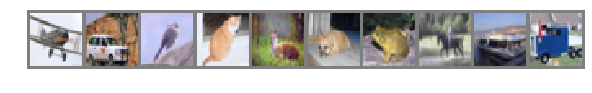

In [4]:
def imshow(img):
    img = img / 5 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.figure(figsize=(10, 5))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis("off")

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
# get some random training images
image_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=500, sampler=SubsetRandomSampler(indices), **kwargs
)
dataiter = iter(image_loader)
images, labels = dataiter.next()
labels = list(labels.numpy())
image_idx = [labels.index(i) for i in range(10)]

# show images
imshow(torchvision.utils.make_grid([images[i] for i in image_idx], nrow=10))
# print labels
# plt.title(' '.join('%10s    ' % classes[labels[i]] for i in image_idx))
if savefigs: plt.savefig("cifar10.png", dpi=300, bbox_inches="tight")

### Training a regular classifier with more and more data

In [5]:
n_training_examples = [25, 50, 100, 250, 500, 750, 1000, 2500, 5000, 10000, 15000, 20000]

def plot_mean_std(test_accs, c, label):
    data_mean = np.array([t[0] for t in test_accs])
    data_std = np.array([t[1] for t in test_accs])
    plt.plot(n_training_examples, data_mean, color=c, linewidth=1.8, label=label)
    if np.max(data_std) > 0:
        plt.plot(n_training_examples, data_mean+data_std, "--", color=c, linewidth=0.5, alpha=0.5)
        plt.plot(n_training_examples, data_mean-data_std, "--", color=c, linewidth=0.5, alpha=0.5)
        plt.fill_between(n_training_examples, data_mean+data_std, data_mean-data_std, color=c, alpha=0.05)

def plot_all(test_accuracies, title="", ylabel="Test"): 
    colors = get_colors(10)
    plt.figure()
    plot_mean_std(test_accuracies["B"], c="k", label="no pretraining")
    plot_mean_std(test_accuracies["BnB"], c=colors[6], label="pretr. on B")
    plot_mean_std(test_accuracies["ABnB"], c=colors[7], label="pretr. on A & B")
    plot_mean_std(test_accuracies["AnB"], c=colors[8], label="pretr. on A")
    if title:
        plt.title(title)
    plt.xlabel("Number of training examples for classifier")
    plt.xticks([25, 5000, 10000, 20000], [25, 5000, 10000, 20000])
    plt.ylabel("%s accuracy" % ylabel.title())
    if ylabel.lower() == "test":
        plt.ylim(0.55, 0.72)
    elif ylabel.lower() == "train":
        plt.ylim(0.55, 1.05)
    else:
        plt.ylabel("Generalization error")
    l = plt.legend(bbox_to_anchor=(1.02, 1), loc=2, borderaxespad=0.);
    print("n_training_examples =", n_training_examples)
    print("%s_accuracies =" % ylabel.lower(), test_accuracies)
    if savefigs: plt.savefig('img_%s_%s.pdf' % (ylabel.lower(), title.replace(" ", "_")), dpi=300, bbox_inches="tight", bbox_extra_artists=[l])

In [6]:
def test_clf(model, test_loader):
    criterion = nn.NLLLoss(reduction="sum")
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            if target.min() > 4:
                target -= 5
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target).item() # sum up batch loss
            pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()
    test_loss /= len(test_loader.sampler)
    print('Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)'.format(
        test_loss, correct, len(test_loader.sampler),
        100. * correct / len(test_loader.sampler)))
    return correct / len(test_loader.sampler)

def train_clf_epoch(model, epoch, train_loader, optimizer, lr_scheduler):
    criterion = nn.NLLLoss()
    model.train()
    running_loss = 0.
    for batch_idx, (data, target) in enumerate(train_loader):
        # for t1 the loss still expects the labels to be between 0 and 4
        if target.min() > 4:
            target -= 5
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        running_loss += loss.item()
        loss.backward()
        optimizer.step()
    print('[epoch %d] loss: %.7f' % (epoch + 1, running_loss / (batch_idx + 1)))
    lr_scheduler.step(running_loss)
    
def train_clf(model, train_loader, valid_loader, n_epochs=25):    
    print("Validation accuracy before training:")
    _ = test_clf(model, valid_loader)
    optimizer = optim.Adam(model.parameters(), lr=0.00005)
    lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=0, eps=0., verbose=True)

    best_acc = 0
    best_model = None

    for epoch in range(n_epochs):
        train_clf_epoch(model, epoch, train_loader, optimizer, lr_scheduler)
        val_acc = test_clf(model, valid_loader)
        if val_acc >= best_acc:
            best_acc = val_acc
            best_model = deepcopy(model.state_dict())
    model.load_state_dict(best_model)

    print("Validation:")
    _ = test_clf(model, valid_loader)
    return model

def train_clf_t2_ntrain(n_train, hu_pow=1, ffnn_dict=None, frozen=False):
    test_accs = []
    train_accs = []
    gen_err = []
    for seed in [11, 12, 13]:
        print("## seed:", seed)
        # get train_loader with specific number of training examples
        np.random.seed(seed)
        indices = np.random.permutation(indices_t2_train[:-n_valid])[:n_train]
        train_loader = torch.utils.data.DataLoader(
            train_dataset, batch_size=32, sampler=SubsetRandomSampler(indices), **kwargs
        )
        # pretrained ffnn?
        ffnn = FFNN(hu_pow)
        if ffnn_dict is not None:
            ffnn.load_state_dict(ffnn_dict)
        if frozen:
            for p in ffnn.parameters():
                p.requires_grad = False
        # do the actual training
        model = train_clf(CLF(ffnn).to(device), train_loader, valid_loader_t2)
        print("Test")
        test_accs.append(test_clf(model, test_loader_t2))
        train_accs.append(test_clf(model, train_loader))
        gen_err.append(train_accs[-1] - test_accs[-1])
        del ffnn, model, train_loader
        torch.cuda.empty_cache()
    return np.mean(test_accs), np.std(test_accs), np.mean(train_accs), np.std(train_accs), np.mean(gen_err), np.std(gen_err)

def pretrain_t2(hu_pow=1):
    # CLF pretraining on T2
    train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=32, sampler=SubsetRandomSampler(indices_t2_train[:-n_valid]), **kwargs
    )
    ffnn = FFNN(hu_pow)
    model = train_clf(CLF(ffnn).to(device), train_loader, valid_loader_t2)
    _ = test_clf(model, test_loader_t2)
    sd = deepcopy(model.ffnn.state_dict())
    del ffnn, model, train_loader
    torch.cuda.empty_cache()
    # return the ffnn state
    return sd

def pretrain_t1(hu_pow=1):
    # CLF pretraining on T1
    valid_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=128, sampler=SubsetRandomSampler(indices_t1_train[-n_valid:]), **kwargs
    )
    train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=32, sampler=SubsetRandomSampler(indices_t1_train[:-n_valid]), **kwargs
    )
    test_loader = torch.utils.data.DataLoader(
        test_dataset, batch_size=128, sampler=SubsetRandomSampler(indices_t1_test), **kwargs
    )
    ffnn = FFNN(hu_pow)
    model = train_clf(CLF(ffnn).to(device), train_loader, valid_loader)
    _ = test_clf(model, test_loader)
    sd = deepcopy(model.ffnn.state_dict())
    del ffnn, model, train_loader, valid_loader, test_loader
    torch.cuda.empty_cache()
    # return the ffnn state
    return sd

def pretrain_t1t2(hu_pow=1):
    # CLF pretraining on T1 + T2
    valid_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=128, sampler=SubsetRandomSampler(indices[-n_valid:]), **kwargs
    )
    train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=32, sampler=SubsetRandomSampler(indices[:len(indices_t2_train)]), **kwargs
    )
    test_loader = torch.utils.data.DataLoader(
        test_dataset, batch_size=128, sampler=SubsetRandomSampler(indices_test), **kwargs
    )
    ffnn = FFNN(hu_pow)
    model = train_clf(CLF(ffnn, n_classes=10).to(device), train_loader, valid_loader)
    _ = test_clf(model, test_loader)
    sd = deepcopy(model.ffnn.state_dict())
    del ffnn, model, train_loader, valid_loader, test_loader
    torch.cuda.empty_cache()
    # return the ffnn state
    return sd

def train_all_ntrain(hu_pow=1, ffnn_dict=None, frozen=False):
    # with or without pretraining (depending on ffnn_dict), do all ntrain trainings
    test_accuracies = []
    train_accuracies = []
    gen_errors = []
    for n_train in n_training_examples:
        print(n_train)
        test_mean, test_std, train_mean, train_std, gen_mean, gen_std = train_clf_t2_ntrain(n_train, hu_pow, ffnn_dict, frozen)
        test_accuracies.append((test_mean, test_std))
        train_accuracies.append((train_mean, train_std))
        gen_errors.append((gen_mean, gen_std))
        torch.cuda.empty_cache()
    return test_accuracies, train_accuracies, gen_errors

def do_all_hl(hu_pow=1):
    # for a certain number of hl, do the whole pretraining and fine tuning for all configs
    print("#### Training for %i hu" % 2**hu_pow)
    # no pretraining
    print("## No Pre-Training")
    test_accuracies_B, train_accuracies_B, gen_errors_B = train_all_ntrain(hu_pow)
    print("test_accuracies_B =", test_accuracies_B)
    print("train_accuracies_B =", train_accuracies_B)
    print("gen_errors_B =", gen_errors_B)
    torch.cuda.empty_cache()
    # pretraining on T2
    print("## Pre-Training BnB")
    ffnn_dict = pretrain_t2(hu_pow)
    test_accuracies_BnB, train_accuracies_BnB, gen_errors_BnB = train_all_ntrain(hu_pow, ffnn_dict)
    print("test_accuracies_BnB =", test_accuracies_BnB)
    print("train_accuracies_BnB =", train_accuracies_BnB)
    print("gen_errors_BnB =", gen_errors_BnB)
    torch.cuda.empty_cache()
    # pretraining on T1
    print("## Pre-Training AnB")
    ffnn_dict = pretrain_t1(hu_pow)
    test_accuracies_AnB, train_accuracies_AnB, gen_errors_AnB = train_all_ntrain(hu_pow, ffnn_dict)
    print("test_accuracies_AnB =", test_accuracies_AnB)
    print("train_accuracies_AnB =", train_accuracies_AnB)
    print("gen_errors_AnB =", gen_errors_AnB)
    torch.cuda.empty_cache()
    # pretraining on T1 and T2
    print("## Pre-Training ABnB")
    ffnn_dict = pretrain_t1t2(hu_pow)
    test_accuracies_ABnB, train_accuracies_ABnB, gen_errors_ABnB = train_all_ntrain(hu_pow, ffnn_dict)
    print("test_accuracies_ABnB =", test_accuracies_ABnB)
    print("train_accuracies_ABnB =", train_accuracies_ABnB)
    print("gen_errors_ABnB =", gen_errors_ABnB)
    torch.cuda.empty_cache()
    # save and plot results
    test_accuracies = { "B": test_accuracies_B,
                        "AnB": test_accuracies_AnB,
                        "BnB": test_accuracies_BnB,
                        "ABnB": test_accuracies_ABnB}
    train_accuracies = { "B": train_accuracies_B,
                        "AnB": train_accuracies_AnB,
                        "BnB": train_accuracies_BnB,
                        "ABnB": train_accuracies_ABnB}
    gen_errors = { "B": gen_errors_B,
                        "AnB": gen_errors_AnB,
                        "BnB": gen_errors_BnB,
                        "ABnB": gen_errors_ABnB}
    plot_all(test_accuracies, "$2^{%i}$ hidden units" % (hu_pow))
    plot_all(train_accuracies, "$2^{%i}$ hidden units" % (hu_pow), "Train")
    plot_all(gen_errors, "$2^{%i}$ hidden units" % (hu_pow), "generr")
    return test_accuracies, train_accuracies, gen_errors

#### Training for 128 hu
## No Pre-Training
25
## seed: 11
Validation accuracy before training:
Test set: Average loss: 1.6339, Accuracy: 933/5000 (19%)
[epoch 1] loss: 1.6221858
Test set: Average loss: 1.6172, Accuracy: 1102/5000 (22%)
[epoch 2] loss: 1.5581599
Test set: Average loss: 1.6021, Accuracy: 1248/5000 (25%)
[epoch 3] loss: 1.4975702
Test set: Average loss: 1.5885, Accuracy: 1375/5000 (28%)
[epoch 4] loss: 1.4407657
Test set: Average loss: 1.5763, Accuracy: 1481/5000 (30%)
[epoch 5] loss: 1.3878071
Test set: Average loss: 1.5655, Accuracy: 1551/5000 (31%)
[epoch 6] loss: 1.3385679
Test set: Average loss: 1.5559, Accuracy: 1596/5000 (32%)
[epoch 7] loss: 1.2928232
Test set: Average loss: 1.5474, Accuracy: 1638/5000 (33%)
[epoch 8] loss: 1.2502923
Test set: Average loss: 1.5399, Accuracy: 1681/5000 (34%)
[epoch 9] loss: 1.2106700
Test set: Average loss: 1.5333, Accuracy: 1710/5000 (34%)
[epoch 10] loss: 1.1736581
Test set: Average loss: 1.5275, Accuracy: 1732/5000 (35%)
[epoch

[epoch 11] loss: 1.0423809
Test set: Average loss: 1.4464, Accuracy: 1775/5000 (36%)
[epoch 12] loss: 0.9885863
Test set: Average loss: 1.4415, Accuracy: 1793/5000 (36%)
[epoch 13] loss: 0.9606667
Test set: Average loss: 1.4368, Accuracy: 1825/5000 (36%)
[epoch 14] loss: 0.9214023
Test set: Average loss: 1.4325, Accuracy: 1845/5000 (37%)
[epoch 15] loss: 0.9092874
Test set: Average loss: 1.4294, Accuracy: 1867/5000 (37%)
[epoch 16] loss: 0.8869039
Test set: Average loss: 1.4272, Accuracy: 1879/5000 (38%)
[epoch 17] loss: 0.8545061
Test set: Average loss: 1.4259, Accuracy: 1898/5000 (38%)
[epoch 18] loss: 0.8548108
Epoch    17: reducing learning rate of group 0 to 5.0000e-06.
Test set: Average loss: 1.4252, Accuracy: 1903/5000 (38%)
[epoch 19] loss: 0.8042983
Test set: Average loss: 1.4252, Accuracy: 1902/5000 (38%)
[epoch 20] loss: 0.8075487
Epoch    19: reducing learning rate of group 0 to 5.0000e-07.
Test set: Average loss: 1.4252, Accuracy: 1902/5000 (38%)
[epoch 21] loss: 0.8186505

Test set: Average loss: 1.4691, Accuracy: 1679/5000 (34%)
[epoch 5] loss: 1.2835650
Test set: Average loss: 1.4555, Accuracy: 1741/5000 (35%)
[epoch 6] loss: 1.2661514
Test set: Average loss: 1.4410, Accuracy: 1799/5000 (36%)
[epoch 7] loss: 1.2017828
Test set: Average loss: 1.4288, Accuracy: 1822/5000 (36%)
[epoch 8] loss: 1.1885149
Test set: Average loss: 1.4201, Accuracy: 1845/5000 (37%)
[epoch 9] loss: 1.1849679
Test set: Average loss: 1.4101, Accuracy: 1879/5000 (38%)
[epoch 10] loss: 1.1114257
Test set: Average loss: 1.4002, Accuracy: 1927/5000 (39%)
[epoch 11] loss: 1.1088152
Test set: Average loss: 1.3932, Accuracy: 1964/5000 (39%)
[epoch 12] loss: 1.0663403
Test set: Average loss: 1.3819, Accuracy: 2069/5000 (41%)
[epoch 13] loss: 1.0610526
Test set: Average loss: 1.3749, Accuracy: 2109/5000 (42%)
[epoch 14] loss: 0.9761462
Test set: Average loss: 1.3706, Accuracy: 2150/5000 (43%)
[epoch 15] loss: 0.9731187
Test set: Average loss: 1.3658, Accuracy: 2184/5000 (44%)
[epoch 16] l

Test set: Average loss: 1.3980, Accuracy: 2274/5000 (45%)
[epoch 20] loss: 1.2156292
Epoch    19: reducing learning rate of group 0 to 5.0000e-17.
Test set: Average loss: 1.3980, Accuracy: 2274/5000 (45%)
[epoch 21] loss: 1.1272731
Epoch    20: reducing learning rate of group 0 to 5.0000e-18.
Test set: Average loss: 1.3980, Accuracy: 2274/5000 (45%)
[epoch 22] loss: 1.1425960
Epoch    21: reducing learning rate of group 0 to 5.0000e-19.
Test set: Average loss: 1.3980, Accuracy: 2274/5000 (45%)
[epoch 23] loss: 1.1352541
Epoch    22: reducing learning rate of group 0 to 5.0000e-20.
Test set: Average loss: 1.3980, Accuracy: 2274/5000 (45%)
[epoch 24] loss: 1.1439047
Epoch    23: reducing learning rate of group 0 to 5.0000e-21.
Test set: Average loss: 1.3980, Accuracy: 2274/5000 (45%)
[epoch 25] loss: 1.1590315
Epoch    24: reducing learning rate of group 0 to 5.0000e-22.
Test set: Average loss: 1.3980, Accuracy: 2274/5000 (45%)
Validation:
Test set: Average loss: 1.3980, Accuracy: 2274/5

Test set: Average loss: 1.2756, Accuracy: 2581/5000 (52%)
Test set: Average loss: 0.7895, Accuracy: 227/250 (91%)
500
## seed: 11
Validation accuracy before training:
Test set: Average loss: 1.6136, Accuracy: 952/5000 (19%)
[epoch 1] loss: 1.4965698
Test set: Average loss: 1.3996, Accuracy: 2221/5000 (44%)
[epoch 2] loss: 1.3359981
Test set: Average loss: 1.3418, Accuracy: 2349/5000 (47%)
[epoch 3] loss: 1.2548407
Test set: Average loss: 1.3092, Accuracy: 2493/5000 (50%)
[epoch 4] loss: 1.1975501
Test set: Average loss: 1.2846, Accuracy: 2582/5000 (52%)
[epoch 5] loss: 1.1495383
Test set: Average loss: 1.2657, Accuracy: 2624/5000 (52%)
[epoch 6] loss: 1.1084759
Test set: Average loss: 1.2529, Accuracy: 2681/5000 (54%)
[epoch 7] loss: 1.0790430
Test set: Average loss: 1.2411, Accuracy: 2693/5000 (54%)
[epoch 8] loss: 1.0565458
Test set: Average loss: 1.2318, Accuracy: 2724/5000 (54%)
[epoch 9] loss: 1.0174994
Test set: Average loss: 1.2294, Accuracy: 2688/5000 (54%)
[epoch 10] loss: 0.9

[epoch 10] loss: 0.9559642
Test set: Average loss: 1.1742, Accuracy: 2793/5000 (56%)
[epoch 11] loss: 0.9386286
Test set: Average loss: 1.1699, Accuracy: 2792/5000 (56%)
[epoch 12] loss: 0.9153944
Test set: Average loss: 1.1627, Accuracy: 2815/5000 (56%)
[epoch 13] loss: 0.8899420
Test set: Average loss: 1.1586, Accuracy: 2823/5000 (56%)
[epoch 14] loss: 0.8669437
Test set: Average loss: 1.1576, Accuracy: 2819/5000 (56%)
[epoch 15] loss: 0.8536626
Test set: Average loss: 1.1515, Accuracy: 2834/5000 (57%)
[epoch 16] loss: 0.8305054
Test set: Average loss: 1.1467, Accuracy: 2822/5000 (56%)
[epoch 17] loss: 0.8056511
Test set: Average loss: 1.1449, Accuracy: 2829/5000 (57%)
[epoch 18] loss: 0.7889286
Test set: Average loss: 1.1418, Accuracy: 2857/5000 (57%)
[epoch 19] loss: 0.7716626
Test set: Average loss: 1.1393, Accuracy: 2842/5000 (57%)
[epoch 20] loss: 0.7505469
Test set: Average loss: 1.1366, Accuracy: 2835/5000 (57%)
[epoch 21] loss: 0.7344505
Test set: Average loss: 1.1358, Accura

Test set: Average loss: 1.1373, Accuracy: 2855/5000 (57%)
[epoch 22] loss: 0.7130070
Test set: Average loss: 1.1346, Accuracy: 2859/5000 (57%)
[epoch 23] loss: 0.6979379
Test set: Average loss: 1.1358, Accuracy: 2862/5000 (57%)
[epoch 24] loss: 0.6741432
Test set: Average loss: 1.1433, Accuracy: 2833/5000 (57%)
[epoch 25] loss: 0.6539581
Test set: Average loss: 1.1310, Accuracy: 2868/5000 (57%)
Validation:
Test set: Average loss: 1.1380, Accuracy: 2872/5000 (57%)
Test
Test set: Average loss: 1.1447, Accuracy: 2838/5000 (57%)
Test set: Average loss: 0.7254, Accuracy: 817/1000 (82%)
## seed: 12
Validation accuracy before training:
Test set: Average loss: 1.6823, Accuracy: 610/5000 (12%)
[epoch 1] loss: 1.4769819
Test set: Average loss: 1.3316, Accuracy: 2399/5000 (48%)
[epoch 2] loss: 1.2916620
Test set: Average loss: 1.2675, Accuracy: 2584/5000 (52%)
[epoch 3] loss: 1.2142199
Test set: Average loss: 1.2347, Accuracy: 2714/5000 (54%)
[epoch 4] loss: 1.1690381
Test set: Average loss: 1.21

Test set: Average loss: 1.1495, Accuracy: 2919/5000 (58%)
[epoch 5] loss: 1.0575176
Test set: Average loss: 1.1315, Accuracy: 2951/5000 (59%)
[epoch 6] loss: 1.0236509
Test set: Average loss: 1.1114, Accuracy: 2954/5000 (59%)
[epoch 7] loss: 0.9968373
Test set: Average loss: 1.1041, Accuracy: 3006/5000 (60%)
[epoch 8] loss: 0.9640896
Test set: Average loss: 1.0947, Accuracy: 2986/5000 (60%)
[epoch 9] loss: 0.9397536
Test set: Average loss: 1.0807, Accuracy: 3012/5000 (60%)
[epoch 10] loss: 0.9147646
Test set: Average loss: 1.0723, Accuracy: 3042/5000 (61%)
[epoch 11] loss: 0.8865642
Test set: Average loss: 1.0656, Accuracy: 3059/5000 (61%)
[epoch 12] loss: 0.8607516
Test set: Average loss: 1.0575, Accuracy: 3061/5000 (61%)
[epoch 13] loss: 0.8382622
Test set: Average loss: 1.0534, Accuracy: 3068/5000 (61%)
[epoch 14] loss: 0.8180066
Test set: Average loss: 1.0491, Accuracy: 3067/5000 (61%)
[epoch 15] loss: 0.7955597
Test set: Average loss: 1.0497, Accuracy: 3066/5000 (61%)
[epoch 16] l

[epoch 16] loss: 0.7169223
Test set: Average loss: 0.9779, Accuracy: 3187/5000 (64%)
[epoch 17] loss: 0.6960262
Test set: Average loss: 0.9763, Accuracy: 3181/5000 (64%)
[epoch 18] loss: 0.6743785
Test set: Average loss: 0.9802, Accuracy: 3176/5000 (64%)
[epoch 19] loss: 0.6525467
Test set: Average loss: 0.9702, Accuracy: 3194/5000 (64%)
[epoch 20] loss: 0.6257860
Test set: Average loss: 0.9787, Accuracy: 3170/5000 (63%)
[epoch 21] loss: 0.6059191
Test set: Average loss: 0.9678, Accuracy: 3200/5000 (64%)
[epoch 22] loss: 0.5894950
Test set: Average loss: 0.9740, Accuracy: 3195/5000 (64%)
[epoch 23] loss: 0.5640725
Test set: Average loss: 0.9819, Accuracy: 3170/5000 (63%)
[epoch 24] loss: 0.5426092
Test set: Average loss: 0.9728, Accuracy: 3188/5000 (64%)
[epoch 25] loss: 0.5185663
Test set: Average loss: 0.9775, Accuracy: 3152/5000 (63%)
Validation:
Test set: Average loss: 0.9678, Accuracy: 3200/5000 (64%)
Test
Test set: Average loss: 0.9845, Accuracy: 3125/5000 (62%)
Test set: Average

Test set: Average loss: 0.4625, Accuracy: 8740/10000 (87%)
## seed: 13
Validation accuracy before training:
Test set: Average loss: 1.6070, Accuracy: 1354/5000 (27%)
[epoch 1] loss: 1.2499141
Test set: Average loss: 1.1631, Accuracy: 2898/5000 (58%)
[epoch 2] loss: 1.1116709
Test set: Average loss: 1.1005, Accuracy: 3033/5000 (61%)
[epoch 3] loss: 1.0455764
Test set: Average loss: 1.0509, Accuracy: 3106/5000 (62%)
[epoch 4] loss: 0.9938700
Test set: Average loss: 1.0251, Accuracy: 3121/5000 (62%)
[epoch 5] loss: 0.9537523
Test set: Average loss: 0.9971, Accuracy: 3191/5000 (64%)
[epoch 6] loss: 0.9141839
Test set: Average loss: 0.9854, Accuracy: 3191/5000 (64%)
[epoch 7] loss: 0.8819697
Test set: Average loss: 0.9674, Accuracy: 3208/5000 (64%)
[epoch 8] loss: 0.8515266
Test set: Average loss: 0.9550, Accuracy: 3241/5000 (65%)
[epoch 9] loss: 0.8204814
Test set: Average loss: 0.9417, Accuracy: 3250/5000 (65%)
[epoch 10] loss: 0.7897501
Test set: Average loss: 0.9401, Accuracy: 3250/5000

Test set: Average loss: 0.8973, Accuracy: 3341/5000 (67%)
[epoch 11] loss: 0.7241284
Test set: Average loss: 0.8945, Accuracy: 3343/5000 (67%)
[epoch 12] loss: 0.6962153
Test set: Average loss: 0.8902, Accuracy: 3366/5000 (67%)
[epoch 13] loss: 0.6709935
Test set: Average loss: 0.8873, Accuracy: 3370/5000 (67%)
[epoch 14] loss: 0.6438150
Test set: Average loss: 0.8810, Accuracy: 3356/5000 (67%)
[epoch 15] loss: 0.6176967
Test set: Average loss: 0.8817, Accuracy: 3399/5000 (68%)
[epoch 16] loss: 0.5922457
Test set: Average loss: 0.8871, Accuracy: 3360/5000 (67%)
[epoch 17] loss: 0.5656680
Test set: Average loss: 0.8951, Accuracy: 3369/5000 (67%)
[epoch 18] loss: 0.5407778
Test set: Average loss: 0.8963, Accuracy: 3355/5000 (67%)
[epoch 19] loss: 0.5157027
Test set: Average loss: 0.8878, Accuracy: 3371/5000 (67%)
[epoch 20] loss: 0.4896124
Test set: Average loss: 0.8952, Accuracy: 3373/5000 (67%)
[epoch 21] loss: 0.4653589
Test set: Average loss: 0.8950, Accuracy: 3360/5000 (67%)
[epoch 

[epoch 22] loss: 0.4282206
Test set: Average loss: 0.9103, Accuracy: 3412/5000 (68%)
[epoch 23] loss: 0.4069652
Test set: Average loss: 0.9176, Accuracy: 3399/5000 (68%)
[epoch 24] loss: 0.3837853
Test set: Average loss: 0.9190, Accuracy: 3384/5000 (68%)
[epoch 25] loss: 0.3620967
Test set: Average loss: 0.9374, Accuracy: 3381/5000 (68%)
Validation:
Test set: Average loss: 0.8692, Accuracy: 3427/5000 (69%)
Test
Test set: Average loss: 0.8869, Accuracy: 3371/5000 (67%)
Test set: Average loss: 0.5594, Accuracy: 16518/20000 (83%)
## Pre-Training BnB
Validation accuracy before training:
Test set: Average loss: 1.6186, Accuracy: 1151/5000 (23%)
[epoch 1] loss: 1.1797077
Test set: Average loss: 1.0803, Accuracy: 3073/5000 (61%)
[epoch 2] loss: 1.0398168
Test set: Average loss: 1.0189, Accuracy: 3145/5000 (63%)
[epoch 3] loss: 0.9754214
Test set: Average loss: 0.9766, Accuracy: 3227/5000 (65%)
[epoch 4] loss: 0.9274103
Test set: Average loss: 0.9521, Accuracy: 3237/5000 (65%)
[epoch 5] loss: 

[epoch 6] loss: 1.5587106
Test set: Average loss: 1.6910, Accuracy: 800/5000 (16%)
[epoch 7] loss: 1.5256531
Test set: Average loss: 1.6840, Accuracy: 823/5000 (16%)
[epoch 8] loss: 1.4946421
Test set: Average loss: 1.6770, Accuracy: 853/5000 (17%)
[epoch 9] loss: 1.4656780
Test set: Average loss: 1.6702, Accuracy: 887/5000 (18%)
[epoch 10] loss: 1.4386281
Test set: Average loss: 1.6635, Accuracy: 910/5000 (18%)
[epoch 11] loss: 1.4132850
Test set: Average loss: 1.6569, Accuracy: 954/5000 (19%)
[epoch 12] loss: 1.3894360
Test set: Average loss: 1.6505, Accuracy: 998/5000 (20%)
[epoch 13] loss: 1.3669078
Test set: Average loss: 1.6443, Accuracy: 1022/5000 (20%)
[epoch 14] loss: 1.3455651
Test set: Average loss: 1.6383, Accuracy: 1060/5000 (21%)
[epoch 15] loss: 1.3252872
Test set: Average loss: 1.6325, Accuracy: 1091/5000 (22%)
[epoch 16] loss: 1.3059518
Test set: Average loss: 1.6268, Accuracy: 1128/5000 (23%)
[epoch 17] loss: 1.2874420
Test set: Average loss: 1.6214, Accuracy: 1160/50

[epoch 3] loss: 1.6494607
Test set: Average loss: 1.6986, Accuracy: 795/5000 (16%)
[epoch 4] loss: 1.6076436
Test set: Average loss: 1.6818, Accuracy: 849/5000 (17%)
[epoch 5] loss: 1.5383638
Test set: Average loss: 1.6661, Accuracy: 919/5000 (18%)
[epoch 6] loss: 1.4875141
Test set: Average loss: 1.6512, Accuracy: 997/5000 (20%)
[epoch 7] loss: 1.4592890
Test set: Average loss: 1.6374, Accuracy: 1072/5000 (21%)
[epoch 8] loss: 1.4186898
Test set: Average loss: 1.6249, Accuracy: 1144/5000 (23%)
[epoch 9] loss: 1.3817707
Test set: Average loss: 1.6131, Accuracy: 1209/5000 (24%)
[epoch 10] loss: 1.3229644
Test set: Average loss: 1.6018, Accuracy: 1281/5000 (26%)
[epoch 11] loss: 1.3070660
Test set: Average loss: 1.5911, Accuracy: 1347/5000 (27%)
[epoch 12] loss: 1.2664788
Test set: Average loss: 1.5813, Accuracy: 1394/5000 (28%)
[epoch 13] loss: 1.2386913
Test set: Average loss: 1.5723, Accuracy: 1438/5000 (29%)
[epoch 14] loss: 1.2135784
Test set: Average loss: 1.5638, Accuracy: 1495/50

[epoch 24] loss: 1.3135657
Epoch    23: reducing learning rate of group 0 to 5.0000e-21.
Test set: Average loss: 1.5286, Accuracy: 1689/5000 (34%)
[epoch 25] loss: 1.3647844
Epoch    24: reducing learning rate of group 0 to 5.0000e-22.
Test set: Average loss: 1.5286, Accuracy: 1689/5000 (34%)
Validation:
Test set: Average loss: 1.5286, Accuracy: 1689/5000 (34%)
Test
Test set: Average loss: 1.5303, Accuracy: 1612/5000 (32%)
Test set: Average loss: 1.3321, Accuracy: 61/100 (61%)
## seed: 13
Validation accuracy before training:
Test set: Average loss: 1.6718, Accuracy: 644/5000 (13%)
[epoch 1] loss: 1.6317462
Test set: Average loss: 1.6489, Accuracy: 762/5000 (15%)
[epoch 2] loss: 1.5352804
Test set: Average loss: 1.6284, Accuracy: 909/5000 (18%)
[epoch 3] loss: 1.5149220
Test set: Average loss: 1.6100, Accuracy: 1033/5000 (21%)
[epoch 4] loss: 1.4869729
Test set: Average loss: 1.5934, Accuracy: 1157/5000 (23%)
[epoch 5] loss: 1.4147576
Test set: Average loss: 1.5774, Accuracy: 1295/5000 

Test set: Average loss: 1.3313, Accuracy: 2404/5000 (48%)
[epoch 23] loss: 0.9551458
Test set: Average loss: 1.3270, Accuracy: 2408/5000 (48%)
[epoch 24] loss: 0.9380231
Test set: Average loss: 1.3227, Accuracy: 2423/5000 (48%)
[epoch 25] loss: 0.9208485
Test set: Average loss: 1.3199, Accuracy: 2440/5000 (49%)
Validation:
Test set: Average loss: 1.3199, Accuracy: 2440/5000 (49%)
Test
Test set: Average loss: 1.3213, Accuracy: 2412/5000 (48%)
Test set: Average loss: 0.9087, Accuracy: 224/250 (90%)
## seed: 13
Validation accuracy before training:
Test set: Average loss: 1.6080, Accuracy: 1270/5000 (25%)
[epoch 1] loss: 1.5999067
Test set: Average loss: 1.5569, Accuracy: 1421/5000 (28%)
[epoch 2] loss: 1.5053255
Test set: Average loss: 1.5092, Accuracy: 1589/5000 (32%)
[epoch 3] loss: 1.4285994
Test set: Average loss: 1.4714, Accuracy: 1751/5000 (35%)
[epoch 4] loss: 1.3646533
Test set: Average loss: 1.4414, Accuracy: 1867/5000 (37%)
[epoch 5] loss: 1.3059521
Test set: Average loss: 1.417

Test set: Average loss: 1.3585, Accuracy: 2323/5000 (46%)
[epoch 6] loss: 1.1971340
Test set: Average loss: 1.3434, Accuracy: 2363/5000 (47%)
[epoch 7] loss: 1.1584875
Test set: Average loss: 1.3288, Accuracy: 2428/5000 (49%)
[epoch 8] loss: 1.1363753
Test set: Average loss: 1.3173, Accuracy: 2453/5000 (49%)
[epoch 9] loss: 1.1091790
Test set: Average loss: 1.3065, Accuracy: 2493/5000 (50%)
[epoch 10] loss: 1.0824091
Test set: Average loss: 1.2963, Accuracy: 2542/5000 (51%)
[epoch 11] loss: 1.0604572
Test set: Average loss: 1.2876, Accuracy: 2543/5000 (51%)
[epoch 12] loss: 1.0377117
Test set: Average loss: 1.2776, Accuracy: 2582/5000 (52%)
[epoch 13] loss: 1.0207817
Test set: Average loss: 1.2703, Accuracy: 2608/5000 (52%)
[epoch 14] loss: 0.9946957
Test set: Average loss: 1.2620, Accuracy: 2621/5000 (52%)
[epoch 15] loss: 0.9796536
Test set: Average loss: 1.2539, Accuracy: 2639/5000 (53%)
[epoch 16] loss: 0.9564397
Test set: Average loss: 1.2481, Accuracy: 2649/5000 (53%)
[epoch 17] 

[epoch 17] loss: 0.8577674
Test set: Average loss: 1.1657, Accuracy: 2859/5000 (57%)
[epoch 18] loss: 0.8361341
Test set: Average loss: 1.1600, Accuracy: 2860/5000 (57%)
[epoch 19] loss: 0.8215337
Test set: Average loss: 1.1548, Accuracy: 2871/5000 (57%)
[epoch 20] loss: 0.8005067
Test set: Average loss: 1.1490, Accuracy: 2887/5000 (58%)
[epoch 21] loss: 0.7836004
Test set: Average loss: 1.1452, Accuracy: 2897/5000 (58%)
[epoch 22] loss: 0.7695261
Test set: Average loss: 1.1407, Accuracy: 2897/5000 (58%)
[epoch 23] loss: 0.7472083
Test set: Average loss: 1.1371, Accuracy: 2900/5000 (58%)
[epoch 24] loss: 0.7305583
Test set: Average loss: 1.1324, Accuracy: 2921/5000 (58%)
[epoch 25] loss: 0.7144018
Test set: Average loss: 1.1291, Accuracy: 2909/5000 (58%)
Validation:
Test set: Average loss: 1.1324, Accuracy: 2921/5000 (58%)
Test
Test set: Average loss: 1.1572, Accuracy: 2832/5000 (57%)
Test set: Average loss: 0.7145, Accuracy: 674/750 (90%)
1000
## seed: 11
Validation accuracy before tr

Test set: Average loss: 1.7592, Accuracy: 379/5000 (8%)
[epoch 1] loss: 1.5021565
Test set: Average loss: 1.3819, Accuracy: 2204/5000 (44%)
[epoch 2] loss: 1.2920968
Test set: Average loss: 1.2920, Accuracy: 2481/5000 (50%)
[epoch 3] loss: 1.2085713
Test set: Average loss: 1.2380, Accuracy: 2660/5000 (53%)
[epoch 4] loss: 1.1460972
Test set: Average loss: 1.2019, Accuracy: 2798/5000 (56%)
[epoch 5] loss: 1.0875383
Test set: Average loss: 1.1751, Accuracy: 2858/5000 (57%)
[epoch 6] loss: 1.0521546
Test set: Average loss: 1.1526, Accuracy: 2936/5000 (59%)
[epoch 7] loss: 1.0148881
Test set: Average loss: 1.1353, Accuracy: 2946/5000 (59%)
[epoch 8] loss: 0.9739416
Test set: Average loss: 1.1209, Accuracy: 2991/5000 (60%)
[epoch 9] loss: 0.9438473
Test set: Average loss: 1.1025, Accuracy: 3008/5000 (60%)
[epoch 10] loss: 0.9099748
Test set: Average loss: 1.0894, Accuracy: 3029/5000 (61%)
[epoch 11] loss: 0.8817486
Test set: Average loss: 1.0789, Accuracy: 3028/5000 (61%)
[epoch 12] loss: 0

[epoch 12] loss: 0.6699082
Test set: Average loss: 0.9462, Accuracy: 3285/5000 (66%)
[epoch 13] loss: 0.6361022
Test set: Average loss: 0.9406, Accuracy: 3273/5000 (65%)
[epoch 14] loss: 0.6068137
Test set: Average loss: 0.9312, Accuracy: 3290/5000 (66%)
[epoch 15] loss: 0.5778880
Test set: Average loss: 0.9358, Accuracy: 3270/5000 (65%)
[epoch 16] loss: 0.5494934
Test set: Average loss: 0.9285, Accuracy: 3290/5000 (66%)
[epoch 17] loss: 0.5224496
Test set: Average loss: 0.9229, Accuracy: 3305/5000 (66%)
[epoch 18] loss: 0.4962975
Test set: Average loss: 0.9206, Accuracy: 3285/5000 (66%)
[epoch 19] loss: 0.4705888
Test set: Average loss: 0.9225, Accuracy: 3287/5000 (66%)
[epoch 20] loss: 0.4463895
Test set: Average loss: 0.9235, Accuracy: 3280/5000 (66%)
[epoch 21] loss: 0.4238905
Test set: Average loss: 0.9204, Accuracy: 3299/5000 (66%)
[epoch 22] loss: 0.4011834
Test set: Average loss: 0.9264, Accuracy: 3276/5000 (66%)
[epoch 23] loss: 0.3797992
Test set: Average loss: 0.9313, Accura

Test set: Average loss: 0.9512, Accuracy: 3345/5000 (67%)
[epoch 24] loss: 0.2657222
Test set: Average loss: 0.9700, Accuracy: 3319/5000 (66%)
[epoch 25] loss: 0.2468255
Test set: Average loss: 0.9760, Accuracy: 3294/5000 (66%)
Validation:
Test set: Average loss: 0.8861, Accuracy: 3366/5000 (67%)
Test
Test set: Average loss: 0.9023, Accuracy: 3323/5000 (66%)
Test set: Average loss: 0.4680, Accuracy: 8789/10000 (88%)
## seed: 12
Validation accuracy before training:
Test set: Average loss: 1.6646, Accuracy: 909/5000 (18%)
[epoch 1] loss: 1.3212066
Test set: Average loss: 1.2057, Accuracy: 2867/5000 (57%)
[epoch 2] loss: 1.1239718
Test set: Average loss: 1.1132, Accuracy: 3075/5000 (62%)
[epoch 3] loss: 1.0299854
Test set: Average loss: 1.0571, Accuracy: 3155/5000 (63%)
[epoch 4] loss: 0.9595561
Test set: Average loss: 1.0141, Accuracy: 3208/5000 (64%)
[epoch 5] loss: 0.8993244
Test set: Average loss: 0.9872, Accuracy: 3241/5000 (65%)
[epoch 6] loss: 0.8492766
Test set: Average loss: 0.95

[epoch 6] loss: 0.7740585
Test set: Average loss: 0.9110, Accuracy: 3353/5000 (67%)
[epoch 7] loss: 0.7285587
Test set: Average loss: 0.8991, Accuracy: 3329/5000 (67%)
[epoch 8] loss: 0.6876418
Test set: Average loss: 0.8976, Accuracy: 3381/5000 (68%)
[epoch 9] loss: 0.6488879
Test set: Average loss: 0.8871, Accuracy: 3368/5000 (67%)
[epoch 10] loss: 0.6148650
Test set: Average loss: 0.8830, Accuracy: 3379/5000 (68%)
[epoch 11] loss: 0.5811022
Test set: Average loss: 0.8940, Accuracy: 3369/5000 (67%)
[epoch 12] loss: 0.5505154
Test set: Average loss: 0.8802, Accuracy: 3386/5000 (68%)
[epoch 13] loss: 0.5207040
Test set: Average loss: 0.8857, Accuracy: 3401/5000 (68%)
[epoch 14] loss: 0.4923117
Test set: Average loss: 0.8897, Accuracy: 3374/5000 (67%)
[epoch 15] loss: 0.4637448
Test set: Average loss: 0.8952, Accuracy: 3360/5000 (67%)
[epoch 16] loss: 0.4371775
Test set: Average loss: 0.8993, Accuracy: 3353/5000 (67%)
[epoch 17] loss: 0.4126311
Test set: Average loss: 0.9124, Accuracy: 

Test set: Average loss: 0.9631, Accuracy: 3350/5000 (67%)
[epoch 18] loss: 0.3051350
Test set: Average loss: 0.9835, Accuracy: 3327/5000 (67%)
[epoch 19] loss: 0.2876406
Test set: Average loss: 1.0052, Accuracy: 3334/5000 (67%)
[epoch 20] loss: 0.2683348
Test set: Average loss: 1.0206, Accuracy: 3322/5000 (66%)
[epoch 21] loss: 0.2520448
Test set: Average loss: 1.0430, Accuracy: 3339/5000 (67%)
[epoch 22] loss: 0.2371818
Test set: Average loss: 1.0517, Accuracy: 3329/5000 (67%)
[epoch 23] loss: 0.2202382
Test set: Average loss: 1.0672, Accuracy: 3311/5000 (66%)
[epoch 24] loss: 0.2062424
Test set: Average loss: 1.1010, Accuracy: 3291/5000 (66%)
[epoch 25] loss: 0.1929191
Test set: Average loss: 1.1205, Accuracy: 3262/5000 (65%)
Validation:
Test set: Average loss: 0.8702, Accuracy: 3399/5000 (68%)
Test
Test set: Average loss: 0.8759, Accuracy: 3372/5000 (67%)
Test set: Average loss: 0.5229, Accuracy: 16901/20000 (85%)
## seed: 13
Validation accuracy before training:
Test set: Average lo

[epoch 1] loss: 1.6716303
Test set: Average loss: 1.6452, Accuracy: 829/5000 (17%)
[epoch 2] loss: 1.6251773
Test set: Average loss: 1.6346, Accuracy: 887/5000 (18%)
[epoch 3] loss: 1.5795965
Test set: Average loss: 1.6244, Accuracy: 939/5000 (19%)
[epoch 4] loss: 1.5354952
Test set: Average loss: 1.6148, Accuracy: 998/5000 (20%)
[epoch 5] loss: 1.4933696
Test set: Average loss: 1.6058, Accuracy: 1061/5000 (21%)
[epoch 6] loss: 1.4536127
Test set: Average loss: 1.5973, Accuracy: 1107/5000 (22%)
[epoch 7] loss: 1.4164743
Test set: Average loss: 1.5895, Accuracy: 1166/5000 (23%)
[epoch 8] loss: 1.3820145
Test set: Average loss: 1.5823, Accuracy: 1193/5000 (24%)
[epoch 9] loss: 1.3501221
Test set: Average loss: 1.5757, Accuracy: 1221/5000 (24%)
[epoch 10] loss: 1.3205811
Test set: Average loss: 1.5696, Accuracy: 1255/5000 (25%)
[epoch 11] loss: 1.2931390
Test set: Average loss: 1.5640, Accuracy: 1290/5000 (26%)
[epoch 12] loss: 1.2675418
Test set: Average loss: 1.5588, Accuracy: 1338/5000

Test set: Average loss: 1.6868, Accuracy: 963/5000 (19%)
[epoch 6] loss: 1.5313068
Test set: Average loss: 1.6756, Accuracy: 1002/5000 (20%)
[epoch 7] loss: 1.4985461
Test set: Average loss: 1.6649, Accuracy: 1035/5000 (21%)
[epoch 8] loss: 1.4509532
Test set: Average loss: 1.6545, Accuracy: 1060/5000 (21%)
[epoch 9] loss: 1.4023536
Test set: Average loss: 1.6448, Accuracy: 1101/5000 (22%)
[epoch 10] loss: 1.3602370
Test set: Average loss: 1.6360, Accuracy: 1148/5000 (23%)
[epoch 11] loss: 1.3282616
Test set: Average loss: 1.6276, Accuracy: 1203/5000 (24%)
[epoch 12] loss: 1.3304234
Epoch    11: reducing learning rate of group 0 to 5.0000e-06.
Test set: Average loss: 1.6196, Accuracy: 1248/5000 (25%)
[epoch 13] loss: 1.2802533
Test set: Average loss: 1.6189, Accuracy: 1249/5000 (25%)
[epoch 14] loss: 1.2603082
Test set: Average loss: 1.6182, Accuracy: 1250/5000 (25%)
[epoch 15] loss: 1.2902563
Epoch    14: reducing learning rate of group 0 to 5.0000e-07.
Test set: Average loss: 1.6176,

Test set: Average loss: 1.4473, Accuracy: 1698/5000 (34%)
[epoch 24] loss: 1.1107739
Epoch    23: reducing learning rate of group 0 to 5.0000e-16.
Test set: Average loss: 1.4473, Accuracy: 1698/5000 (34%)
[epoch 25] loss: 1.1571169
Epoch    24: reducing learning rate of group 0 to 5.0000e-17.
Test set: Average loss: 1.4473, Accuracy: 1698/5000 (34%)
Validation:
Test set: Average loss: 1.4473, Accuracy: 1698/5000 (34%)
Test
Test set: Average loss: 1.4529, Accuracy: 1670/5000 (33%)
Test set: Average loss: 1.1526, Accuracy: 69/100 (69%)
## seed: 12
Validation accuracy before training:
Test set: Average loss: 1.6866, Accuracy: 794/5000 (16%)
[epoch 1] loss: 1.6706929
Test set: Average loss: 1.6505, Accuracy: 895/5000 (18%)
[epoch 2] loss: 1.5780961
Test set: Average loss: 1.6184, Accuracy: 1097/5000 (22%)
[epoch 3] loss: 1.6102410
Epoch     2: reducing learning rate of group 0 to 5.0000e-06.
Test set: Average loss: 1.5899, Accuracy: 1283/5000 (26%)
[epoch 4] loss: 1.4734114
Test set: Avera

[epoch 7] loss: 1.3320881
Test set: Average loss: 1.4752, Accuracy: 1853/5000 (37%)
[epoch 8] loss: 1.2987592
Test set: Average loss: 1.4603, Accuracy: 1936/5000 (39%)
[epoch 9] loss: 1.2694781
Test set: Average loss: 1.4481, Accuracy: 1999/5000 (40%)
[epoch 10] loss: 1.2431657
Test set: Average loss: 1.4379, Accuracy: 2036/5000 (41%)
[epoch 11] loss: 1.2172810
Test set: Average loss: 1.4276, Accuracy: 2068/5000 (41%)
[epoch 12] loss: 1.1935750
Test set: Average loss: 1.4182, Accuracy: 2105/5000 (42%)
[epoch 13] loss: 1.1723126
Test set: Average loss: 1.4103, Accuracy: 2133/5000 (43%)
[epoch 14] loss: 1.1483633
Test set: Average loss: 1.4017, Accuracy: 2166/5000 (43%)
[epoch 15] loss: 1.1239905
Test set: Average loss: 1.3948, Accuracy: 2187/5000 (44%)
[epoch 16] loss: 1.1055625
Test set: Average loss: 1.3876, Accuracy: 2218/5000 (44%)
[epoch 17] loss: 1.0860284
Test set: Average loss: 1.3810, Accuracy: 2235/5000 (45%)
[epoch 18] loss: 1.0658718
Test set: Average loss: 1.3761, Accuracy:

Test set: Average loss: 1.2434, Accuracy: 2686/5000 (54%)
[epoch 19] loss: 0.9408130
Test set: Average loss: 1.2377, Accuracy: 2704/5000 (54%)
[epoch 20] loss: 0.9214574
Test set: Average loss: 1.2327, Accuracy: 2707/5000 (54%)
[epoch 21] loss: 0.9081620
Test set: Average loss: 1.2291, Accuracy: 2716/5000 (54%)
[epoch 22] loss: 0.8871041
Test set: Average loss: 1.2237, Accuracy: 2736/5000 (55%)
[epoch 23] loss: 0.8715593
Test set: Average loss: 1.2200, Accuracy: 2736/5000 (55%)
[epoch 24] loss: 0.8558710
Test set: Average loss: 1.2164, Accuracy: 2747/5000 (55%)
[epoch 25] loss: 0.8405217
Test set: Average loss: 1.2118, Accuracy: 2747/5000 (55%)
Validation:
Test set: Average loss: 1.2118, Accuracy: 2747/5000 (55%)
Test
Test set: Average loss: 1.2249, Accuracy: 2669/5000 (53%)
Test set: Average loss: 0.8256, Accuracy: 420/500 (84%)
## seed: 12
Validation accuracy before training:
Test set: Average loss: 1.6665, Accuracy: 915/5000 (18%)
[epoch 1] loss: 1.6256121
Test set: Average loss: 1.

Test set: Average loss: 1.4898, Accuracy: 1822/5000 (36%)
[epoch 2] loss: 1.4252187
Test set: Average loss: 1.4184, Accuracy: 2093/5000 (42%)
[epoch 3] loss: 1.3531016
Test set: Average loss: 1.3741, Accuracy: 2271/5000 (45%)
[epoch 4] loss: 1.2941945
Test set: Average loss: 1.3433, Accuracy: 2364/5000 (47%)
[epoch 5] loss: 1.2432170
Test set: Average loss: 1.3182, Accuracy: 2441/5000 (49%)
[epoch 6] loss: 1.2012725
Test set: Average loss: 1.2969, Accuracy: 2510/5000 (50%)
[epoch 7] loss: 1.1687085
Test set: Average loss: 1.2767, Accuracy: 2567/5000 (51%)
[epoch 8] loss: 1.1304901
Test set: Average loss: 1.2599, Accuracy: 2632/5000 (53%)
[epoch 9] loss: 1.0979803
Test set: Average loss: 1.2461, Accuracy: 2670/5000 (53%)
[epoch 10] loss: 1.0678627
Test set: Average loss: 1.2338, Accuracy: 2685/5000 (54%)
[epoch 11] loss: 1.0364432
Test set: Average loss: 1.2225, Accuracy: 2718/5000 (54%)
[epoch 12] loss: 1.0114631
Test set: Average loss: 1.2108, Accuracy: 2739/5000 (55%)
[epoch 13] loss

[epoch 13] loss: 0.9942654
Test set: Average loss: 1.1842, Accuracy: 2826/5000 (57%)
[epoch 14] loss: 0.9604535
Test set: Average loss: 1.1766, Accuracy: 2844/5000 (57%)
[epoch 15] loss: 0.9332808
Test set: Average loss: 1.1702, Accuracy: 2849/5000 (57%)
[epoch 16] loss: 0.9157437
Test set: Average loss: 1.1645, Accuracy: 2839/5000 (57%)
[epoch 17] loss: 0.8960592
Test set: Average loss: 1.1555, Accuracy: 2855/5000 (57%)
[epoch 18] loss: 0.8757691
Test set: Average loss: 1.1504, Accuracy: 2855/5000 (57%)
[epoch 19] loss: 0.8569427
Test set: Average loss: 1.1449, Accuracy: 2871/5000 (57%)
[epoch 20] loss: 0.8407631
Test set: Average loss: 1.1393, Accuracy: 2870/5000 (57%)
[epoch 21] loss: 0.8092829
Test set: Average loss: 1.1323, Accuracy: 2892/5000 (58%)
[epoch 22] loss: 0.7886267
Test set: Average loss: 1.1291, Accuracy: 2871/5000 (57%)
[epoch 23] loss: 0.7704477
Test set: Average loss: 1.1257, Accuracy: 2896/5000 (58%)
[epoch 24] loss: 0.7508891
Test set: Average loss: 1.1212, Accura

Test set: Average loss: 1.0201, Accuracy: 3125/5000 (62%)
[epoch 25] loss: 0.6106342
Test set: Average loss: 1.0191, Accuracy: 3092/5000 (62%)
Validation:
Test set: Average loss: 1.0201, Accuracy: 3125/5000 (62%)
Test
Test set: Average loss: 1.0363, Accuracy: 3007/5000 (60%)
Test set: Average loss: 0.6049, Accuracy: 2160/2500 (86%)
## seed: 13
Validation accuracy before training:
Test set: Average loss: 1.7191, Accuracy: 839/5000 (17%)
[epoch 1] loss: 1.4889416
Test set: Average loss: 1.3885, Accuracy: 2333/5000 (47%)
[epoch 2] loss: 1.3119399
Test set: Average loss: 1.3005, Accuracy: 2586/5000 (52%)
[epoch 3] loss: 1.2229973
Test set: Average loss: 1.2485, Accuracy: 2687/5000 (54%)
[epoch 4] loss: 1.1566874
Test set: Average loss: 1.2113, Accuracy: 2783/5000 (56%)
[epoch 5] loss: 1.1094885
Test set: Average loss: 1.1833, Accuracy: 2853/5000 (57%)
[epoch 6] loss: 1.0703704
Test set: Average loss: 1.1617, Accuracy: 2863/5000 (57%)
[epoch 7] loss: 1.0303330
Test set: Average loss: 1.1448

Test set: Average loss: 1.0386, Accuracy: 3103/5000 (62%)
[epoch 8] loss: 0.8927476
Test set: Average loss: 1.0254, Accuracy: 3128/5000 (63%)
[epoch 9] loss: 0.8579799
Test set: Average loss: 1.0124, Accuracy: 3140/5000 (63%)
[epoch 10] loss: 0.8292102
Test set: Average loss: 1.0016, Accuracy: 3152/5000 (63%)
[epoch 11] loss: 0.7969282
Test set: Average loss: 0.9921, Accuracy: 3143/5000 (63%)
[epoch 12] loss: 0.7682004
Test set: Average loss: 0.9854, Accuracy: 3154/5000 (63%)
[epoch 13] loss: 0.7394200
Test set: Average loss: 0.9772, Accuracy: 3179/5000 (64%)
[epoch 14] loss: 0.7127092
Test set: Average loss: 0.9724, Accuracy: 3186/5000 (64%)
[epoch 15] loss: 0.6840356
Test set: Average loss: 0.9650, Accuracy: 3186/5000 (64%)
[epoch 16] loss: 0.6584919
Test set: Average loss: 0.9620, Accuracy: 3202/5000 (64%)
[epoch 17] loss: 0.6338479
Test set: Average loss: 0.9596, Accuracy: 3198/5000 (64%)
[epoch 18] loss: 0.6109202
Test set: Average loss: 0.9559, Accuracy: 3205/5000 (64%)
[epoch 19

[epoch 19] loss: 0.5135160
Test set: Average loss: 0.9333, Accuracy: 3316/5000 (66%)
[epoch 20] loss: 0.4905347
Test set: Average loss: 0.9343, Accuracy: 3283/5000 (66%)
[epoch 21] loss: 0.4660751
Test set: Average loss: 0.9372, Accuracy: 3296/5000 (66%)
[epoch 22] loss: 0.4418566
Test set: Average loss: 0.9502, Accuracy: 3302/5000 (66%)
[epoch 23] loss: 0.4177943
Test set: Average loss: 0.9477, Accuracy: 3323/5000 (66%)
[epoch 24] loss: 0.3958848
Test set: Average loss: 0.9662, Accuracy: 3289/5000 (66%)
[epoch 25] loss: 0.3724035
Test set: Average loss: 0.9737, Accuracy: 3313/5000 (66%)
Validation:
Test set: Average loss: 0.9477, Accuracy: 3323/5000 (66%)
Test
Test set: Average loss: 0.9632, Accuracy: 3239/5000 (65%)
Test set: Average loss: 0.3828, Accuracy: 9008/10000 (90%)
15000
## seed: 11
Validation accuracy before training:
Test set: Average loss: 1.7950, Accuracy: 503/5000 (10%)
[epoch 1] loss: 1.2987799
Test set: Average loss: 1.1689, Accuracy: 2870/5000 (57%)
[epoch 2] loss: 1

[epoch 2] loss: 1.0608910
Test set: Average loss: 1.0372, Accuracy: 3104/5000 (62%)
[epoch 3] loss: 0.9805724
Test set: Average loss: 0.9875, Accuracy: 3198/5000 (64%)
[epoch 4] loss: 0.9216783
Test set: Average loss: 0.9542, Accuracy: 3250/5000 (65%)
[epoch 5] loss: 0.8729388
Test set: Average loss: 0.9288, Accuracy: 3284/5000 (66%)
[epoch 6] loss: 0.8298744
Test set: Average loss: 0.9136, Accuracy: 3305/5000 (66%)
[epoch 7] loss: 0.7914724
Test set: Average loss: 0.8960, Accuracy: 3335/5000 (67%)
[epoch 8] loss: 0.7562004
Test set: Average loss: 0.8940, Accuracy: 3328/5000 (67%)
[epoch 9] loss: 0.7250674
Test set: Average loss: 0.8798, Accuracy: 3404/5000 (68%)
[epoch 10] loss: 0.6945306
Test set: Average loss: 0.8723, Accuracy: 3383/5000 (68%)
[epoch 11] loss: 0.6645371
Test set: Average loss: 0.8691, Accuracy: 3402/5000 (68%)
[epoch 12] loss: 0.6357963
Test set: Average loss: 0.8698, Accuracy: 3387/5000 (68%)
[epoch 13] loss: 0.6099691
Test set: Average loss: 0.8670, Accuracy: 3428

Test set: Average loss: 1.6305, Accuracy: 2209/5000 (44%)
[epoch 14] loss: 1.3802044
Test set: Average loss: 1.6367, Accuracy: 2181/5000 (44%)
[epoch 15] loss: 1.3552583
Test set: Average loss: 1.6313, Accuracy: 2183/5000 (44%)
[epoch 16] loss: 1.3314992
Test set: Average loss: 1.6182, Accuracy: 2202/5000 (44%)
[epoch 17] loss: 1.3073646
Test set: Average loss: 1.6191, Accuracy: 2217/5000 (44%)
[epoch 18] loss: 1.2804909
Test set: Average loss: 1.6241, Accuracy: 2184/5000 (44%)
[epoch 19] loss: 1.2570309
Test set: Average loss: 1.6273, Accuracy: 2193/5000 (44%)
[epoch 20] loss: 1.2333148
Test set: Average loss: 1.6266, Accuracy: 2206/5000 (44%)
[epoch 21] loss: 1.2088387
Test set: Average loss: 1.6232, Accuracy: 2238/5000 (45%)
[epoch 22] loss: 1.1853641
Test set: Average loss: 1.6362, Accuracy: 2212/5000 (44%)
[epoch 23] loss: 1.1624063
Test set: Average loss: 1.6343, Accuracy: 2236/5000 (45%)
[epoch 24] loss: 1.1393861
Test set: Average loss: 1.6391, Accuracy: 2215/5000 (44%)
[epoch 

Test set: Average loss: 1.5422, Accuracy: 1786/5000 (36%)
Test
Test set: Average loss: 1.5440, Accuracy: 1731/5000 (35%)
Test set: Average loss: 1.0003, Accuracy: 23/25 (92%)
50
## seed: 11
Validation accuracy before training:
Test set: Average loss: 1.8241, Accuracy: 364/5000 (7%)
[epoch 1] loss: 1.8874196
Test set: Average loss: 1.8017, Accuracy: 390/5000 (8%)
[epoch 2] loss: 1.8310636
Test set: Average loss: 1.7797, Accuracy: 417/5000 (8%)
[epoch 3] loss: 1.7677135
Test set: Average loss: 1.7582, Accuracy: 462/5000 (9%)
[epoch 4] loss: 1.7044626
Test set: Average loss: 1.7371, Accuracy: 553/5000 (11%)
[epoch 5] loss: 1.6486621
Test set: Average loss: 1.7174, Accuracy: 626/5000 (13%)
[epoch 6] loss: 1.6054851
Test set: Average loss: 1.6986, Accuracy: 722/5000 (14%)
[epoch 7] loss: 1.5570750
Test set: Average loss: 1.6817, Accuracy: 800/5000 (16%)
[epoch 8] loss: 1.5024751
Test set: Average loss: 1.6660, Accuracy: 883/5000 (18%)
[epoch 9] loss: 1.4496346
Test set: Average loss: 1.6520

Test set: Average loss: 1.5381, Accuracy: 1655/5000 (33%)
Validation:
Test set: Average loss: 1.5381, Accuracy: 1655/5000 (33%)
Test
Test set: Average loss: 1.5410, Accuracy: 1656/5000 (33%)
Test set: Average loss: 1.3091, Accuracy: 33/50 (66%)
100
## seed: 11
Validation accuracy before training:
Test set: Average loss: 1.7847, Accuracy: 473/5000 (9%)
[epoch 1] loss: 1.8969234
Test set: Average loss: 1.7436, Accuracy: 532/5000 (11%)
[epoch 2] loss: 1.7361220
Test set: Average loss: 1.7083, Accuracy: 678/5000 (14%)
[epoch 3] loss: 1.6968781
Test set: Average loss: 1.6795, Accuracy: 829/5000 (17%)
[epoch 4] loss: 1.6672189
Test set: Average loss: 1.6549, Accuracy: 998/5000 (20%)
[epoch 5] loss: 1.5822649
Test set: Average loss: 1.6321, Accuracy: 1156/5000 (23%)
[epoch 6] loss: 1.5268362
Test set: Average loss: 1.6104, Accuracy: 1274/5000 (25%)
[epoch 7] loss: 1.4742319
Test set: Average loss: 1.5897, Accuracy: 1384/5000 (28%)
[epoch 8] loss: 1.4618845
Test set: Average loss: 1.5719, Accu

Test set: Average loss: 1.5613, Accuracy: 1392/5000 (28%)
[epoch 15] loss: 1.3549713
Epoch    14: reducing learning rate of group 0 to 5.0000e-10.
Test set: Average loss: 1.5613, Accuracy: 1392/5000 (28%)
[epoch 16] loss: 1.3135129
Epoch    15: reducing learning rate of group 0 to 5.0000e-11.
Test set: Average loss: 1.5613, Accuracy: 1392/5000 (28%)
[epoch 17] loss: 1.3059858
Epoch    16: reducing learning rate of group 0 to 5.0000e-12.
Test set: Average loss: 1.5613, Accuracy: 1392/5000 (28%)
[epoch 18] loss: 1.2418478
Test set: Average loss: 1.5613, Accuracy: 1392/5000 (28%)
[epoch 19] loss: 1.2800679
Epoch    18: reducing learning rate of group 0 to 5.0000e-13.
Test set: Average loss: 1.5613, Accuracy: 1392/5000 (28%)
[epoch 20] loss: 1.3098913
Epoch    19: reducing learning rate of group 0 to 5.0000e-14.
Test set: Average loss: 1.5613, Accuracy: 1392/5000 (28%)
[epoch 21] loss: 1.2914894
Epoch    20: reducing learning rate of group 0 to 5.0000e-15.
Test set: Average loss: 1.5613, A

Test set: Average loss: 1.3387, Accuracy: 2303/5000 (46%)
[epoch 19] loss: 0.9725429
Test set: Average loss: 1.3333, Accuracy: 2347/5000 (47%)
[epoch 20] loss: 0.9575295
Test set: Average loss: 1.3277, Accuracy: 2356/5000 (47%)
[epoch 21] loss: 0.9366731
Test set: Average loss: 1.3227, Accuracy: 2370/5000 (47%)
[epoch 22] loss: 0.9189128
Test set: Average loss: 1.3174, Accuracy: 2386/5000 (48%)
[epoch 23] loss: 0.9033766
Test set: Average loss: 1.3128, Accuracy: 2419/5000 (48%)
[epoch 24] loss: 0.8893216
Test set: Average loss: 1.3085, Accuracy: 2446/5000 (49%)
[epoch 25] loss: 0.8720024
Test set: Average loss: 1.3051, Accuracy: 2472/5000 (49%)
Validation:
Test set: Average loss: 1.3051, Accuracy: 2472/5000 (49%)
Test
Test set: Average loss: 1.3096, Accuracy: 2435/5000 (49%)
Test set: Average loss: 0.8613, Accuracy: 225/250 (90%)
500
## seed: 11
Validation accuracy before training:
Test set: Average loss: 1.6579, Accuracy: 953/5000 (19%)
[epoch 1] loss: 1.6137608
Test set: Average loss

Test set: Average loss: 1.5522, Accuracy: 1488/5000 (30%)
[epoch 2] loss: 1.4680503
Test set: Average loss: 1.4611, Accuracy: 1944/5000 (39%)
[epoch 3] loss: 1.3719015
Test set: Average loss: 1.4106, Accuracy: 2141/5000 (43%)
[epoch 4] loss: 1.3039133
Test set: Average loss: 1.3732, Accuracy: 2330/5000 (47%)
[epoch 5] loss: 1.2566123
Test set: Average loss: 1.3467, Accuracy: 2415/5000 (48%)
[epoch 6] loss: 1.2051266
Test set: Average loss: 1.3236, Accuracy: 2477/5000 (50%)
[epoch 7] loss: 1.1695546
Test set: Average loss: 1.3036, Accuracy: 2543/5000 (51%)
[epoch 8] loss: 1.1300681
Test set: Average loss: 1.2859, Accuracy: 2613/5000 (52%)
[epoch 9] loss: 1.1023655
Test set: Average loss: 1.2708, Accuracy: 2665/5000 (53%)
[epoch 10] loss: 1.0717029
Test set: Average loss: 1.2570, Accuracy: 2712/5000 (54%)
[epoch 11] loss: 1.0397943
Test set: Average loss: 1.2446, Accuracy: 2732/5000 (55%)
[epoch 12] loss: 1.0134373
Test set: Average loss: 1.2337, Accuracy: 2756/5000 (55%)
[epoch 13] loss

[epoch 13] loss: 0.9153718
Test set: Average loss: 1.1579, Accuracy: 2960/5000 (59%)
[epoch 14] loss: 0.8892857
Test set: Average loss: 1.1522, Accuracy: 2963/5000 (59%)
[epoch 15] loss: 0.8712716
Test set: Average loss: 1.1453, Accuracy: 2972/5000 (59%)
[epoch 16] loss: 0.8508044
Test set: Average loss: 1.1380, Accuracy: 2981/5000 (60%)
[epoch 17] loss: 0.8253328
Test set: Average loss: 1.1321, Accuracy: 2985/5000 (60%)
[epoch 18] loss: 0.8125533
Test set: Average loss: 1.1270, Accuracy: 2994/5000 (60%)
[epoch 19] loss: 0.7897955
Test set: Average loss: 1.1225, Accuracy: 2997/5000 (60%)
[epoch 20] loss: 0.7688058
Test set: Average loss: 1.1161, Accuracy: 2997/5000 (60%)
[epoch 21] loss: 0.7473308
Test set: Average loss: 1.1124, Accuracy: 3010/5000 (60%)
[epoch 22] loss: 0.7320824
Test set: Average loss: 1.1083, Accuracy: 3008/5000 (60%)
[epoch 23] loss: 0.7092002
Test set: Average loss: 1.1031, Accuracy: 3004/5000 (60%)
[epoch 24] loss: 0.6897678
Test set: Average loss: 1.1005, Accura

Test set: Average loss: 0.9745, Accuracy: 3202/5000 (64%)
[epoch 25] loss: 0.4904801
Test set: Average loss: 0.9675, Accuracy: 3208/5000 (64%)
Validation:
Test set: Average loss: 0.9801, Accuracy: 3222/5000 (64%)
Test
Test set: Average loss: 0.9860, Accuracy: 3168/5000 (63%)
Test set: Average loss: 0.5508, Accuracy: 2212/2500 (88%)
## seed: 12
Validation accuracy before training:
Test set: Average loss: 1.5405, Accuracy: 1582/5000 (32%)
[epoch 1] loss: 1.4181855
Test set: Average loss: 1.3270, Accuracy: 2562/5000 (51%)
[epoch 2] loss: 1.2542334
Test set: Average loss: 1.2500, Accuracy: 2810/5000 (56%)
[epoch 3] loss: 1.1672912
Test set: Average loss: 1.2015, Accuracy: 2914/5000 (58%)
[epoch 4] loss: 1.1015307
Test set: Average loss: 1.1690, Accuracy: 2947/5000 (59%)
[epoch 5] loss: 1.0596589
Test set: Average loss: 1.1412, Accuracy: 3000/5000 (60%)
[epoch 6] loss: 1.0079066
Test set: Average loss: 1.1185, Accuracy: 3043/5000 (61%)
[epoch 7] loss: 0.9675716
Test set: Average loss: 1.101

Test set: Average loss: 1.0228, Accuracy: 3147/5000 (63%)
[epoch 8] loss: 0.8671313
Test set: Average loss: 1.0101, Accuracy: 3156/5000 (63%)
[epoch 9] loss: 0.8327066
Test set: Average loss: 0.9924, Accuracy: 3180/5000 (64%)
[epoch 10] loss: 0.8014951
Test set: Average loss: 0.9800, Accuracy: 3199/5000 (64%)
[epoch 11] loss: 0.7687112
Test set: Average loss: 0.9697, Accuracy: 3205/5000 (64%)
[epoch 12] loss: 0.7392540
Test set: Average loss: 0.9636, Accuracy: 3209/5000 (64%)
[epoch 13] loss: 0.7131751
Test set: Average loss: 0.9521, Accuracy: 3253/5000 (65%)
[epoch 14] loss: 0.6833822
Test set: Average loss: 0.9508, Accuracy: 3249/5000 (65%)
[epoch 15] loss: 0.6569186
Test set: Average loss: 0.9443, Accuracy: 3247/5000 (65%)
[epoch 16] loss: 0.6294076
Test set: Average loss: 0.9412, Accuracy: 3259/5000 (65%)
[epoch 17] loss: 0.6058438
Test set: Average loss: 0.9376, Accuracy: 3270/5000 (65%)
[epoch 18] loss: 0.5817057
Test set: Average loss: 0.9373, Accuracy: 3275/5000 (66%)
[epoch 19

[epoch 19] loss: 0.4170380
Test set: Average loss: 0.9106, Accuracy: 3366/5000 (67%)
[epoch 20] loss: 0.3961026
Test set: Average loss: 0.9169, Accuracy: 3332/5000 (67%)
[epoch 21] loss: 0.3734503
Test set: Average loss: 0.9235, Accuracy: 3340/5000 (67%)
[epoch 22] loss: 0.3515633
Test set: Average loss: 0.9277, Accuracy: 3338/5000 (67%)
[epoch 23] loss: 0.3295116
Test set: Average loss: 0.9362, Accuracy: 3334/5000 (67%)
[epoch 24] loss: 0.3097630
Test set: Average loss: 0.9576, Accuracy: 3313/5000 (66%)
[epoch 25] loss: 0.2907369
Test set: Average loss: 0.9608, Accuracy: 3335/5000 (67%)
Validation:
Test set: Average loss: 0.8950, Accuracy: 3368/5000 (67%)
Test
Test set: Average loss: 0.9064, Accuracy: 3310/5000 (66%)
Test set: Average loss: 0.5980, Accuracy: 8262/10000 (83%)
## seed: 13
Validation accuracy before training:
Test set: Average loss: 1.6226, Accuracy: 1396/5000 (28%)
[epoch 1] loss: 1.2982792
Test set: Average loss: 1.1889, Accuracy: 2799/5000 (56%)
[epoch 2] loss: 1.1056

[epoch 2] loss: 1.0855838
Test set: Average loss: 1.0710, Accuracy: 3069/5000 (61%)
[epoch 3] loss: 1.0038233
Test set: Average loss: 1.0297, Accuracy: 3104/5000 (62%)
[epoch 4] loss: 0.9432158
Test set: Average loss: 0.9883, Accuracy: 3189/5000 (64%)
[epoch 5] loss: 0.8931719
Test set: Average loss: 0.9618, Accuracy: 3218/5000 (64%)
[epoch 6] loss: 0.8477089
Test set: Average loss: 0.9471, Accuracy: 3250/5000 (65%)
[epoch 7] loss: 0.8067866
Test set: Average loss: 0.9272, Accuracy: 3258/5000 (65%)
[epoch 8] loss: 0.7692052
Test set: Average loss: 0.9160, Accuracy: 3274/5000 (65%)
[epoch 9] loss: 0.7350192
Test set: Average loss: 0.9047, Accuracy: 3300/5000 (66%)
[epoch 10] loss: 0.7022364
Test set: Average loss: 0.8999, Accuracy: 3309/5000 (66%)
[epoch 11] loss: 0.6697201
Test set: Average loss: 0.8960, Accuracy: 3320/5000 (66%)
[epoch 12] loss: 0.6422434
Test set: Average loss: 0.8935, Accuracy: 3322/5000 (66%)
[epoch 13] loss: 0.6123576
Test set: Average loss: 0.8957, Accuracy: 3327

Test set: Average loss: 0.8772, Accuracy: 3398/5000 (68%)
[epoch 14] loss: 0.5534915
Test set: Average loss: 0.8820, Accuracy: 3384/5000 (68%)
[epoch 15] loss: 0.5290345
Test set: Average loss: 0.8800, Accuracy: 3415/5000 (68%)
[epoch 16] loss: 0.5044305
Test set: Average loss: 0.8848, Accuracy: 3399/5000 (68%)
[epoch 17] loss: 0.4809348
Test set: Average loss: 0.8926, Accuracy: 3409/5000 (68%)
[epoch 18] loss: 0.4579307
Test set: Average loss: 0.9014, Accuracy: 3386/5000 (68%)
[epoch 19] loss: 0.4374833
Test set: Average loss: 0.9257, Accuracy: 3363/5000 (67%)
[epoch 20] loss: 0.4164466
Test set: Average loss: 0.9129, Accuracy: 3393/5000 (68%)
[epoch 21] loss: 0.3945920
Test set: Average loss: 0.9164, Accuracy: 3397/5000 (68%)
[epoch 22] loss: 0.3741812
Test set: Average loss: 0.9383, Accuracy: 3398/5000 (68%)
[epoch 23] loss: 0.3540905
Test set: Average loss: 0.9492, Accuracy: 3371/5000 (67%)
[epoch 24] loss: 0.3342286
Test set: Average loss: 0.9532, Accuracy: 3362/5000 (67%)
[epoch 

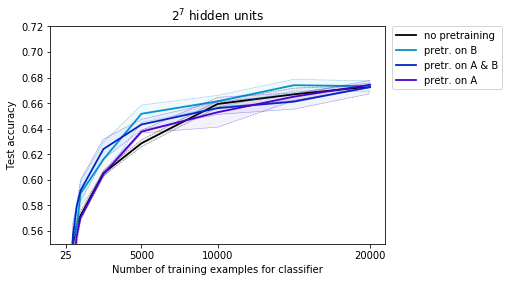

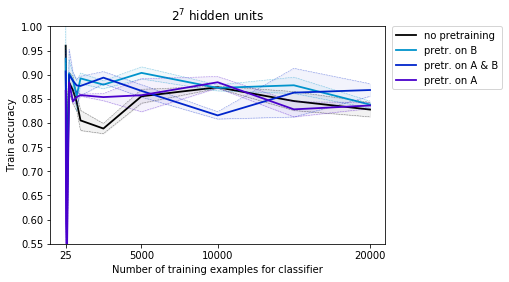

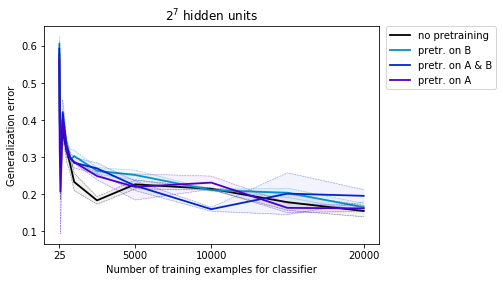

In [7]:
results_test = {}
results_train = {}
results_generr = {}
n_hus = [7, 9, 11, 13]
results_test[n_hus[0]], results_train[n_hus[0]], results_generr[n_hus[0]] = do_all_hl(n_hus[0])

#### Training for 512 hu
## No Pre-Training
25
## seed: 11
Validation accuracy before training:
Test set: Average loss: 1.6294, Accuracy: 983/5000 (20%)
[epoch 1] loss: 1.6398996
Test set: Average loss: 1.5957, Accuracy: 1164/5000 (23%)
[epoch 2] loss: 1.5007390
Test set: Average loss: 1.5690, Accuracy: 1347/5000 (27%)
[epoch 3] loss: 1.3751215
Test set: Average loss: 1.5485, Accuracy: 1482/5000 (30%)
[epoch 4] loss: 1.2643269
Test set: Average loss: 1.5329, Accuracy: 1553/5000 (31%)
[epoch 5] loss: 1.1675833
Test set: Average loss: 1.5208, Accuracy: 1600/5000 (32%)
[epoch 6] loss: 1.0831263
Test set: Average loss: 1.5114, Accuracy: 1636/5000 (33%)
[epoch 7] loss: 1.0089759
Test set: Average loss: 1.5038, Accuracy: 1680/5000 (34%)
[epoch 8] loss: 0.9433078
Test set: Average loss: 1.4974, Accuracy: 1714/5000 (34%)
[epoch 9] loss: 0.8846000
Test set: Average loss: 1.4919, Accuracy: 1747/5000 (35%)
[epoch 10] loss: 0.8316692
Test set: Average loss: 1.4870, Accuracy: 1775/5000 (36%)
[epoch

[epoch 11] loss: 0.7406251
Test set: Average loss: 1.4054, Accuracy: 1910/5000 (38%)
[epoch 12] loss: 0.7062769
Test set: Average loss: 1.4065, Accuracy: 1925/5000 (38%)
[epoch 13] loss: 0.6682979
Test set: Average loss: 1.4080, Accuracy: 1913/5000 (38%)
[epoch 14] loss: 0.6572289
Test set: Average loss: 1.4093, Accuracy: 1910/5000 (38%)
[epoch 15] loss: 0.6145761
Test set: Average loss: 1.4117, Accuracy: 1914/5000 (38%)
[epoch 16] loss: 0.5896147
Test set: Average loss: 1.4138, Accuracy: 1907/5000 (38%)
[epoch 17] loss: 0.5551677
Test set: Average loss: 1.4148, Accuracy: 1908/5000 (38%)
[epoch 18] loss: 0.5382254
Test set: Average loss: 1.4164, Accuracy: 1913/5000 (38%)
[epoch 19] loss: 0.5204682
Test set: Average loss: 1.4180, Accuracy: 1923/5000 (38%)
[epoch 20] loss: 0.5054998
Test set: Average loss: 1.4188, Accuracy: 1929/5000 (39%)
[epoch 21] loss: 0.5029185
Test set: Average loss: 1.4202, Accuracy: 1927/5000 (39%)
[epoch 22] loss: 0.4645511
Test set: Average loss: 1.4214, Accura

Test set: Average loss: 1.3936, Accuracy: 2015/5000 (40%)
[epoch 18] loss: 0.8838063
Epoch    17: reducing learning rate of group 0 to 5.0000e-13.
Test set: Average loss: 1.3936, Accuracy: 2015/5000 (40%)
[epoch 19] loss: 1.0079089
Epoch    18: reducing learning rate of group 0 to 5.0000e-14.
Test set: Average loss: 1.3936, Accuracy: 2015/5000 (40%)
[epoch 20] loss: 0.9404762
Epoch    19: reducing learning rate of group 0 to 5.0000e-15.
Test set: Average loss: 1.3936, Accuracy: 2015/5000 (40%)
[epoch 21] loss: 0.9242013
Epoch    20: reducing learning rate of group 0 to 5.0000e-16.
Test set: Average loss: 1.3936, Accuracy: 2015/5000 (40%)
[epoch 22] loss: 0.9557844
Epoch    21: reducing learning rate of group 0 to 5.0000e-17.
Test set: Average loss: 1.3936, Accuracy: 2015/5000 (40%)
[epoch 23] loss: 0.8734948
Epoch    22: reducing learning rate of group 0 to 5.0000e-18.
Test set: Average loss: 1.3936, Accuracy: 2015/5000 (40%)
[epoch 24] loss: 0.8799165
Epoch    23: reducing learning ra

Test set: Average loss: 1.6552, Accuracy: 825/5000 (16%)
[epoch 1] loss: 1.5585337
Test set: Average loss: 1.4273, Accuracy: 2060/5000 (41%)
[epoch 2] loss: 1.3271799
Test set: Average loss: 1.3566, Accuracy: 2261/5000 (45%)
[epoch 3] loss: 1.2275444
Test set: Average loss: 1.3202, Accuracy: 2345/5000 (47%)
[epoch 4] loss: 1.1439376
Test set: Average loss: 1.2951, Accuracy: 2461/5000 (49%)
[epoch 5] loss: 1.0877908
Test set: Average loss: 1.2820, Accuracy: 2543/5000 (51%)
[epoch 6] loss: 1.0355314
Test set: Average loss: 1.2717, Accuracy: 2542/5000 (51%)
[epoch 7] loss: 0.9927098
Test set: Average loss: 1.2673, Accuracy: 2552/5000 (51%)
[epoch 8] loss: 0.9554188
Test set: Average loss: 1.2616, Accuracy: 2578/5000 (52%)
[epoch 9] loss: 0.9180267
Test set: Average loss: 1.2539, Accuracy: 2591/5000 (52%)
[epoch 10] loss: 0.8905783
Test set: Average loss: 1.2493, Accuracy: 2617/5000 (52%)
[epoch 11] loss: 0.8569407
Test set: Average loss: 1.2480, Accuracy: 2612/5000 (52%)
[epoch 12] loss: 

[epoch 12] loss: 0.7848617
Test set: Average loss: 1.1943, Accuracy: 2680/5000 (54%)
[epoch 13] loss: 0.7592657
Test set: Average loss: 1.1918, Accuracy: 2671/5000 (53%)
[epoch 14] loss: 0.7317394
Test set: Average loss: 1.1905, Accuracy: 2683/5000 (54%)
[epoch 15] loss: 0.7099023
Test set: Average loss: 1.1883, Accuracy: 2691/5000 (54%)
[epoch 16] loss: 0.6888961
Test set: Average loss: 1.1919, Accuracy: 2680/5000 (54%)
[epoch 17] loss: 0.6671172
Test set: Average loss: 1.1902, Accuracy: 2678/5000 (54%)
[epoch 18] loss: 0.6447223
Test set: Average loss: 1.1887, Accuracy: 2665/5000 (53%)
[epoch 19] loss: 0.6226740
Test set: Average loss: 1.1952, Accuracy: 2663/5000 (53%)
[epoch 20] loss: 0.6052283
Test set: Average loss: 1.1888, Accuracy: 2694/5000 (54%)
[epoch 21] loss: 0.5839790
Test set: Average loss: 1.1921, Accuracy: 2668/5000 (53%)
[epoch 22] loss: 0.5638770
Test set: Average loss: 1.1931, Accuracy: 2668/5000 (53%)
[epoch 23] loss: 0.5461366
Test set: Average loss: 1.1948, Accura

Test set: Average loss: 1.1394, Accuracy: 2815/5000 (56%)
[epoch 24] loss: 0.4710492
Test set: Average loss: 1.1460, Accuracy: 2800/5000 (56%)
[epoch 25] loss: 0.4505106
Test set: Average loss: 1.1384, Accuracy: 2837/5000 (57%)
Validation:
Test set: Average loss: 1.1389, Accuracy: 2854/5000 (57%)
Test
Test set: Average loss: 1.1452, Accuracy: 2814/5000 (56%)
Test set: Average loss: 0.6808, Accuracy: 639/750 (85%)
## seed: 12
Validation accuracy before training:
Test set: Average loss: 1.6285, Accuracy: 741/5000 (15%)
[epoch 1] loss: 1.4342224
Test set: Average loss: 1.2866, Accuracy: 2501/5000 (50%)
[epoch 2] loss: 1.2151426
Test set: Average loss: 1.2293, Accuracy: 2677/5000 (54%)
[epoch 3] loss: 1.1293051
Test set: Average loss: 1.2010, Accuracy: 2810/5000 (56%)
[epoch 4] loss: 1.0716503
Test set: Average loss: 1.1805, Accuracy: 2846/5000 (57%)
[epoch 5] loss: 1.0319023
Test set: Average loss: 1.1718, Accuracy: 2847/5000 (57%)
[epoch 6] loss: 0.9795552
Test set: Average loss: 1.1641,

Test set: Average loss: 1.1362, Accuracy: 2943/5000 (59%)
[epoch 7] loss: 0.9224857
Test set: Average loss: 1.1291, Accuracy: 2930/5000 (59%)
[epoch 8] loss: 0.8757504
Test set: Average loss: 1.1183, Accuracy: 2977/5000 (60%)
[epoch 9] loss: 0.8550629
Test set: Average loss: 1.1179, Accuracy: 2953/5000 (59%)
[epoch 10] loss: 0.8143810
Test set: Average loss: 1.1135, Accuracy: 2976/5000 (60%)
[epoch 11] loss: 0.7848595
Test set: Average loss: 1.1065, Accuracy: 3004/5000 (60%)
[epoch 12] loss: 0.7522093
Test set: Average loss: 1.1083, Accuracy: 2963/5000 (59%)
[epoch 13] loss: 0.7202313
Test set: Average loss: 1.1139, Accuracy: 2945/5000 (59%)
[epoch 14] loss: 0.7040244
Test set: Average loss: 1.1028, Accuracy: 2972/5000 (59%)
[epoch 15] loss: 0.6713891
Test set: Average loss: 1.1014, Accuracy: 2989/5000 (60%)
[epoch 16] loss: 0.6443210
Test set: Average loss: 1.1041, Accuracy: 2946/5000 (59%)
[epoch 17] loss: 0.6236711
Test set: Average loss: 1.1001, Accuracy: 2979/5000 (60%)
[epoch 18]

[epoch 18] loss: 0.5329071
Test set: Average loss: 1.0405, Accuracy: 3061/5000 (61%)
[epoch 19] loss: 0.5056315
Test set: Average loss: 1.0258, Accuracy: 3102/5000 (62%)
[epoch 20] loss: 0.4735710
Test set: Average loss: 1.0282, Accuracy: 3084/5000 (62%)
[epoch 21] loss: 0.4440508
Test set: Average loss: 1.0295, Accuracy: 3094/5000 (62%)
[epoch 22] loss: 0.4204389
Test set: Average loss: 1.0349, Accuracy: 3086/5000 (62%)
[epoch 23] loss: 0.3941545
Test set: Average loss: 1.0308, Accuracy: 3066/5000 (61%)
[epoch 24] loss: 0.3687888
Test set: Average loss: 1.0410, Accuracy: 3077/5000 (62%)
[epoch 25] loss: 0.3383198
Test set: Average loss: 1.0364, Accuracy: 3073/5000 (61%)
Validation:
Test set: Average loss: 1.0258, Accuracy: 3102/5000 (62%)
Test
Test set: Average loss: 1.0377, Accuracy: 3050/5000 (61%)
Test set: Average loss: 0.4654, Accuracy: 2276/2500 (91%)
## seed: 13
Validation accuracy before training:
Test set: Average loss: 1.6359, Accuracy: 987/5000 (20%)
[epoch 1] loss: 1.30919

[epoch 1] loss: 1.2143201
Test set: Average loss: 1.1374, Accuracy: 2935/5000 (59%)
[epoch 2] loss: 1.0687563
Test set: Average loss: 1.0984, Accuracy: 3002/5000 (60%)
[epoch 3] loss: 1.0063546
Test set: Average loss: 1.0599, Accuracy: 3076/5000 (62%)
[epoch 4] loss: 0.9578787
Test set: Average loss: 1.0440, Accuracy: 3095/5000 (62%)
[epoch 5] loss: 0.9153543
Test set: Average loss: 1.0289, Accuracy: 3121/5000 (62%)
[epoch 6] loss: 0.8778119
Test set: Average loss: 1.0191, Accuracy: 3110/5000 (62%)
[epoch 7] loss: 0.8399297
Test set: Average loss: 1.0203, Accuracy: 3098/5000 (62%)
[epoch 8] loss: 0.8068947
Test set: Average loss: 1.0007, Accuracy: 3141/5000 (63%)
[epoch 9] loss: 0.7696304
Test set: Average loss: 0.9892, Accuracy: 3156/5000 (63%)
[epoch 10] loss: 0.7362091
Test set: Average loss: 0.9875, Accuracy: 3163/5000 (63%)
[epoch 11] loss: 0.6985057
Test set: Average loss: 0.9928, Accuracy: 3168/5000 (63%)
[epoch 12] loss: 0.6679305
Test set: Average loss: 0.9839, Accuracy: 3150/

Test set: Average loss: 0.9061, Accuracy: 3296/5000 (66%)
[epoch 13] loss: 0.5383463
Test set: Average loss: 0.8988, Accuracy: 3345/5000 (67%)
[epoch 14] loss: 0.4923629
Test set: Average loss: 0.9091, Accuracy: 3297/5000 (66%)
[epoch 15] loss: 0.4497622
Test set: Average loss: 0.8966, Accuracy: 3336/5000 (67%)
[epoch 16] loss: 0.4082034
Test set: Average loss: 0.8998, Accuracy: 3346/5000 (67%)
[epoch 17] loss: 0.3686552
Test set: Average loss: 0.9300, Accuracy: 3324/5000 (66%)
[epoch 18] loss: 0.3300712
Test set: Average loss: 0.9054, Accuracy: 3346/5000 (67%)
[epoch 19] loss: 0.2916347
Test set: Average loss: 0.9261, Accuracy: 3321/5000 (66%)
[epoch 20] loss: 0.2601875
Test set: Average loss: 0.9295, Accuracy: 3337/5000 (67%)
[epoch 21] loss: 0.2286902
Test set: Average loss: 0.9371, Accuracy: 3338/5000 (67%)
[epoch 22] loss: 0.1978396
Test set: Average loss: 0.9523, Accuracy: 3341/5000 (67%)
[epoch 23] loss: 0.1710817
Test set: Average loss: 0.9620, Accuracy: 3367/5000 (67%)
[epoch 

[epoch 24] loss: 0.1073714
Test set: Average loss: 0.9776, Accuracy: 3427/5000 (69%)
[epoch 25] loss: 0.0896816
Test set: Average loss: 0.9973, Accuracy: 3439/5000 (69%)
Validation:
Test set: Average loss: 0.8745, Accuracy: 3462/5000 (69%)
Test
Test set: Average loss: 0.9017, Accuracy: 3377/5000 (68%)
Test set: Average loss: 0.2665, Accuracy: 14184/15000 (95%)
20000
## seed: 11
Validation accuracy before training:
Test set: Average loss: 1.6163, Accuracy: 977/5000 (20%)
[epoch 1] loss: 1.1135340
Test set: Average loss: 1.0221, Accuracy: 3151/5000 (63%)
[epoch 2] loss: 0.9811583
Test set: Average loss: 0.9817, Accuracy: 3187/5000 (64%)
[epoch 3] loss: 0.9158864
Test set: Average loss: 0.9350, Accuracy: 3283/5000 (66%)
[epoch 4] loss: 0.8617010
Test set: Average loss: 0.9296, Accuracy: 3315/5000 (66%)
[epoch 5] loss: 0.8135324
Test set: Average loss: 0.8884, Accuracy: 3361/5000 (67%)
[epoch 6] loss: 0.7660055
Test set: Average loss: 0.8668, Accuracy: 3447/5000 (69%)
[epoch 7] loss: 0.719

[epoch 7] loss: 0.7283000
Test set: Average loss: 0.8609, Accuracy: 3403/5000 (68%)
[epoch 8] loss: 0.6822820
Test set: Average loss: 0.8523, Accuracy: 3442/5000 (69%)
[epoch 9] loss: 0.6342879
Test set: Average loss: 0.8391, Accuracy: 3470/5000 (69%)
[epoch 10] loss: 0.5877394
Test set: Average loss: 0.8361, Accuracy: 3474/5000 (69%)
[epoch 11] loss: 0.5377995
Test set: Average loss: 0.8287, Accuracy: 3507/5000 (70%)
[epoch 12] loss: 0.4916349
Test set: Average loss: 0.8364, Accuracy: 3486/5000 (70%)
[epoch 13] loss: 0.4439794
Test set: Average loss: 0.8378, Accuracy: 3486/5000 (70%)
[epoch 14] loss: 0.3994560
Test set: Average loss: 0.8435, Accuracy: 3484/5000 (70%)
[epoch 15] loss: 0.3556829
Test set: Average loss: 0.8754, Accuracy: 3418/5000 (68%)
[epoch 16] loss: 0.3150768
Test set: Average loss: 0.8733, Accuracy: 3446/5000 (69%)
[epoch 17] loss: 0.2737179
Test set: Average loss: 0.8832, Accuracy: 3437/5000 (69%)
[epoch 18] loss: 0.2375673
Test set: Average loss: 0.8907, Accuracy:

Test set: Average loss: 1.4775, Accuracy: 1764/5000 (35%)
[epoch 20] loss: 0.8492088
Test set: Average loss: 1.4735, Accuracy: 1779/5000 (36%)
[epoch 21] loss: 0.8288141
Test set: Average loss: 1.4697, Accuracy: 1800/5000 (36%)
[epoch 22] loss: 0.8094555
Test set: Average loss: 1.4660, Accuracy: 1841/5000 (37%)
[epoch 23] loss: 0.7910424
Test set: Average loss: 1.4626, Accuracy: 1864/5000 (37%)
[epoch 24] loss: 0.7735192
Test set: Average loss: 1.4592, Accuracy: 1874/5000 (37%)
[epoch 25] loss: 0.7568560
Test set: Average loss: 1.4560, Accuracy: 1886/5000 (38%)
Validation:
Test set: Average loss: 1.4560, Accuracy: 1886/5000 (38%)
Test
Test set: Average loss: 1.4546, Accuracy: 1934/5000 (39%)
Test set: Average loss: 0.7410, Accuracy: 25/25 (100%)
50
## seed: 11
Validation accuracy before training:
Test set: Average loss: 1.9658, Accuracy: 269/5000 (5%)
[epoch 1] loss: 2.0406172
Test set: Average loss: 1.9215, Accuracy: 295/5000 (6%)
[epoch 2] loss: 1.8942125
Test set: Average loss: 1.87

[epoch 24] loss: 0.6281813
Epoch    23: reducing learning rate of group 0 to 5.0000e-09.
Test set: Average loss: 1.2846, Accuracy: 2348/5000 (47%)
[epoch 25] loss: 0.6346996
Epoch    24: reducing learning rate of group 0 to 5.0000e-10.
Test set: Average loss: 1.2846, Accuracy: 2348/5000 (47%)
Validation:
Test set: Average loss: 1.2846, Accuracy: 2348/5000 (47%)
Test
Test set: Average loss: 1.2942, Accuracy: 2318/5000 (46%)
Test set: Average loss: 0.6325, Accuracy: 48/50 (96%)
100
## seed: 11
Validation accuracy before training:
Test set: Average loss: 1.7114, Accuracy: 801/5000 (16%)
[epoch 1] loss: 1.6149125
Test set: Average loss: 1.6598, Accuracy: 939/5000 (19%)
[epoch 2] loss: 1.4949951
Test set: Average loss: 1.6266, Accuracy: 1047/5000 (21%)
[epoch 3] loss: 1.4215720
Test set: Average loss: 1.5997, Accuracy: 1143/5000 (23%)
[epoch 4] loss: 1.3750212
Test set: Average loss: 1.5777, Accuracy: 1238/5000 (25%)
[epoch 5] loss: 1.2832509
Test set: Average loss: 1.5505, Accuracy: 1328/5

Test set: Average loss: 1.4515, Accuracy: 1667/5000 (33%)
[epoch 11] loss: 1.1730013
Epoch    10: reducing learning rate of group 0 to 5.0000e-09.
Test set: Average loss: 1.4515, Accuracy: 1667/5000 (33%)
[epoch 12] loss: 1.1353943
Test set: Average loss: 1.4515, Accuracy: 1667/5000 (33%)
[epoch 13] loss: 1.1492588
Epoch    12: reducing learning rate of group 0 to 5.0000e-10.
Test set: Average loss: 1.4515, Accuracy: 1667/5000 (33%)
[epoch 14] loss: 1.1567684
Epoch    13: reducing learning rate of group 0 to 5.0000e-11.
Test set: Average loss: 1.4515, Accuracy: 1667/5000 (33%)
[epoch 15] loss: 1.1438091
Epoch    14: reducing learning rate of group 0 to 5.0000e-12.
Test set: Average loss: 1.4515, Accuracy: 1667/5000 (33%)
[epoch 16] loss: 1.1956536
Epoch    15: reducing learning rate of group 0 to 5.0000e-13.
Test set: Average loss: 1.4515, Accuracy: 1667/5000 (33%)
[epoch 17] loss: 1.1468101
Epoch    16: reducing learning rate of group 0 to 5.0000e-14.
Test set: Average loss: 1.4515, A

[epoch 12] loss: 0.8589603
Test set: Average loss: 1.2671, Accuracy: 2702/5000 (54%)
[epoch 13] loss: 0.8309444
Test set: Average loss: 1.2587, Accuracy: 2711/5000 (54%)
[epoch 14] loss: 0.8054197
Test set: Average loss: 1.2522, Accuracy: 2716/5000 (54%)
[epoch 15] loss: 0.7801440
Test set: Average loss: 1.2457, Accuracy: 2737/5000 (55%)
[epoch 16] loss: 0.7590863
Test set: Average loss: 1.2408, Accuracy: 2743/5000 (55%)
[epoch 17] loss: 0.7351832
Test set: Average loss: 1.2358, Accuracy: 2754/5000 (55%)
[epoch 18] loss: 0.7165646
Test set: Average loss: 1.2315, Accuracy: 2751/5000 (55%)
[epoch 19] loss: 0.6955111
Test set: Average loss: 1.2274, Accuracy: 2761/5000 (55%)
[epoch 20] loss: 0.6767881
Test set: Average loss: 1.2241, Accuracy: 2757/5000 (55%)
[epoch 21] loss: 0.6605681
Test set: Average loss: 1.2206, Accuracy: 2765/5000 (55%)
[epoch 22] loss: 0.6416737
Test set: Average loss: 1.2182, Accuracy: 2775/5000 (56%)
[epoch 23] loss: 0.6273796
Test set: Average loss: 1.2153, Accura

Test set: Average loss: 1.1367, Accuracy: 2905/5000 (58%)
[epoch 24] loss: 0.5447783
Test set: Average loss: 1.1346, Accuracy: 2917/5000 (58%)
[epoch 25] loss: 0.5240393
Test set: Average loss: 1.1307, Accuracy: 2918/5000 (58%)
Validation:
Test set: Average loss: 1.1307, Accuracy: 2918/5000 (58%)
Test
Test set: Average loss: 1.1488, Accuracy: 2865/5000 (57%)
Test set: Average loss: 0.5129, Accuracy: 479/500 (96%)
750
## seed: 11
Validation accuracy before training:
Test set: Average loss: 1.7483, Accuracy: 862/5000 (17%)
[epoch 1] loss: 1.6342335
Test set: Average loss: 1.4990, Accuracy: 1678/5000 (34%)
[epoch 2] loss: 1.3845012
Test set: Average loss: 1.4031, Accuracy: 2156/5000 (43%)
[epoch 3] loss: 1.2574975
Test set: Average loss: 1.3477, Accuracy: 2308/5000 (46%)
[epoch 4] loss: 1.1693714
Test set: Average loss: 1.3091, Accuracy: 2512/5000 (50%)
[epoch 5] loss: 1.1022116
Test set: Average loss: 1.2874, Accuracy: 2557/5000 (51%)
[epoch 6] loss: 1.0480414
Test set: Average loss: 1.2

Test set: Average loss: 1.1402, Accuracy: 2903/5000 (58%)
[epoch 7] loss: 0.8786260
Test set: Average loss: 1.1246, Accuracy: 2934/5000 (59%)
[epoch 8] loss: 0.8383145
Test set: Average loss: 1.1112, Accuracy: 2967/5000 (59%)
[epoch 9] loss: 0.7987665
Test set: Average loss: 1.1020, Accuracy: 3001/5000 (60%)
[epoch 10] loss: 0.7679619
Test set: Average loss: 1.0964, Accuracy: 3003/5000 (60%)
[epoch 11] loss: 0.7352540
Test set: Average loss: 1.0867, Accuracy: 3016/5000 (60%)
[epoch 12] loss: 0.7121913
Test set: Average loss: 1.0785, Accuracy: 3025/5000 (60%)
[epoch 13] loss: 0.6790481
Test set: Average loss: 1.0716, Accuracy: 3040/5000 (61%)
[epoch 14] loss: 0.6460941
Test set: Average loss: 1.0671, Accuracy: 3051/5000 (61%)
[epoch 15] loss: 0.6171229
Test set: Average loss: 1.0657, Accuracy: 3055/5000 (61%)
[epoch 16] loss: 0.5913666
Test set: Average loss: 1.0599, Accuracy: 3058/5000 (61%)
[epoch 17] loss: 0.5717444
Test set: Average loss: 1.0538, Accuracy: 3073/5000 (61%)
[epoch 18]

[epoch 18] loss: 0.4709424
Test set: Average loss: 0.9883, Accuracy: 3194/5000 (64%)
[epoch 19] loss: 0.4431301
Test set: Average loss: 0.9891, Accuracy: 3156/5000 (63%)
[epoch 20] loss: 0.4152859
Test set: Average loss: 0.9933, Accuracy: 3155/5000 (63%)
[epoch 21] loss: 0.3879083
Test set: Average loss: 0.9845, Accuracy: 3172/5000 (63%)
[epoch 22] loss: 0.3600258
Test set: Average loss: 0.9932, Accuracy: 3136/5000 (63%)
[epoch 23] loss: 0.3373459
Test set: Average loss: 0.9947, Accuracy: 3134/5000 (63%)
[epoch 24] loss: 0.3137846
Test set: Average loss: 0.9848, Accuracy: 3168/5000 (63%)
[epoch 25] loss: 0.2923441
Test set: Average loss: 0.9863, Accuracy: 3179/5000 (64%)
Validation:
Test set: Average loss: 0.9883, Accuracy: 3194/5000 (64%)
Test
Test set: Average loss: 0.9993, Accuracy: 3129/5000 (63%)
Test set: Average loss: 0.4404, Accuracy: 2334/2500 (93%)
## seed: 12
Validation accuracy before training:
Test set: Average loss: 1.3516, Accuracy: 2178/5000 (44%)
[epoch 1] loss: 1.1348

[epoch 1] loss: 1.3424702
Test set: Average loss: 1.1878, Accuracy: 2748/5000 (55%)
[epoch 2] loss: 1.0912323
Test set: Average loss: 1.1015, Accuracy: 3027/5000 (61%)
[epoch 3] loss: 0.9921038
Test set: Average loss: 1.0520, Accuracy: 3152/5000 (63%)
[epoch 4] loss: 0.9213223
Test set: Average loss: 1.0200, Accuracy: 3231/5000 (65%)
[epoch 5] loss: 0.8588387
Test set: Average loss: 0.9913, Accuracy: 3268/5000 (65%)
[epoch 6] loss: 0.8035641
Test set: Average loss: 0.9714, Accuracy: 3311/5000 (66%)
[epoch 7] loss: 0.7523198
Test set: Average loss: 0.9534, Accuracy: 3338/5000 (67%)
[epoch 8] loss: 0.7048580
Test set: Average loss: 0.9431, Accuracy: 3349/5000 (67%)
[epoch 9] loss: 0.6544483
Test set: Average loss: 0.9245, Accuracy: 3376/5000 (68%)
[epoch 10] loss: 0.6133572
Test set: Average loss: 0.9172, Accuracy: 3365/5000 (67%)
[epoch 11] loss: 0.5688528
Test set: Average loss: 0.9095, Accuracy: 3373/5000 (67%)
[epoch 12] loss: 0.5285335
Test set: Average loss: 0.9021, Accuracy: 3389/

Test set: Average loss: 0.8507, Accuracy: 3434/5000 (69%)
[epoch 13] loss: 0.3335276
Test set: Average loss: 0.8534, Accuracy: 3451/5000 (69%)
[epoch 14] loss: 0.2956874
Test set: Average loss: 0.8575, Accuracy: 3425/5000 (68%)
[epoch 15] loss: 0.2576521
Test set: Average loss: 0.8662, Accuracy: 3447/5000 (69%)
[epoch 16] loss: 0.2234859
Test set: Average loss: 0.8800, Accuracy: 3393/5000 (68%)
[epoch 17] loss: 0.1940596
Test set: Average loss: 0.8754, Accuracy: 3427/5000 (69%)
[epoch 18] loss: 0.1692153
Test set: Average loss: 0.8935, Accuracy: 3387/5000 (68%)
[epoch 19] loss: 0.1431284
Test set: Average loss: 0.9157, Accuracy: 3365/5000 (67%)
[epoch 20] loss: 0.1217729
Test set: Average loss: 0.9273, Accuracy: 3364/5000 (67%)
[epoch 21] loss: 0.1034328
Test set: Average loss: 0.9292, Accuracy: 3386/5000 (68%)
[epoch 22] loss: 0.0869161
Test set: Average loss: 0.9564, Accuracy: 3367/5000 (67%)
[epoch 23] loss: 0.0720523
Test set: Average loss: 0.9496, Accuracy: 3400/5000 (68%)
[epoch 

[epoch 23] loss: 0.0431055
Test set: Average loss: 1.0893, Accuracy: 3366/5000 (67%)
[epoch 24] loss: 0.0325237
Test set: Average loss: 1.1382, Accuracy: 3347/5000 (67%)
[epoch 25] loss: 0.0279987
Test set: Average loss: 1.1535, Accuracy: 3338/5000 (67%)
Validation:
Test set: Average loss: 0.8554, Accuracy: 3491/5000 (70%)
Test
Test set: Average loss: 0.8720, Accuracy: 3421/5000 (68%)
Test set: Average loss: 0.3366, Accuracy: 13870/15000 (92%)
## seed: 13
Validation accuracy before training:
Test set: Average loss: 1.5877, Accuracy: 916/5000 (18%)
[epoch 1] loss: 1.0839235
Test set: Average loss: 1.0122, Accuracy: 3222/5000 (64%)
[epoch 2] loss: 0.8755581
Test set: Average loss: 0.9421, Accuracy: 3347/5000 (67%)
[epoch 3] loss: 0.7707074
Test set: Average loss: 0.9050, Accuracy: 3391/5000 (68%)
[epoch 4] loss: 0.6860901
Test set: Average loss: 0.8647, Accuracy: 3455/5000 (69%)
[epoch 5] loss: 0.6108841
Test set: Average loss: 0.8531, Accuracy: 3455/5000 (69%)
[epoch 6] loss: 0.5455932


Test set: Average loss: 0.8512, Accuracy: 3475/5000 (70%)
[epoch 5] loss: 0.5602923
Test set: Average loss: 0.8467, Accuracy: 3469/5000 (69%)
[epoch 6] loss: 0.4898171
Test set: Average loss: 0.8385, Accuracy: 3488/5000 (70%)
[epoch 7] loss: 0.4310083
Test set: Average loss: 0.8445, Accuracy: 3467/5000 (69%)
[epoch 8] loss: 0.3749048
Test set: Average loss: 0.8644, Accuracy: 3445/5000 (69%)
[epoch 9] loss: 0.3239868
Test set: Average loss: 0.8490, Accuracy: 3508/5000 (70%)
[epoch 10] loss: 0.2813687
Test set: Average loss: 0.8702, Accuracy: 3451/5000 (69%)
[epoch 11] loss: 0.2408574
Test set: Average loss: 0.8970, Accuracy: 3466/5000 (69%)
[epoch 12] loss: 0.2042341
Test set: Average loss: 0.9061, Accuracy: 3440/5000 (69%)
[epoch 13] loss: 0.1722292
Test set: Average loss: 0.9149, Accuracy: 3465/5000 (69%)
[epoch 14] loss: 0.1431512
Test set: Average loss: 0.9453, Accuracy: 3423/5000 (68%)
[epoch 15] loss: 0.1199982
Test set: Average loss: 0.9720, Accuracy: 3439/5000 (69%)
[epoch 16] l

[epoch 16] loss: 0.8917971
Test set: Average loss: 1.5309, Accuracy: 1645/5000 (33%)
[epoch 17] loss: 0.8692968
Test set: Average loss: 1.5271, Accuracy: 1651/5000 (33%)
[epoch 18] loss: 0.8483834
Test set: Average loss: 1.5235, Accuracy: 1666/5000 (33%)
[epoch 19] loss: 0.8288475
Test set: Average loss: 1.5203, Accuracy: 1676/5000 (34%)
[epoch 20] loss: 0.8105078
Test set: Average loss: 1.5172, Accuracy: 1706/5000 (34%)
[epoch 21] loss: 0.7932091
Test set: Average loss: 1.5144, Accuracy: 1733/5000 (35%)
[epoch 22] loss: 0.7768182
Test set: Average loss: 1.5118, Accuracy: 1745/5000 (35%)
[epoch 23] loss: 0.7612236
Test set: Average loss: 1.5093, Accuracy: 1761/5000 (35%)
[epoch 24] loss: 0.7463349
Test set: Average loss: 1.5070, Accuracy: 1775/5000 (36%)
[epoch 25] loss: 0.7320817
Test set: Average loss: 1.5049, Accuracy: 1782/5000 (36%)
Validation:
Test set: Average loss: 1.5049, Accuracy: 1782/5000 (36%)
Test
Test set: Average loss: 1.5053, Accuracy: 1794/5000 (36%)
Test set: Average

Test set: Average loss: 1.4468, Accuracy: 2002/5000 (40%)
Validation:
Test set: Average loss: 1.4472, Accuracy: 2007/5000 (40%)
Test
Test set: Average loss: 1.4637, Accuracy: 1997/5000 (40%)
Test set: Average loss: 0.6401, Accuracy: 50/50 (100%)
## seed: 13
Validation accuracy before training:
Test set: Average loss: 1.7212, Accuracy: 656/5000 (13%)
[epoch 1] loss: 1.6952681
Test set: Average loss: 1.6863, Accuracy: 775/5000 (16%)
[epoch 2] loss: 1.5463943
Test set: Average loss: 1.6541, Accuracy: 943/5000 (19%)
[epoch 3] loss: 1.4611318
Test set: Average loss: 1.6267, Accuracy: 1093/5000 (22%)
[epoch 4] loss: 1.3960850
Test set: Average loss: 1.6028, Accuracy: 1209/5000 (24%)
[epoch 5] loss: 1.2943298
Test set: Average loss: 1.5826, Accuracy: 1345/5000 (27%)
[epoch 6] loss: 1.2505068
Test set: Average loss: 1.5656, Accuracy: 1452/5000 (29%)
[epoch 7] loss: 1.1716725
Test set: Average loss: 1.5507, Accuracy: 1522/5000 (30%)
[epoch 8] loss: 1.0994628
Test set: Average loss: 1.5370, Accu

Test set: Average loss: 1.4469, Accuracy: 1923/5000 (38%)
[epoch 23] loss: 0.9274793
Epoch    22: reducing learning rate of group 0 to 5.0000e-14.
Test set: Average loss: 1.4469, Accuracy: 1923/5000 (38%)
[epoch 24] loss: 0.9028692
Epoch    23: reducing learning rate of group 0 to 5.0000e-15.
Test set: Average loss: 1.4469, Accuracy: 1923/5000 (38%)
[epoch 25] loss: 0.9163559
Epoch    24: reducing learning rate of group 0 to 5.0000e-16.
Test set: Average loss: 1.4469, Accuracy: 1923/5000 (38%)
Validation:
Test set: Average loss: 1.4469, Accuracy: 1923/5000 (38%)
Test
Test set: Average loss: 1.4399, Accuracy: 1948/5000 (39%)
Test set: Average loss: 0.9304, Accuracy: 84/100 (84%)
## seed: 13
Validation accuracy before training:
Test set: Average loss: 1.6353, Accuracy: 1091/5000 (22%)
[epoch 1] loss: 1.6484062
Test set: Average loss: 1.5712, Accuracy: 1418/5000 (28%)
[epoch 2] loss: 1.4956146
Test set: Average loss: 1.5311, Accuracy: 1645/5000 (33%)
[epoch 3] loss: 1.3913726
Test set: Av

[epoch 20] loss: 0.7185044
Test set: Average loss: 1.2496, Accuracy: 2510/5000 (50%)
[epoch 21] loss: 0.6983798
Test set: Average loss: 1.2468, Accuracy: 2529/5000 (51%)
[epoch 22] loss: 0.6801763
Test set: Average loss: 1.2461, Accuracy: 2516/5000 (50%)
[epoch 23] loss: 0.6632213
Test set: Average loss: 1.2440, Accuracy: 2510/5000 (50%)
[epoch 24] loss: 0.6438867
Test set: Average loss: 1.2409, Accuracy: 2526/5000 (51%)
[epoch 25] loss: 0.6300513
Test set: Average loss: 1.2377, Accuracy: 2531/5000 (51%)
Validation:
Test set: Average loss: 1.2377, Accuracy: 2531/5000 (51%)
Test
Test set: Average loss: 1.2364, Accuracy: 2545/5000 (51%)
Test set: Average loss: 0.6171, Accuracy: 238/250 (95%)
## seed: 13
Validation accuracy before training:
Test set: Average loss: 1.6149, Accuracy: 916/5000 (18%)
[epoch 1] loss: 1.5597206
Test set: Average loss: 1.5103, Accuracy: 1519/5000 (30%)
[epoch 2] loss: 1.4030389
Test set: Average loss: 1.4373, Accuracy: 1910/5000 (38%)
[epoch 3] loss: 1.3021143
T

[epoch 3] loss: 1.1711689
Test set: Average loss: 1.2908, Accuracy: 2469/5000 (49%)
[epoch 4] loss: 1.0894487
Test set: Average loss: 1.2630, Accuracy: 2555/5000 (51%)
[epoch 5] loss: 1.0340850
Test set: Average loss: 1.2467, Accuracy: 2592/5000 (52%)
[epoch 6] loss: 0.9751866
Test set: Average loss: 1.2315, Accuracy: 2644/5000 (53%)
[epoch 7] loss: 0.9277377
Test set: Average loss: 1.2209, Accuracy: 2666/5000 (53%)
[epoch 8] loss: 0.8869215
Test set: Average loss: 1.2155, Accuracy: 2696/5000 (54%)
[epoch 9] loss: 0.8499384
Test set: Average loss: 1.2031, Accuracy: 2730/5000 (55%)
[epoch 10] loss: 0.8174666
Test set: Average loss: 1.2004, Accuracy: 2720/5000 (54%)
[epoch 11] loss: 0.7828805
Test set: Average loss: 1.1909, Accuracy: 2745/5000 (55%)
[epoch 12] loss: 0.7575865
Test set: Average loss: 1.1889, Accuracy: 2746/5000 (55%)
[epoch 13] loss: 0.7296815
Test set: Average loss: 1.1872, Accuracy: 2761/5000 (55%)
[epoch 14] loss: 0.7046530
Test set: Average loss: 1.1800, Accuracy: 277

[epoch 15] loss: 0.6828557
Test set: Average loss: 1.1454, Accuracy: 2801/5000 (56%)
[epoch 16] loss: 0.6544407
Test set: Average loss: 1.1392, Accuracy: 2823/5000 (56%)
[epoch 17] loss: 0.6298414
Test set: Average loss: 1.1415, Accuracy: 2792/5000 (56%)
[epoch 18] loss: 0.6084920
Test set: Average loss: 1.1340, Accuracy: 2831/5000 (57%)
[epoch 19] loss: 0.5805526
Test set: Average loss: 1.1319, Accuracy: 2803/5000 (56%)
[epoch 20] loss: 0.5586038
Test set: Average loss: 1.1277, Accuracy: 2842/5000 (57%)
[epoch 21] loss: 0.5348638
Test set: Average loss: 1.1270, Accuracy: 2838/5000 (57%)
[epoch 22] loss: 0.5155401
Test set: Average loss: 1.1272, Accuracy: 2830/5000 (57%)
[epoch 23] loss: 0.4955823
Test set: Average loss: 1.1223, Accuracy: 2843/5000 (57%)
[epoch 24] loss: 0.4780354
Test set: Average loss: 1.1216, Accuracy: 2833/5000 (57%)
[epoch 25] loss: 0.4571276
Test set: Average loss: 1.1209, Accuracy: 2826/5000 (57%)
Validation:
Test set: Average loss: 1.1223, Accuracy: 2843/5000 (

Test set: Average loss: 1.0864, Accuracy: 2943/5000 (59%)
Test set: Average loss: 0.4667, Accuracy: 967/1000 (97%)
2500
## seed: 11
Validation accuracy before training:
Test set: Average loss: 1.6344, Accuracy: 1038/5000 (21%)
[epoch 1] loss: 1.3391425
Test set: Average loss: 1.2403, Accuracy: 2560/5000 (51%)
[epoch 2] loss: 1.1540035
Test set: Average loss: 1.1725, Accuracy: 2761/5000 (55%)
[epoch 3] loss: 1.0816582
Test set: Average loss: 1.1371, Accuracy: 2862/5000 (57%)
[epoch 4] loss: 1.0112270
Test set: Average loss: 1.1133, Accuracy: 2910/5000 (58%)
[epoch 5] loss: 0.9617412
Test set: Average loss: 1.0928, Accuracy: 2979/5000 (60%)
[epoch 6] loss: 0.9218282
Test set: Average loss: 1.0783, Accuracy: 2996/5000 (60%)
[epoch 7] loss: 0.8744211
Test set: Average loss: 1.0641, Accuracy: 3037/5000 (61%)
[epoch 8] loss: 0.8315954
Test set: Average loss: 1.0547, Accuracy: 3060/5000 (61%)
[epoch 9] loss: 0.8020920
Test set: Average loss: 1.0421, Accuracy: 3076/5000 (62%)
[epoch 10] loss: 

[epoch 10] loss: 0.6876398
Test set: Average loss: 0.9723, Accuracy: 3223/5000 (64%)
[epoch 11] loss: 0.6416131
Test set: Average loss: 0.9690, Accuracy: 3211/5000 (64%)
[epoch 12] loss: 0.5980249
Test set: Average loss: 0.9634, Accuracy: 3225/5000 (64%)
[epoch 13] loss: 0.5562221
Test set: Average loss: 0.9584, Accuracy: 3240/5000 (65%)
[epoch 14] loss: 0.5141347
Test set: Average loss: 0.9538, Accuracy: 3235/5000 (65%)
[epoch 15] loss: 0.4753566
Test set: Average loss: 0.9509, Accuracy: 3255/5000 (65%)
[epoch 16] loss: 0.4356099
Test set: Average loss: 0.9558, Accuracy: 3238/5000 (65%)
[epoch 17] loss: 0.3978878
Test set: Average loss: 0.9466, Accuracy: 3238/5000 (65%)
[epoch 18] loss: 0.3614628
Test set: Average loss: 0.9506, Accuracy: 3239/5000 (65%)
[epoch 19] loss: 0.3279545
Test set: Average loss: 0.9534, Accuracy: 3227/5000 (65%)
[epoch 20] loss: 0.2948364
Test set: Average loss: 0.9539, Accuracy: 3262/5000 (65%)
[epoch 21] loss: 0.2651767
Test set: Average loss: 0.9637, Accura

Test set: Average loss: 0.9737, Accuracy: 3338/5000 (67%)
[epoch 22] loss: 0.1167051
Test set: Average loss: 0.9897, Accuracy: 3337/5000 (67%)
[epoch 23] loss: 0.0992108
Test set: Average loss: 0.9970, Accuracy: 3332/5000 (67%)
[epoch 24] loss: 0.0833981
Test set: Average loss: 1.0218, Accuracy: 3303/5000 (66%)
[epoch 25] loss: 0.0694087
Test set: Average loss: 1.0309, Accuracy: 3317/5000 (66%)
Validation:
Test set: Average loss: 0.8985, Accuracy: 3354/5000 (67%)
Test
Test set: Average loss: 0.9074, Accuracy: 3309/5000 (66%)
Test set: Average loss: 0.3505, Accuracy: 9242/10000 (92%)
## seed: 12
Validation accuracy before training:
Test set: Average loss: 1.6384, Accuracy: 1297/5000 (26%)
[epoch 1] loss: 1.2558967
Test set: Average loss: 1.1345, Accuracy: 3004/5000 (60%)
[epoch 2] loss: 1.0714161
Test set: Average loss: 1.0629, Accuracy: 3155/5000 (63%)
[epoch 3] loss: 0.9828069
Test set: Average loss: 1.0231, Accuracy: 3189/5000 (64%)
[epoch 4] loss: 0.9127884
Test set: Average loss: 0

[epoch 4] loss: 0.8539542
Test set: Average loss: 0.9242, Accuracy: 3305/5000 (66%)
[epoch 5] loss: 0.7911439
Test set: Average loss: 0.8998, Accuracy: 3346/5000 (67%)
[epoch 6] loss: 0.7335148
Test set: Average loss: 0.8812, Accuracy: 3363/5000 (67%)
[epoch 7] loss: 0.6793267
Test set: Average loss: 0.8623, Accuracy: 3400/5000 (68%)
[epoch 8] loss: 0.6234884
Test set: Average loss: 0.8718, Accuracy: 3383/5000 (68%)
[epoch 9] loss: 0.5710860
Test set: Average loss: 0.8442, Accuracy: 3428/5000 (69%)
[epoch 10] loss: 0.5204472
Test set: Average loss: 0.8399, Accuracy: 3473/5000 (69%)
[epoch 11] loss: 0.4700581
Test set: Average loss: 0.8431, Accuracy: 3453/5000 (69%)
[epoch 12] loss: 0.4188071
Test set: Average loss: 0.8468, Accuracy: 3461/5000 (69%)
[epoch 13] loss: 0.3754907
Test set: Average loss: 0.8469, Accuracy: 3454/5000 (69%)
[epoch 14] loss: 0.3282696
Test set: Average loss: 0.8600, Accuracy: 3435/5000 (69%)
[epoch 15] loss: 0.2890311
Test set: Average loss: 0.8574, Accuracy: 34

Test set: Average loss: 0.8956, Accuracy: 3460/5000 (69%)
[epoch 16] loss: 0.2112212
Test set: Average loss: 0.9197, Accuracy: 3419/5000 (68%)
[epoch 17] loss: 0.1776427
Test set: Average loss: 0.9376, Accuracy: 3439/5000 (69%)
[epoch 18] loss: 0.1506243
Test set: Average loss: 0.9542, Accuracy: 3461/5000 (69%)
[epoch 19] loss: 0.1253079
Test set: Average loss: 0.9865, Accuracy: 3428/5000 (69%)
[epoch 20] loss: 0.1053422
Test set: Average loss: 1.0118, Accuracy: 3432/5000 (69%)
[epoch 21] loss: 0.0879590
Test set: Average loss: 1.0346, Accuracy: 3439/5000 (69%)
[epoch 22] loss: 0.0729911
Test set: Average loss: 1.0629, Accuracy: 3421/5000 (68%)
[epoch 23] loss: 0.0597546
Test set: Average loss: 1.0823, Accuracy: 3453/5000 (69%)
[epoch 24] loss: 0.0493321
Test set: Average loss: 1.1106, Accuracy: 3414/5000 (68%)
[epoch 25] loss: 0.0451813
Test set: Average loss: 1.1808, Accuracy: 3360/5000 (67%)
Validation:
Test set: Average loss: 0.8494, Accuracy: 3514/5000 (70%)
Test
Test set: Average

Test set: Average loss: 0.7399, Accuracy: 24/25 (96%)
## seed: 12
Validation accuracy before training:
Test set: Average loss: 1.6645, Accuracy: 834/5000 (17%)
[epoch 1] loss: 1.6694837
Test set: Average loss: 1.6459, Accuracy: 923/5000 (18%)
[epoch 2] loss: 1.5720201
Test set: Average loss: 1.6288, Accuracy: 994/5000 (20%)
[epoch 3] loss: 1.4800817
Test set: Average loss: 1.6132, Accuracy: 1100/5000 (22%)
[epoch 4] loss: 1.3950728
Test set: Average loss: 1.5991, Accuracy: 1171/5000 (23%)
[epoch 5] loss: 1.3177341
Test set: Average loss: 1.5863, Accuracy: 1248/5000 (25%)
[epoch 6] loss: 1.2481656
Test set: Average loss: 1.5747, Accuracy: 1339/5000 (27%)
[epoch 7] loss: 1.1859704
Test set: Average loss: 1.5641, Accuracy: 1410/5000 (28%)
[epoch 8] loss: 1.1304225
Test set: Average loss: 1.5544, Accuracy: 1469/5000 (29%)
[epoch 9] loss: 1.0806304
Test set: Average loss: 1.5455, Accuracy: 1529/5000 (31%)
[epoch 10] loss: 1.0356836
Test set: Average loss: 1.5372, Accuracy: 1577/5000 (32%)
[

[epoch 3] loss: 1.4421901
Test set: Average loss: 1.6108, Accuracy: 1454/5000 (29%)
[epoch 4] loss: 1.3161882
Test set: Average loss: 1.5916, Accuracy: 1600/5000 (32%)
[epoch 5] loss: 1.2706923
Test set: Average loss: 1.5751, Accuracy: 1699/5000 (34%)
[epoch 6] loss: 1.2015207
Test set: Average loss: 1.5612, Accuracy: 1796/5000 (36%)
[epoch 7] loss: 1.1590898
Test set: Average loss: 1.5482, Accuracy: 1865/5000 (37%)
[epoch 8] loss: 1.1235198
Test set: Average loss: 1.5368, Accuracy: 1911/5000 (38%)
[epoch 9] loss: 1.0441781
Test set: Average loss: 1.5268, Accuracy: 1937/5000 (39%)
[epoch 10] loss: 0.9941010
Test set: Average loss: 1.5182, Accuracy: 1967/5000 (39%)
[epoch 11] loss: 0.9802066
Test set: Average loss: 1.5103, Accuracy: 1993/5000 (40%)
[epoch 12] loss: 0.9263058
Test set: Average loss: 1.5036, Accuracy: 2018/5000 (40%)
[epoch 13] loss: 0.9029863
Test set: Average loss: 1.4973, Accuracy: 2037/5000 (41%)
[epoch 14] loss: 0.8779385
Test set: Average loss: 1.4916, Accuracy: 204

Test set: Average loss: 1.5068, Accuracy: 1733/5000 (35%)
Validation:
Test set: Average loss: 1.5068, Accuracy: 1733/5000 (35%)
Test
Test set: Average loss: 1.5113, Accuracy: 1676/5000 (34%)
Test set: Average loss: 1.1852, Accuracy: 64/100 (64%)
## seed: 12
Validation accuracy before training:
Test set: Average loss: 1.8110, Accuracy: 592/5000 (12%)
[epoch 1] loss: 1.8394021
Test set: Average loss: 1.7417, Accuracy: 729/5000 (15%)
[epoch 2] loss: 1.6446703
Test set: Average loss: 1.6859, Accuracy: 962/5000 (19%)
[epoch 3] loss: 1.5164261
Test set: Average loss: 1.6424, Accuracy: 1157/5000 (23%)
[epoch 4] loss: 1.4033132
Test set: Average loss: 1.6030, Accuracy: 1325/5000 (26%)
[epoch 5] loss: 1.2754205
Test set: Average loss: 1.5709, Accuracy: 1460/5000 (29%)
[epoch 6] loss: 1.2985376
Epoch     5: reducing learning rate of group 0 to 5.0000e-06.
Test set: Average loss: 1.5489, Accuracy: 1571/5000 (31%)
[epoch 7] loss: 1.2291768
Test set: Average loss: 1.5470, Accuracy: 1571/5000 (31%)


[epoch 18] loss: 0.6931886
Test set: Average loss: 1.2321, Accuracy: 2724/5000 (54%)
[epoch 19] loss: 0.6701476
Test set: Average loss: 1.2285, Accuracy: 2740/5000 (55%)
[epoch 20] loss: 0.6503757
Test set: Average loss: 1.2248, Accuracy: 2753/5000 (55%)
[epoch 21] loss: 0.6319599
Test set: Average loss: 1.2233, Accuracy: 2743/5000 (55%)
[epoch 22] loss: 0.6159949
Test set: Average loss: 1.2226, Accuracy: 2738/5000 (55%)
[epoch 23] loss: 0.5981089
Test set: Average loss: 1.2179, Accuracy: 2748/5000 (55%)
[epoch 24] loss: 0.5828701
Test set: Average loss: 1.2157, Accuracy: 2757/5000 (55%)
[epoch 25] loss: 0.5686970
Test set: Average loss: 1.2149, Accuracy: 2746/5000 (55%)
Validation:
Test set: Average loss: 1.2157, Accuracy: 2757/5000 (55%)
Test
Test set: Average loss: 1.2214, Accuracy: 2710/5000 (54%)
Test set: Average loss: 0.5721, Accuracy: 241/250 (96%)
## seed: 12
Validation accuracy before training:
Test set: Average loss: 1.6429, Accuracy: 1085/5000 (22%)
[epoch 1] loss: 1.637277

[epoch 1] loss: 1.6334470
Test set: Average loss: 1.5459, Accuracy: 1535/5000 (31%)
[epoch 2] loss: 1.4334949
Test set: Average loss: 1.4456, Accuracy: 1975/5000 (40%)
[epoch 3] loss: 1.2939105
Test set: Average loss: 1.3801, Accuracy: 2222/5000 (44%)
[epoch 4] loss: 1.1965493
Test set: Average loss: 1.3404, Accuracy: 2367/5000 (47%)
[epoch 5] loss: 1.1239965
Test set: Average loss: 1.3102, Accuracy: 2474/5000 (49%)
[epoch 6] loss: 1.0634008
Test set: Average loss: 1.2886, Accuracy: 2541/5000 (51%)
[epoch 7] loss: 1.0110994
Test set: Average loss: 1.2736, Accuracy: 2565/5000 (51%)
[epoch 8] loss: 0.9652888
Test set: Average loss: 1.2588, Accuracy: 2613/5000 (52%)
[epoch 9] loss: 0.9241546
Test set: Average loss: 1.2480, Accuracy: 2644/5000 (53%)
[epoch 10] loss: 0.8848453
Test set: Average loss: 1.2370, Accuracy: 2685/5000 (54%)
[epoch 11] loss: 0.8523882
Test set: Average loss: 1.2291, Accuracy: 2708/5000 (54%)
[epoch 12] loss: 0.8212899
Test set: Average loss: 1.2181, Accuracy: 2746/

[epoch 13] loss: 0.7710310
Test set: Average loss: 1.1395, Accuracy: 2874/5000 (57%)
[epoch 14] loss: 0.7420855
Test set: Average loss: 1.1327, Accuracy: 2900/5000 (58%)
[epoch 15] loss: 0.7165253
Test set: Average loss: 1.1269, Accuracy: 2881/5000 (58%)
[epoch 16] loss: 0.6860129
Test set: Average loss: 1.1225, Accuracy: 2907/5000 (58%)
[epoch 17] loss: 0.6673546
Test set: Average loss: 1.1182, Accuracy: 2934/5000 (59%)
[epoch 18] loss: 0.6377273
Test set: Average loss: 1.1122, Accuracy: 2923/5000 (58%)
[epoch 19] loss: 0.6134816
Test set: Average loss: 1.1112, Accuracy: 2939/5000 (59%)
[epoch 20] loss: 0.5924959
Test set: Average loss: 1.1051, Accuracy: 2944/5000 (59%)
[epoch 21] loss: 0.5761947
Test set: Average loss: 1.1001, Accuracy: 2962/5000 (59%)
[epoch 22] loss: 0.5532385
Test set: Average loss: 1.0988, Accuracy: 2977/5000 (60%)
[epoch 23] loss: 0.5370638
Test set: Average loss: 1.0968, Accuracy: 2964/5000 (59%)
[epoch 24] loss: 0.5109736
Test set: Average loss: 1.0944, Accura

Test set: Average loss: 1.0185, Accuracy: 3160/5000 (63%)
[epoch 25] loss: 0.3608442
Test set: Average loss: 1.0196, Accuracy: 3136/5000 (63%)
Validation:
Test set: Average loss: 1.0185, Accuracy: 3160/5000 (63%)
Test
Test set: Average loss: 1.0396, Accuracy: 3041/5000 (61%)
Test set: Average loss: 0.3615, Accuracy: 984/1000 (98%)
## seed: 13
Validation accuracy before training:
Test set: Average loss: 1.6656, Accuracy: 1298/5000 (26%)
[epoch 1] loss: 1.4777979
Test set: Average loss: 1.3686, Accuracy: 2285/5000 (46%)
[epoch 2] loss: 1.2367288
Test set: Average loss: 1.2762, Accuracy: 2595/5000 (52%)
[epoch 3] loss: 1.1178266
Test set: Average loss: 1.2266, Accuracy: 2763/5000 (55%)
[epoch 4] loss: 1.0452523
Test set: Average loss: 1.2012, Accuracy: 2812/5000 (56%)
[epoch 5] loss: 0.9854314
Test set: Average loss: 1.1739, Accuracy: 2877/5000 (58%)
[epoch 6] loss: 0.9332650
Test set: Average loss: 1.1588, Accuracy: 2926/5000 (59%)
[epoch 7] loss: 0.8831473
Test set: Average loss: 1.1422

Test set: Average loss: 1.0860, Accuracy: 3082/5000 (62%)
[epoch 8] loss: 0.8558213
Test set: Average loss: 1.0680, Accuracy: 3115/5000 (62%)
[epoch 9] loss: 0.8144205
Test set: Average loss: 1.0551, Accuracy: 3118/5000 (62%)
[epoch 10] loss: 0.7763833
Test set: Average loss: 1.0429, Accuracy: 3135/5000 (63%)
[epoch 11] loss: 0.7398392
Test set: Average loss: 1.0357, Accuracy: 3150/5000 (63%)
[epoch 12] loss: 0.7006373
Test set: Average loss: 1.0217, Accuracy: 3171/5000 (63%)
[epoch 13] loss: 0.6638629
Test set: Average loss: 1.0165, Accuracy: 3169/5000 (63%)
[epoch 14] loss: 0.6302571
Test set: Average loss: 1.0140, Accuracy: 3167/5000 (63%)
[epoch 15] loss: 0.5946167
Test set: Average loss: 1.0011, Accuracy: 3193/5000 (64%)
[epoch 16] loss: 0.5608185
Test set: Average loss: 0.9973, Accuracy: 3201/5000 (64%)
[epoch 17] loss: 0.5375124
Test set: Average loss: 0.9918, Accuracy: 3195/5000 (64%)
[epoch 18] loss: 0.5063308
Test set: Average loss: 0.9882, Accuracy: 3201/5000 (64%)
[epoch 19

[epoch 19] loss: 0.2111464
Test set: Average loss: 0.8931, Accuracy: 3368/5000 (67%)
[epoch 20] loss: 0.1888291
Test set: Average loss: 0.8945, Accuracy: 3372/5000 (67%)
[epoch 21] loss: 0.1677589
Test set: Average loss: 0.9042, Accuracy: 3336/5000 (67%)
[epoch 22] loss: 0.1511580
Test set: Average loss: 0.9006, Accuracy: 3373/5000 (67%)
[epoch 23] loss: 0.1339201
Test set: Average loss: 0.9071, Accuracy: 3368/5000 (67%)
[epoch 24] loss: 0.1191405
Test set: Average loss: 0.9128, Accuracy: 3341/5000 (67%)
[epoch 25] loss: 0.1058713
Test set: Average loss: 0.9209, Accuracy: 3361/5000 (67%)
Validation:
Test set: Average loss: 0.8806, Accuracy: 3402/5000 (68%)
Test
Test set: Average loss: 0.8961, Accuracy: 3334/5000 (67%)
Test set: Average loss: 0.2863, Accuracy: 4820/5000 (96%)
10000
## seed: 11
Validation accuracy before training:
Test set: Average loss: 1.6206, Accuracy: 976/5000 (20%)
[epoch 1] loss: 1.1912584
Test set: Average loss: 1.0967, Accuracy: 3083/5000 (62%)
[epoch 2] loss: 0.

[epoch 2] loss: 0.9500593
Test set: Average loss: 0.9746, Accuracy: 3298/5000 (66%)
[epoch 3] loss: 0.8440594
Test set: Average loss: 0.9279, Accuracy: 3337/5000 (67%)
[epoch 4] loss: 0.7589409
Test set: Average loss: 0.8914, Accuracy: 3379/5000 (68%)
[epoch 5] loss: 0.6866107
Test set: Average loss: 0.8684, Accuracy: 3413/5000 (68%)
[epoch 6] loss: 0.6206879
Test set: Average loss: 0.8519, Accuracy: 3444/5000 (69%)
[epoch 7] loss: 0.5596888
Test set: Average loss: 0.8466, Accuracy: 3452/5000 (69%)
[epoch 8] loss: 0.5010800
Test set: Average loss: 0.8369, Accuracy: 3443/5000 (69%)
[epoch 9] loss: 0.4480410
Test set: Average loss: 0.8439, Accuracy: 3474/5000 (69%)
[epoch 10] loss: 0.3972673
Test set: Average loss: 0.8380, Accuracy: 3458/5000 (69%)
[epoch 11] loss: 0.3527563
Test set: Average loss: 0.8462, Accuracy: 3466/5000 (69%)
[epoch 12] loss: 0.3074846
Test set: Average loss: 0.8479, Accuracy: 3475/5000 (70%)
[epoch 13] loss: 0.2674996
Test set: Average loss: 0.8570, Accuracy: 3479

Test set: Average loss: 0.8870, Accuracy: 3458/5000 (69%)
[epoch 14] loss: 0.1891606
Test set: Average loss: 0.9171, Accuracy: 3411/5000 (68%)
[epoch 15] loss: 0.1582648
Test set: Average loss: 0.9344, Accuracy: 3426/5000 (69%)
[epoch 16] loss: 0.1320575
Test set: Average loss: 0.9486, Accuracy: 3443/5000 (69%)
[epoch 17] loss: 0.1100099
Test set: Average loss: 0.9711, Accuracy: 3432/5000 (69%)
[epoch 18] loss: 0.0913922
Test set: Average loss: 0.9926, Accuracy: 3403/5000 (68%)
[epoch 19] loss: 0.0737514
Test set: Average loss: 1.0253, Accuracy: 3397/5000 (68%)
[epoch 20] loss: 0.0618548
Test set: Average loss: 1.0507, Accuracy: 3425/5000 (68%)
[epoch 21] loss: 0.0471620
Test set: Average loss: 1.0798, Accuracy: 3412/5000 (68%)
[epoch 22] loss: 0.0402249
Test set: Average loss: 1.1172, Accuracy: 3397/5000 (68%)
[epoch 23] loss: 0.0310900
Test set: Average loss: 1.1290, Accuracy: 3405/5000 (68%)
[epoch 24] loss: 0.0436268
Epoch    23: reducing learning rate of group 0 to 5.0000e-06.
Tes

n_training_examples = [25, 50, 100, 250, 500, 750, 1000, 2500, 5000, 10000, 15000, 20000]
generr_accuracies = {'B': [(0.6204, 0.011717792738680198), (0.5763333333333333, 0.027517913357585015), (0.3626666666666667, 0.05379475397801867), (0.3708, 0.02524915840181612), (0.35666666666666674, 0.03557764591550276), (0.2902222222222222, 0.0449131287687962), (0.27399999999999997, 0.033104682448257955), (0.3113333333333333, 0.02198019310399453), (0.29219999999999996, 0.05496350304217032), (0.2677, 0.036947801017110656), (0.2327111111111111, 0.03228329843780977), (0.20945, 0.029179016433046497)], 'AnB': [(0.6689333333333334, 0.06135304031224173), (0.5663333333333332, 0.02513819581610603), (0.3408, 0.10804307782855258), (0.44766666666666666, 0.005377318621353532), (0.4073333333333333, 0.003564017707899665), (0.3849333333333333, 0.01156354424713961), (0.36979999999999996, 0.011880516262632135), (0.3346, 0.026420194296535103), (0.3298666666666667, 0.007611103000806688), (0.26533333333333337, 0.0134

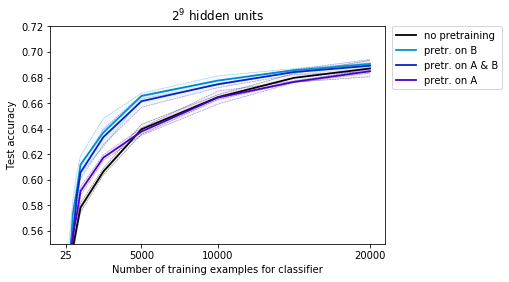

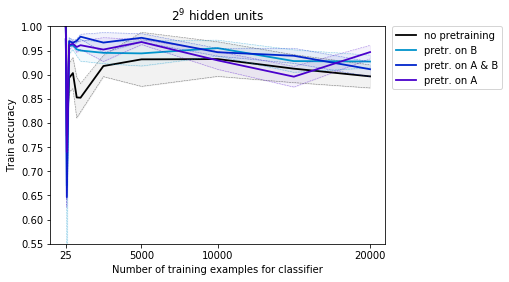

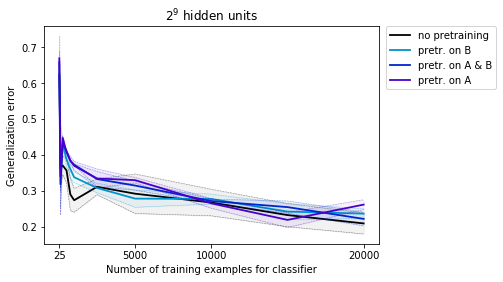

In [8]:
results_test[n_hus[1]], results_train[n_hus[1]], results_generr[n_hus[1]] = do_all_hl(n_hus[1])

#### Training for 2048 hu
## No Pre-Training
25
## seed: 11
Validation accuracy before training:
Test set: Average loss: 1.5879, Accuracy: 1491/5000 (30%)
[epoch 1] loss: 1.6420064
Test set: Average loss: 1.5160, Accuracy: 1632/5000 (33%)
[epoch 2] loss: 1.3638262
Test set: Average loss: 1.4808, Accuracy: 1672/5000 (33%)
[epoch 3] loss: 1.1580976
Test set: Average loss: 1.4632, Accuracy: 1712/5000 (34%)
[epoch 4] loss: 1.0033888
Test set: Average loss: 1.4531, Accuracy: 1777/5000 (36%)
[epoch 5] loss: 0.8808917
Test set: Average loss: 1.4462, Accuracy: 1849/5000 (37%)
[epoch 6] loss: 0.7806616
Test set: Average loss: 1.4411, Accuracy: 1894/5000 (38%)
[epoch 7] loss: 0.6975546
Test set: Average loss: 1.4370, Accuracy: 1912/5000 (38%)
[epoch 8] loss: 0.6284734
Test set: Average loss: 1.4337, Accuracy: 1931/5000 (39%)
[epoch 9] loss: 0.5709471
Test set: Average loss: 1.4310, Accuracy: 1952/5000 (39%)
[epoch 10] loss: 0.5228691
Test set: Average loss: 1.4292, Accuracy: 1977/5000 (40%)
[epo

[epoch 11] loss: 0.4744118
Test set: Average loss: 1.3883, Accuracy: 2094/5000 (42%)
[epoch 12] loss: 0.4250457
Test set: Average loss: 1.3964, Accuracy: 2058/5000 (41%)
[epoch 13] loss: 0.4274956
Epoch    12: reducing learning rate of group 0 to 5.0000e-06.
Test set: Average loss: 1.4038, Accuracy: 2034/5000 (41%)
[epoch 14] loss: 0.3960823
Test set: Average loss: 1.4044, Accuracy: 2033/5000 (41%)
[epoch 15] loss: 0.4014319
Epoch    14: reducing learning rate of group 0 to 5.0000e-07.
Test set: Average loss: 1.4047, Accuracy: 2032/5000 (41%)
[epoch 16] loss: 0.4008453
Epoch    15: reducing learning rate of group 0 to 5.0000e-08.
Test set: Average loss: 1.4047, Accuracy: 2033/5000 (41%)
[epoch 17] loss: 0.4058716
Epoch    16: reducing learning rate of group 0 to 5.0000e-09.
Test set: Average loss: 1.4047, Accuracy: 2033/5000 (41%)
[epoch 18] loss: 0.4026280
Epoch    17: reducing learning rate of group 0 to 5.0000e-10.
Test set: Average loss: 1.4047, Accuracy: 2033/5000 (41%)
[epoch 19]

Test set: Average loss: 1.3377, Accuracy: 2210/5000 (44%)
[epoch 15] loss: 0.5429696
Epoch    14: reducing learning rate of group 0 to 5.0000e-08.
Test set: Average loss: 1.3376, Accuracy: 2217/5000 (44%)
[epoch 16] loss: 0.5600136
Epoch    15: reducing learning rate of group 0 to 5.0000e-09.
Test set: Average loss: 1.3376, Accuracy: 2218/5000 (44%)
[epoch 17] loss: 0.5679438
Epoch    16: reducing learning rate of group 0 to 5.0000e-10.
Test set: Average loss: 1.3376, Accuracy: 2218/5000 (44%)
[epoch 18] loss: 0.5082035
Test set: Average loss: 1.3376, Accuracy: 2218/5000 (44%)
[epoch 19] loss: 0.5570132
Epoch    18: reducing learning rate of group 0 to 5.0000e-11.
Test set: Average loss: 1.3376, Accuracy: 2218/5000 (44%)
[epoch 20] loss: 0.5215861
Epoch    19: reducing learning rate of group 0 to 5.0000e-12.
Test set: Average loss: 1.3376, Accuracy: 2218/5000 (44%)
[epoch 21] loss: 0.5235283
Epoch    20: reducing learning rate of group 0 to 5.0000e-13.
Test set: Average loss: 1.3376, A

Test set: Average loss: 1.3101, Accuracy: 2445/5000 (49%)
Test
Test set: Average loss: 1.3229, Accuracy: 2424/5000 (48%)
Test set: Average loss: 0.6045, Accuracy: 95/100 (95%)
250
## seed: 11
Validation accuracy before training:
Test set: Average loss: 1.6370, Accuracy: 842/5000 (17%)
[epoch 1] loss: 1.5171768
Test set: Average loss: 1.3187, Accuracy: 2312/5000 (46%)
[epoch 2] loss: 1.1771975
Test set: Average loss: 1.2832, Accuracy: 2422/5000 (48%)
[epoch 3] loss: 1.0434969
Test set: Average loss: 1.2609, Accuracy: 2578/5000 (52%)
[epoch 4] loss: 0.9450633
Test set: Average loss: 1.2560, Accuracy: 2554/5000 (51%)
[epoch 5] loss: 0.8687724
Test set: Average loss: 1.2537, Accuracy: 2560/5000 (51%)
[epoch 6] loss: 0.8037420
Test set: Average loss: 1.2454, Accuracy: 2605/5000 (52%)
[epoch 7] loss: 0.7534201
Test set: Average loss: 1.2568, Accuracy: 2557/5000 (51%)
[epoch 8] loss: 0.7074630
Test set: Average loss: 1.2408, Accuracy: 2632/5000 (53%)
[epoch 9] loss: 0.6628300
Test set: Averag

[epoch 9] loss: 0.6854296
Test set: Average loss: 1.1652, Accuracy: 2742/5000 (55%)
[epoch 10] loss: 0.6437306
Test set: Average loss: 1.1756, Accuracy: 2727/5000 (55%)
[epoch 11] loss: 0.6184666
Test set: Average loss: 1.1717, Accuracy: 2766/5000 (55%)
[epoch 12] loss: 0.5860250
Test set: Average loss: 1.1671, Accuracy: 2750/5000 (55%)
[epoch 13] loss: 0.5546172
Test set: Average loss: 1.1771, Accuracy: 2693/5000 (54%)
[epoch 14] loss: 0.5306446
Test set: Average loss: 1.1734, Accuracy: 2723/5000 (54%)
[epoch 15] loss: 0.5051294
Test set: Average loss: 1.1744, Accuracy: 2747/5000 (55%)
[epoch 16] loss: 0.4784047
Test set: Average loss: 1.1730, Accuracy: 2746/5000 (55%)
[epoch 17] loss: 0.4577511
Test set: Average loss: 1.1717, Accuracy: 2743/5000 (55%)
[epoch 18] loss: 0.4426603
Test set: Average loss: 1.1808, Accuracy: 2712/5000 (54%)
[epoch 19] loss: 0.4234115
Test set: Average loss: 1.1868, Accuracy: 2673/5000 (53%)
[epoch 20] loss: 0.3979897
Test set: Average loss: 1.1817, Accurac

Test set: Average loss: 1.1460, Accuracy: 2804/5000 (56%)
[epoch 21] loss: 0.4012748
Test set: Average loss: 1.1453, Accuracy: 2794/5000 (56%)
[epoch 22] loss: 0.3795284
Test set: Average loss: 1.1374, Accuracy: 2816/5000 (56%)
[epoch 23] loss: 0.3564056
Test set: Average loss: 1.1464, Accuracy: 2801/5000 (56%)
[epoch 24] loss: 0.3417000
Test set: Average loss: 1.1393, Accuracy: 2829/5000 (57%)
[epoch 25] loss: 0.3270076
Test set: Average loss: 1.1472, Accuracy: 2823/5000 (56%)
Validation:
Test set: Average loss: 1.1470, Accuracy: 2878/5000 (58%)
Test
Test set: Average loss: 1.1509, Accuracy: 2833/5000 (57%)
Test set: Average loss: 0.8269, Accuracy: 587/750 (78%)
## seed: 12
Validation accuracy before training:
Test set: Average loss: 1.6217, Accuracy: 987/5000 (20%)
[epoch 1] loss: 1.3591731
Test set: Average loss: 1.2455, Accuracy: 2625/5000 (52%)
[epoch 2] loss: 1.1290699
Test set: Average loss: 1.1880, Accuracy: 2808/5000 (56%)
[epoch 3] loss: 1.0228021
Test set: Average loss: 1.17

Test set: Average loss: 1.1540, Accuracy: 2849/5000 (57%)
[epoch 4] loss: 0.9496351
Test set: Average loss: 1.1294, Accuracy: 2930/5000 (59%)
[epoch 5] loss: 0.8947746
Test set: Average loss: 1.1307, Accuracy: 2906/5000 (58%)
[epoch 6] loss: 0.8375720
Test set: Average loss: 1.1254, Accuracy: 2898/5000 (58%)
[epoch 7] loss: 0.7996234
Test set: Average loss: 1.1252, Accuracy: 2885/5000 (58%)
[epoch 8] loss: 0.7577870
Test set: Average loss: 1.1165, Accuracy: 2922/5000 (58%)
[epoch 9] loss: 0.7201619
Test set: Average loss: 1.1087, Accuracy: 2953/5000 (59%)
[epoch 10] loss: 0.6690689
Test set: Average loss: 1.1162, Accuracy: 2916/5000 (58%)
[epoch 11] loss: 0.6524576
Test set: Average loss: 1.1036, Accuracy: 2971/5000 (59%)
[epoch 12] loss: 0.6020810
Test set: Average loss: 1.0983, Accuracy: 2953/5000 (59%)
[epoch 13] loss: 0.5811385
Test set: Average loss: 1.1228, Accuracy: 2867/5000 (57%)
[epoch 14] loss: 0.5451909
Test set: Average loss: 1.1283, Accuracy: 2842/5000 (57%)
[epoch 15] lo

[epoch 15] loss: 0.4882352
Test set: Average loss: 1.0272, Accuracy: 3100/5000 (62%)
[epoch 16] loss: 0.4544692
Test set: Average loss: 1.0284, Accuracy: 3086/5000 (62%)
[epoch 17] loss: 0.4181565
Test set: Average loss: 1.0591, Accuracy: 3025/5000 (60%)
[epoch 18] loss: 0.3806467
Test set: Average loss: 1.0307, Accuracy: 3063/5000 (61%)
[epoch 19] loss: 0.3475889
Test set: Average loss: 1.0672, Accuracy: 3011/5000 (60%)
[epoch 20] loss: 0.3237635
Test set: Average loss: 1.0496, Accuracy: 3059/5000 (61%)
[epoch 21] loss: 0.2961321
Test set: Average loss: 1.0417, Accuracy: 3073/5000 (61%)
[epoch 22] loss: 0.2619357
Test set: Average loss: 1.0676, Accuracy: 3029/5000 (61%)
[epoch 23] loss: 0.2413308
Test set: Average loss: 1.0531, Accuracy: 3053/5000 (61%)
[epoch 24] loss: 0.2148922
Test set: Average loss: 1.0494, Accuracy: 3067/5000 (61%)
[epoch 25] loss: 0.1939252
Test set: Average loss: 1.0567, Accuracy: 3049/5000 (61%)
Validation:
Test set: Average loss: 1.0500, Accuracy: 3107/5000 (

Test set: Average loss: 1.0067, Accuracy: 3191/5000 (64%)
Test set: Average loss: 0.1859, Accuracy: 4912/5000 (98%)
## seed: 13
Validation accuracy before training:
Test set: Average loss: 1.6094, Accuracy: 1120/5000 (22%)
[epoch 1] loss: 1.1788233
Test set: Average loss: 1.1220, Accuracy: 2916/5000 (58%)
[epoch 2] loss: 1.0409372
Test set: Average loss: 1.0776, Accuracy: 3060/5000 (61%)
[epoch 3] loss: 0.9675404
Test set: Average loss: 1.0600, Accuracy: 3070/5000 (61%)
[epoch 4] loss: 0.9123135
Test set: Average loss: 1.0409, Accuracy: 3070/5000 (61%)
[epoch 5] loss: 0.8596034
Test set: Average loss: 1.0221, Accuracy: 3074/5000 (61%)
[epoch 6] loss: 0.8119701
Test set: Average loss: 1.0036, Accuracy: 3149/5000 (63%)
[epoch 7] loss: 0.7640009
Test set: Average loss: 1.0104, Accuracy: 3130/5000 (63%)
[epoch 8] loss: 0.7181099
Test set: Average loss: 0.9893, Accuracy: 3170/5000 (63%)
[epoch 9] loss: 0.6671813
Test set: Average loss: 0.9715, Accuracy: 3192/5000 (64%)
[epoch 10] loss: 0.61

[epoch 10] loss: 0.5402894
Test set: Average loss: 0.8982, Accuracy: 3354/5000 (67%)
[epoch 11] loss: 0.4774079
Test set: Average loss: 0.8978, Accuracy: 3357/5000 (67%)
[epoch 12] loss: 0.4211533
Test set: Average loss: 0.9120, Accuracy: 3299/5000 (66%)
[epoch 13] loss: 0.3619305
Test set: Average loss: 0.9122, Accuracy: 3333/5000 (67%)
[epoch 14] loss: 0.3064492
Test set: Average loss: 0.9055, Accuracy: 3344/5000 (67%)
[epoch 15] loss: 0.2580021
Test set: Average loss: 0.9143, Accuracy: 3355/5000 (67%)
[epoch 16] loss: 0.2107120
Test set: Average loss: 0.9238, Accuracy: 3352/5000 (67%)
[epoch 17] loss: 0.1696933
Test set: Average loss: 0.9382, Accuracy: 3323/5000 (66%)
[epoch 18] loss: 0.1389662
Test set: Average loss: 0.9491, Accuracy: 3340/5000 (67%)
[epoch 19] loss: 0.1146560
Test set: Average loss: 0.9565, Accuracy: 3361/5000 (67%)
[epoch 20] loss: 0.0871840
Test set: Average loss: 0.9716, Accuracy: 3364/5000 (67%)
[epoch 21] loss: 0.0724386
Test set: Average loss: 0.9987, Accura

[epoch 20] loss: 0.0580104
Test set: Average loss: 0.9904, Accuracy: 3444/5000 (69%)
[epoch 21] loss: 0.0422794
Test set: Average loss: 1.0155, Accuracy: 3413/5000 (68%)
[epoch 22] loss: 0.0375892
Test set: Average loss: 1.1542, Accuracy: 3303/5000 (66%)
[epoch 23] loss: 0.0589115
Epoch    22: reducing learning rate of group 0 to 5.0000e-06.
Test set: Average loss: 1.0455, Accuracy: 3434/5000 (69%)
[epoch 24] loss: 0.0182400
Test set: Average loss: 1.0260, Accuracy: 3444/5000 (69%)
[epoch 25] loss: 0.0160494
Test set: Average loss: 1.0293, Accuracy: 3459/5000 (69%)
Validation:
Test set: Average loss: 0.8467, Accuracy: 3471/5000 (69%)
Test
Test set: Average loss: 0.8704, Accuracy: 3421/5000 (68%)
Test set: Average loss: 0.3425, Accuracy: 13742/15000 (92%)
20000
## seed: 11
Validation accuracy before training:
Test set: Average loss: 1.6301, Accuracy: 1019/5000 (20%)
[epoch 1] loss: 1.0847259
Test set: Average loss: 1.0177, Accuracy: 3136/5000 (63%)
[epoch 2] loss: 0.9603950
Test set: Av

Test set: Average loss: 1.6576, Accuracy: 763/5000 (15%)
[epoch 1] loss: 1.0884546
Test set: Average loss: 1.0180, Accuracy: 3139/5000 (63%)
[epoch 2] loss: 0.9653594
Test set: Average loss: 0.9617, Accuracy: 3281/5000 (66%)
[epoch 3] loss: 0.8930766
Test set: Average loss: 0.9344, Accuracy: 3287/5000 (66%)
[epoch 4] loss: 0.8312031
Test set: Average loss: 0.9025, Accuracy: 3343/5000 (67%)
[epoch 5] loss: 0.7655037
Test set: Average loss: 0.8831, Accuracy: 3398/5000 (68%)
[epoch 6] loss: 0.7039804
Test set: Average loss: 0.8564, Accuracy: 3438/5000 (69%)
[epoch 7] loss: 0.6395757
Test set: Average loss: 0.8420, Accuracy: 3481/5000 (70%)
[epoch 8] loss: 0.5725036
Test set: Average loss: 0.8414, Accuracy: 3449/5000 (69%)
[epoch 9] loss: 0.5045020
Test set: Average loss: 0.8426, Accuracy: 3494/5000 (70%)
[epoch 10] loss: 0.4394547
Test set: Average loss: 0.8563, Accuracy: 3436/5000 (69%)
[epoch 11] loss: 0.3730944
Test set: Average loss: 0.8531, Accuracy: 3448/5000 (69%)
[epoch 12] loss: 

[epoch 12] loss: 0.8135607
Test set: Average loss: 1.5793, Accuracy: 1259/5000 (25%)
[epoch 13] loss: 0.7776338
Test set: Average loss: 1.5736, Accuracy: 1291/5000 (26%)
[epoch 14] loss: 0.7455792
Test set: Average loss: 1.5686, Accuracy: 1310/5000 (26%)
[epoch 15] loss: 0.7166968
Test set: Average loss: 1.5642, Accuracy: 1333/5000 (27%)
[epoch 16] loss: 0.6903697
Test set: Average loss: 1.5603, Accuracy: 1352/5000 (27%)
[epoch 17] loss: 0.6662382
Test set: Average loss: 1.5570, Accuracy: 1379/5000 (28%)
[epoch 18] loss: 0.6441100
Test set: Average loss: 1.5540, Accuracy: 1388/5000 (28%)
[epoch 19] loss: 0.6238381
Test set: Average loss: 1.5514, Accuracy: 1399/5000 (28%)
[epoch 20] loss: 0.6052547
Test set: Average loss: 1.5492, Accuracy: 1415/5000 (28%)
[epoch 21] loss: 0.5881598
Test set: Average loss: 1.5472, Accuracy: 1418/5000 (28%)
[epoch 22] loss: 0.5723759
Test set: Average loss: 1.5455, Accuracy: 1432/5000 (29%)
[epoch 23] loss: 0.5578002
Test set: Average loss: 1.5439, Accura

Test set: Average loss: 1.4515, Accuracy: 1894/5000 (38%)
[epoch 23] loss: 0.5702909
Test set: Average loss: 1.4513, Accuracy: 1892/5000 (38%)
[epoch 24] loss: 0.5790665
Epoch    23: reducing learning rate of group 0 to 5.0000e-07.
Test set: Average loss: 1.4510, Accuracy: 1894/5000 (38%)
[epoch 25] loss: 0.5716302
Epoch    24: reducing learning rate of group 0 to 5.0000e-08.
Test set: Average loss: 1.4510, Accuracy: 1894/5000 (38%)
Validation:
Test set: Average loss: 1.4510, Accuracy: 1894/5000 (38%)
Test
Test set: Average loss: 1.4546, Accuracy: 1861/5000 (37%)
Test set: Average loss: 0.5731, Accuracy: 48/50 (96%)
100
## seed: 11
Validation accuracy before training:
Test set: Average loss: 1.8125, Accuracy: 497/5000 (10%)
[epoch 1] loss: 1.8928872
Test set: Average loss: 1.7285, Accuracy: 770/5000 (15%)
[epoch 2] loss: 1.6422466
Test set: Average loss: 1.6615, Accuracy: 997/5000 (20%)
[epoch 3] loss: 1.4174278
Test set: Average loss: 1.6062, Accuracy: 1172/5000 (23%)
[epoch 4] loss: 

[epoch 12] loss: 0.8196486
Test set: Average loss: 1.3432, Accuracy: 2408/5000 (48%)
[epoch 13] loss: 0.8110991
Test set: Average loss: 1.3432, Accuracy: 2408/5000 (48%)
[epoch 14] loss: 0.8680475
Epoch    13: reducing learning rate of group 0 to 5.0000e-09.
Test set: Average loss: 1.3432, Accuracy: 2408/5000 (48%)
[epoch 15] loss: 0.7767549
Test set: Average loss: 1.3432, Accuracy: 2408/5000 (48%)
[epoch 16] loss: 0.8538594
Epoch    15: reducing learning rate of group 0 to 5.0000e-10.
Test set: Average loss: 1.3432, Accuracy: 2408/5000 (48%)
[epoch 17] loss: 0.8047387
Epoch    16: reducing learning rate of group 0 to 5.0000e-11.
Test set: Average loss: 1.3432, Accuracy: 2408/5000 (48%)
[epoch 18] loss: 0.8908876
Epoch    17: reducing learning rate of group 0 to 5.0000e-12.
Test set: Average loss: 1.3432, Accuracy: 2408/5000 (48%)
[epoch 19] loss: 0.8963065
Epoch    18: reducing learning rate of group 0 to 5.0000e-13.
Test set: Average loss: 1.3432, Accuracy: 2408/5000 (48%)
[epoch 20]

Test set: Average loss: 1.2680, Accuracy: 2500/5000 (50%)
[epoch 16] loss: 0.5842308
Test set: Average loss: 1.2646, Accuracy: 2510/5000 (50%)
[epoch 17] loss: 0.5623010
Test set: Average loss: 1.2613, Accuracy: 2521/5000 (50%)
[epoch 18] loss: 0.5434454
Test set: Average loss: 1.2585, Accuracy: 2527/5000 (51%)
[epoch 19] loss: 0.5273697
Test set: Average loss: 1.2553, Accuracy: 2541/5000 (51%)
[epoch 20] loss: 0.5096503
Test set: Average loss: 1.2537, Accuracy: 2539/5000 (51%)
[epoch 21] loss: 0.4958749
Test set: Average loss: 1.2529, Accuracy: 2535/5000 (51%)
[epoch 22] loss: 0.4798668
Test set: Average loss: 1.2518, Accuracy: 2545/5000 (51%)
[epoch 23] loss: 0.4693072
Test set: Average loss: 1.2507, Accuracy: 2534/5000 (51%)
[epoch 24] loss: 0.4571878
Test set: Average loss: 1.2491, Accuracy: 2534/5000 (51%)
[epoch 25] loss: 0.4430411
Test set: Average loss: 1.2471, Accuracy: 2553/5000 (51%)
Validation:
Test set: Average loss: 1.2471, Accuracy: 2553/5000 (51%)
Test
Test set: Average

Test set: Average loss: 1.1718, Accuracy: 2822/5000 (56%)
Test set: Average loss: 0.3387, Accuracy: 497/500 (99%)
750
## seed: 11
Validation accuracy before training:
Test set: Average loss: 1.6309, Accuracy: 890/5000 (18%)
[epoch 1] loss: 1.3877331
Test set: Average loss: 1.3329, Accuracy: 2457/5000 (49%)
[epoch 2] loss: 1.0975036
Test set: Average loss: 1.2460, Accuracy: 2729/5000 (55%)
[epoch 3] loss: 0.9503805
Test set: Average loss: 1.2036, Accuracy: 2871/5000 (57%)
[epoch 4] loss: 0.8638156
Test set: Average loss: 1.1788, Accuracy: 2915/5000 (58%)
[epoch 5] loss: 0.7998819
Test set: Average loss: 1.1615, Accuracy: 2929/5000 (59%)
[epoch 6] loss: 0.7449201
Test set: Average loss: 1.1501, Accuracy: 2948/5000 (59%)
[epoch 7] loss: 0.6951554
Test set: Average loss: 1.1395, Accuracy: 2979/5000 (60%)
[epoch 8] loss: 0.6602330
Test set: Average loss: 1.1296, Accuracy: 3013/5000 (60%)
[epoch 9] loss: 0.6281449
Test set: Average loss: 1.1210, Accuracy: 3012/5000 (60%)
[epoch 10] loss: 0.5

[epoch 10] loss: 0.5933549
Test set: Average loss: 1.0929, Accuracy: 3076/5000 (62%)
[epoch 11] loss: 0.5654787
Test set: Average loss: 1.0839, Accuracy: 3086/5000 (62%)
[epoch 12] loss: 0.5320772
Test set: Average loss: 1.0778, Accuracy: 3110/5000 (62%)
[epoch 13] loss: 0.5082687
Test set: Average loss: 1.0715, Accuracy: 3106/5000 (62%)
[epoch 14] loss: 0.4856221
Test set: Average loss: 1.0674, Accuracy: 3120/5000 (62%)
[epoch 15] loss: 0.4643295
Test set: Average loss: 1.0606, Accuracy: 3128/5000 (63%)
[epoch 16] loss: 0.4401206
Test set: Average loss: 1.0553, Accuracy: 3143/5000 (63%)
[epoch 17] loss: 0.4166220
Test set: Average loss: 1.0512, Accuracy: 3140/5000 (63%)
[epoch 18] loss: 0.3986788
Test set: Average loss: 1.0474, Accuracy: 3147/5000 (63%)
[epoch 19] loss: 0.3836945
Test set: Average loss: 1.0435, Accuracy: 3151/5000 (63%)
[epoch 20] loss: 0.3633266
Test set: Average loss: 1.0401, Accuracy: 3159/5000 (63%)
[epoch 21] loss: 0.3496952
Test set: Average loss: 1.0405, Accura

Test set: Average loss: 0.9416, Accuracy: 3273/5000 (65%)
[epoch 22] loss: 0.1845831
Test set: Average loss: 0.9376, Accuracy: 3266/5000 (65%)
[epoch 23] loss: 0.1739579
Test set: Average loss: 0.9409, Accuracy: 3265/5000 (65%)
[epoch 24] loss: 0.1577918
Test set: Average loss: 0.9427, Accuracy: 3280/5000 (66%)
[epoch 25] loss: 0.1442770
Test set: Average loss: 0.9406, Accuracy: 3288/5000 (66%)
Validation:
Test set: Average loss: 0.9410, Accuracy: 3289/5000 (66%)
Test
Test set: Average loss: 0.9552, Accuracy: 3190/5000 (64%)
Test set: Average loss: 0.2025, Accuracy: 2488/2500 (100%)
## seed: 12
Validation accuracy before training:
Test set: Average loss: 1.9740, Accuracy: 219/5000 (4%)
[epoch 1] loss: 1.5319574
Test set: Average loss: 1.2958, Accuracy: 2410/5000 (48%)
[epoch 2] loss: 1.1634947
Test set: Average loss: 1.1853, Accuracy: 2756/5000 (55%)
[epoch 3] loss: 1.0168636
Test set: Average loss: 1.1377, Accuracy: 2901/5000 (58%)
[epoch 4] loss: 0.9251026
Test set: Average loss: 1.1

[epoch 4] loss: 0.6201962
Test set: Average loss: 0.9590, Accuracy: 3349/5000 (67%)
[epoch 5] loss: 0.5340236
Test set: Average loss: 0.9381, Accuracy: 3358/5000 (67%)
[epoch 6] loss: 0.4594185
Test set: Average loss: 0.9215, Accuracy: 3396/5000 (68%)
[epoch 7] loss: 0.3950734
Test set: Average loss: 0.9058, Accuracy: 3399/5000 (68%)
[epoch 8] loss: 0.3382996
Test set: Average loss: 0.9005, Accuracy: 3400/5000 (68%)
[epoch 9] loss: 0.2898693
Test set: Average loss: 0.8889, Accuracy: 3453/5000 (69%)
[epoch 10] loss: 0.2486017
Test set: Average loss: 0.8815, Accuracy: 3460/5000 (69%)
[epoch 11] loss: 0.2139444
Test set: Average loss: 0.8783, Accuracy: 3444/5000 (69%)
[epoch 12] loss: 0.1833987
Test set: Average loss: 0.8802, Accuracy: 3442/5000 (69%)
[epoch 13] loss: 0.1580574
Test set: Average loss: 0.8763, Accuracy: 3460/5000 (69%)
[epoch 14] loss: 0.1362884
Test set: Average loss: 0.8736, Accuracy: 3434/5000 (69%)
[epoch 15] loss: 0.1183992
Test set: Average loss: 0.8764, Accuracy: 34

Test set: Average loss: 0.9097, Accuracy: 3503/5000 (70%)
[epoch 16] loss: 0.0271942
Test set: Average loss: 0.9206, Accuracy: 3511/5000 (70%)
[epoch 17] loss: 0.0225251
Test set: Average loss: 0.9418, Accuracy: 3496/5000 (70%)
[epoch 18] loss: 0.0188145
Test set: Average loss: 0.9502, Accuracy: 3524/5000 (70%)
[epoch 19] loss: 0.0155638
Test set: Average loss: 0.9507, Accuracy: 3514/5000 (70%)
[epoch 20] loss: 0.0130115
Test set: Average loss: 0.9704, Accuracy: 3509/5000 (70%)
[epoch 21] loss: 0.0108951
Test set: Average loss: 0.9785, Accuracy: 3522/5000 (70%)
[epoch 22] loss: 0.0091767
Test set: Average loss: 0.9963, Accuracy: 3510/5000 (70%)
[epoch 23] loss: 0.0077445
Test set: Average loss: 1.0081, Accuracy: 3511/5000 (70%)
[epoch 24] loss: 0.0065491
Test set: Average loss: 1.0230, Accuracy: 3509/5000 (70%)
[epoch 25] loss: 0.0055412
Test set: Average loss: 1.0420, Accuracy: 3509/5000 (70%)
Validation:
Test set: Average loss: 0.9502, Accuracy: 3524/5000 (70%)
Test
Test set: Average

[epoch 20] loss: 0.0176406
Test set: Average loss: 0.9314, Accuracy: 3566/5000 (71%)
[epoch 21] loss: 0.0165072
Test set: Average loss: 0.9374, Accuracy: 3563/5000 (71%)
[epoch 22] loss: 0.0154470
Test set: Average loss: 0.9431, Accuracy: 3559/5000 (71%)
[epoch 23] loss: 0.0144530
Test set: Average loss: 0.9470, Accuracy: 3558/5000 (71%)
[epoch 24] loss: 0.0135364
Test set: Average loss: 0.9494, Accuracy: 3563/5000 (71%)
[epoch 25] loss: 0.0126636
Test set: Average loss: 0.9541, Accuracy: 3555/5000 (71%)
Validation:
Test set: Average loss: 0.9314, Accuracy: 3566/5000 (71%)
Test
Test set: Average loss: 0.9604, Accuracy: 3509/5000 (70%)
Test set: Average loss: 0.0167, Accuracy: 14999/15000 (100%)
## seed: 13
Validation accuracy before training:
Test set: Average loss: 1.7822, Accuracy: 604/5000 (12%)
[epoch 1] loss: 1.0564803
Test set: Average loss: 1.0232, Accuracy: 3247/5000 (65%)
[epoch 2] loss: 0.7507707
Test set: Average loss: 0.9300, Accuracy: 3432/5000 (69%)
[epoch 3] loss: 0.5569

[epoch 20] loss: 0.0086083
Test set: Average loss: 0.9899, Accuracy: 3549/5000 (71%)
[epoch 21] loss: 0.0078034
Test set: Average loss: 0.9982, Accuracy: 3544/5000 (71%)
[epoch 22] loss: 0.0070900
Test set: Average loss: 1.0029, Accuracy: 3554/5000 (71%)
[epoch 23] loss: 0.0064332
Test set: Average loss: 1.0144, Accuracy: 3550/5000 (71%)
[epoch 24] loss: 0.0058302
Test set: Average loss: 1.0224, Accuracy: 3541/5000 (71%)
[epoch 25] loss: 0.0052888
Test set: Average loss: 1.0317, Accuracy: 3558/5000 (71%)
Validation:
Test set: Average loss: 0.8988, Accuracy: 3566/5000 (71%)
Test
Test set: Average loss: 0.9270, Accuracy: 3484/5000 (70%)
Test set: Average loss: 0.0314, Accuracy: 19997/20000 (100%)
## seed: 13
Validation accuracy before training:
Test set: Average loss: 1.5071, Accuracy: 1817/5000 (36%)
[epoch 1] loss: 0.8786670
Test set: Average loss: 0.9398, Accuracy: 3401/5000 (68%)
[epoch 2] loss: 0.5749976
Test set: Average loss: 0.8713, Accuracy: 3467/5000 (69%)
[epoch 3] loss: 0.388

Test set: Average loss: 1.5070, Accuracy: 1771/5000 (35%)
Validation:
Test set: Average loss: 1.5070, Accuracy: 1771/5000 (35%)
Test
Test set: Average loss: 1.5140, Accuracy: 1772/5000 (35%)
Test set: Average loss: 0.4443, Accuracy: 25/25 (100%)
## seed: 12
Validation accuracy before training:
Test set: Average loss: 1.6696, Accuracy: 982/5000 (20%)
[epoch 1] loss: 1.6962296
Test set: Average loss: 1.6331, Accuracy: 1142/5000 (23%)
[epoch 2] loss: 1.5122099
Test set: Average loss: 1.6019, Accuracy: 1302/5000 (26%)
[epoch 3] loss: 1.3567231
Test set: Average loss: 1.5768, Accuracy: 1433/5000 (29%)
[epoch 4] loss: 1.2320644
Test set: Average loss: 1.5568, Accuracy: 1518/5000 (30%)
[epoch 5] loss: 1.1284882
Test set: Average loss: 1.5407, Accuracy: 1591/5000 (32%)
[epoch 6] loss: 1.0375960
Test set: Average loss: 1.5276, Accuracy: 1647/5000 (33%)
[epoch 7] loss: 0.9562307
Test set: Average loss: 1.5166, Accuracy: 1697/5000 (34%)
[epoch 8] loss: 0.8839146
Test set: Average loss: 1.5073, Ac

[epoch 8] loss: 0.8933621
Test set: Average loss: 1.5441, Accuracy: 1834/5000 (37%)
[epoch 9] loss: 0.8549252
Test set: Average loss: 1.5389, Accuracy: 1840/5000 (37%)
[epoch 10] loss: 0.8200678
Test set: Average loss: 1.5340, Accuracy: 1867/5000 (37%)
[epoch 11] loss: 0.7902447
Test set: Average loss: 1.5291, Accuracy: 1876/5000 (38%)
[epoch 12] loss: 0.7363498
Test set: Average loss: 1.5241, Accuracy: 1891/5000 (38%)
[epoch 13] loss: 0.7062238
Test set: Average loss: 1.5193, Accuracy: 1906/5000 (38%)
[epoch 14] loss: 0.6872100
Test set: Average loss: 1.5149, Accuracy: 1925/5000 (38%)
[epoch 15] loss: 0.6449167
Test set: Average loss: 1.5110, Accuracy: 1937/5000 (39%)
[epoch 16] loss: 0.6349136
Test set: Average loss: 1.5079, Accuracy: 1956/5000 (39%)
[epoch 17] loss: 0.6316037
Test set: Average loss: 1.5050, Accuracy: 1972/5000 (39%)
[epoch 18] loss: 0.5946155
Test set: Average loss: 1.5019, Accuracy: 1983/5000 (40%)
[epoch 19] loss: 0.5983149
Epoch    18: reducing learning rate of g

Test set: Average loss: 1.7509, Accuracy: 569/5000 (11%)
[epoch 1] loss: 1.7153506
Test set: Average loss: 1.6512, Accuracy: 931/5000 (19%)
[epoch 2] loss: 1.4596268
Test set: Average loss: 1.6008, Accuracy: 1236/5000 (25%)
[epoch 3] loss: 1.2201074
Test set: Average loss: 1.5572, Accuracy: 1440/5000 (29%)
[epoch 4] loss: 1.1369187
Test set: Average loss: 1.5214, Accuracy: 1616/5000 (32%)
[epoch 5] loss: 1.0912482
Test set: Average loss: 1.4928, Accuracy: 1757/5000 (35%)
[epoch 6] loss: 0.9905397
Test set: Average loss: 1.4696, Accuracy: 1862/5000 (37%)
[epoch 7] loss: 0.9211862
Test set: Average loss: 1.4548, Accuracy: 1929/5000 (39%)
[epoch 8] loss: 0.9222462
Epoch     7: reducing learning rate of group 0 to 5.0000e-06.
Test set: Average loss: 1.4459, Accuracy: 1976/5000 (40%)
[epoch 9] loss: 0.9096025
Test set: Average loss: 1.4453, Accuracy: 1975/5000 (40%)
[epoch 10] loss: 0.8737943
Test set: Average loss: 1.4446, Accuracy: 1972/5000 (39%)
[epoch 11] loss: 0.8057777
Test set: Aver

[epoch 23] loss: 0.4251876
Test set: Average loss: 1.1920, Accuracy: 2735/5000 (55%)
[epoch 24] loss: 0.4117374
Test set: Average loss: 1.1929, Accuracy: 2727/5000 (55%)
[epoch 25] loss: 0.3992008
Test set: Average loss: 1.1914, Accuracy: 2734/5000 (55%)
Validation:
Test set: Average loss: 1.2000, Accuracy: 2743/5000 (55%)
Test
Test set: Average loss: 1.2139, Accuracy: 2672/5000 (53%)
Test set: Average loss: 0.5327, Accuracy: 242/250 (97%)
## seed: 12
Validation accuracy before training:
Test set: Average loss: 1.6710, Accuracy: 971/5000 (19%)
[epoch 1] loss: 1.6022236
Test set: Average loss: 1.5110, Accuracy: 1821/5000 (36%)
[epoch 2] loss: 1.3747343
Test set: Average loss: 1.4304, Accuracy: 2059/5000 (41%)
[epoch 3] loss: 1.2402501
Test set: Average loss: 1.3780, Accuracy: 2237/5000 (45%)
[epoch 4] loss: 1.1361084
Test set: Average loss: 1.3425, Accuracy: 2354/5000 (47%)
[epoch 5] loss: 1.0566396
Test set: Average loss: 1.3185, Accuracy: 2447/5000 (49%)
[epoch 6] loss: 0.9889661
Test

[epoch 6] loss: 0.9361137
Test set: Average loss: 1.2404, Accuracy: 2670/5000 (53%)
[epoch 7] loss: 0.8774238
Test set: Average loss: 1.2235, Accuracy: 2726/5000 (55%)
[epoch 8] loss: 0.8255379
Test set: Average loss: 1.2129, Accuracy: 2722/5000 (54%)
[epoch 9] loss: 0.7822663
Test set: Average loss: 1.2014, Accuracy: 2766/5000 (55%)
[epoch 10] loss: 0.7362916
Test set: Average loss: 1.1969, Accuracy: 2774/5000 (55%)
[epoch 11] loss: 0.6979154
Test set: Average loss: 1.1860, Accuracy: 2804/5000 (56%)
[epoch 12] loss: 0.6654468
Test set: Average loss: 1.1828, Accuracy: 2808/5000 (56%)
[epoch 13] loss: 0.6360052
Test set: Average loss: 1.1783, Accuracy: 2815/5000 (56%)
[epoch 14] loss: 0.6045855
Test set: Average loss: 1.1678, Accuracy: 2848/5000 (57%)
[epoch 15] loss: 0.5784332
Test set: Average loss: 1.1671, Accuracy: 2845/5000 (57%)
[epoch 16] loss: 0.5493891
Test set: Average loss: 1.1661, Accuracy: 2837/5000 (57%)
[epoch 17] loss: 0.5248754
Test set: Average loss: 1.1587, Accuracy: 

Test set: Average loss: 1.1474, Accuracy: 2906/5000 (58%)
[epoch 18] loss: 0.4473973
Test set: Average loss: 1.1403, Accuracy: 2927/5000 (59%)
[epoch 19] loss: 0.4188350
Test set: Average loss: 1.1415, Accuracy: 2921/5000 (58%)
[epoch 20] loss: 0.3968675
Test set: Average loss: 1.1394, Accuracy: 2931/5000 (59%)
[epoch 21] loss: 0.3726842
Test set: Average loss: 1.1353, Accuracy: 2926/5000 (59%)
[epoch 22] loss: 0.3569049
Test set: Average loss: 1.1362, Accuracy: 2931/5000 (59%)
[epoch 23] loss: 0.3355632
Test set: Average loss: 1.1332, Accuracy: 2926/5000 (59%)
[epoch 24] loss: 0.3206961
Test set: Average loss: 1.1320, Accuracy: 2929/5000 (59%)
[epoch 25] loss: 0.3045399
Test set: Average loss: 1.1356, Accuracy: 2908/5000 (58%)
Validation:
Test set: Average loss: 1.1362, Accuracy: 2931/5000 (59%)
Test
Test set: Average loss: 1.1393, Accuracy: 2858/5000 (57%)
Test set: Average loss: 0.3391, Accuracy: 743/750 (99%)
## seed: 13
Validation accuracy before training:
Test set: Average loss: 

Test set: Average loss: 1.6658, Accuracy: 976/5000 (20%)
[epoch 1] loss: 1.4634297
Test set: Average loss: 1.3194, Accuracy: 2329/5000 (47%)
[epoch 2] loss: 1.1872546
Test set: Average loss: 1.2551, Accuracy: 2546/5000 (51%)
[epoch 3] loss: 1.0705074
Test set: Average loss: 1.2143, Accuracy: 2722/5000 (54%)
[epoch 4] loss: 0.9741602
Test set: Average loss: 1.1863, Accuracy: 2786/5000 (56%)
[epoch 5] loss: 0.9050023
Test set: Average loss: 1.1663, Accuracy: 2855/5000 (57%)
[epoch 6] loss: 0.8423105
Test set: Average loss: 1.1584, Accuracy: 2846/5000 (57%)
[epoch 7] loss: 0.7896845
Test set: Average loss: 1.1472, Accuracy: 2881/5000 (58%)
[epoch 8] loss: 0.7474448
Test set: Average loss: 1.1336, Accuracy: 2915/5000 (58%)
[epoch 9] loss: 0.6939671
Test set: Average loss: 1.1267, Accuracy: 2927/5000 (59%)
[epoch 10] loss: 0.6489465
Test set: Average loss: 1.1203, Accuracy: 2938/5000 (59%)
[epoch 11] loss: 0.6158733
Test set: Average loss: 1.1152, Accuracy: 2928/5000 (59%)
[epoch 12] loss: 

[epoch 12] loss: 0.5397766
Test set: Average loss: 1.0146, Accuracy: 3124/5000 (62%)
[epoch 13] loss: 0.4911401
Test set: Average loss: 1.0144, Accuracy: 3123/5000 (62%)
[epoch 14] loss: 0.4504617
Test set: Average loss: 1.0100, Accuracy: 3128/5000 (63%)
[epoch 15] loss: 0.4139396
Test set: Average loss: 1.0035, Accuracy: 3146/5000 (63%)
[epoch 16] loss: 0.3748936
Test set: Average loss: 1.0052, Accuracy: 3128/5000 (63%)
[epoch 17] loss: 0.3358658
Test set: Average loss: 1.0054, Accuracy: 3131/5000 (63%)
[epoch 18] loss: 0.3083210
Test set: Average loss: 1.0012, Accuracy: 3121/5000 (62%)
[epoch 19] loss: 0.2843039
Test set: Average loss: 1.0049, Accuracy: 3096/5000 (62%)
[epoch 20] loss: 0.2545582
Test set: Average loss: 1.0050, Accuracy: 3121/5000 (62%)
[epoch 21] loss: 0.2263492
Test set: Average loss: 1.0024, Accuracy: 3127/5000 (63%)
[epoch 22] loss: 0.2018217
Test set: Average loss: 1.0044, Accuracy: 3126/5000 (63%)
[epoch 23] loss: 0.1824191
Test set: Average loss: 1.0121, Accura

Test set: Average loss: 0.9863, Accuracy: 3318/5000 (66%)
[epoch 24] loss: 0.0541429
Test set: Average loss: 0.9921, Accuracy: 3296/5000 (66%)
[epoch 25] loss: 0.0465540
Test set: Average loss: 1.0066, Accuracy: 3292/5000 (66%)
Validation:
Test set: Average loss: 0.9339, Accuracy: 3326/5000 (67%)
Test
Test set: Average loss: 0.9404, Accuracy: 3284/5000 (66%)
Test set: Average loss: 0.2231, Accuracy: 4919/5000 (98%)
10000
## seed: 11
Validation accuracy before training:
Test set: Average loss: 1.7122, Accuracy: 795/5000 (16%)
[epoch 1] loss: 1.2011436
Test set: Average loss: 1.0860, Accuracy: 3102/5000 (62%)
[epoch 2] loss: 1.0043011
Test set: Average loss: 1.0174, Accuracy: 3190/5000 (64%)
[epoch 3] loss: 0.8975922
Test set: Average loss: 0.9736, Accuracy: 3246/5000 (65%)
[epoch 4] loss: 0.8082512
Test set: Average loss: 0.9389, Accuracy: 3300/5000 (66%)
[epoch 5] loss: 0.7253622
Test set: Average loss: 0.9154, Accuracy: 3305/5000 (66%)
[epoch 6] loss: 0.6452299
Test set: Average loss:

[epoch 5] loss: 0.7165584
Test set: Average loss: 0.8832, Accuracy: 3367/5000 (67%)
[epoch 6] loss: 0.6319777
Test set: Average loss: 0.8524, Accuracy: 3427/5000 (69%)
[epoch 7] loss: 0.5529944
Test set: Average loss: 0.8466, Accuracy: 3413/5000 (68%)
[epoch 8] loss: 0.4749403
Test set: Average loss: 0.8556, Accuracy: 3424/5000 (68%)
[epoch 9] loss: 0.3999812
Test set: Average loss: 0.8489, Accuracy: 3449/5000 (69%)
[epoch 10] loss: 0.3338293
Test set: Average loss: 0.8431, Accuracy: 3445/5000 (69%)
[epoch 11] loss: 0.2684980
Test set: Average loss: 0.8476, Accuracy: 3424/5000 (68%)
[epoch 12] loss: 0.2164817
Test set: Average loss: 0.8611, Accuracy: 3427/5000 (69%)
[epoch 13] loss: 0.1672345
Test set: Average loss: 0.8845, Accuracy: 3450/5000 (69%)
[epoch 14] loss: 0.1282721
Test set: Average loss: 0.9177, Accuracy: 3393/5000 (68%)
[epoch 15] loss: 0.0997423
Test set: Average loss: 0.9124, Accuracy: 3433/5000 (69%)
[epoch 16] loss: 0.0746707
Test set: Average loss: 0.9189, Accuracy: 3

Test set: Average loss: 0.9115, Accuracy: 3435/5000 (69%)
[epoch 14] loss: 0.0894377
Test set: Average loss: 0.9244, Accuracy: 3491/5000 (70%)
[epoch 15] loss: 0.0710276
Test set: Average loss: 1.0117, Accuracy: 3400/5000 (68%)
[epoch 16] loss: 0.0528488
Test set: Average loss: 0.9797, Accuracy: 3495/5000 (70%)
[epoch 17] loss: 0.0429813
Test set: Average loss: 1.0154, Accuracy: 3432/5000 (69%)
[epoch 18] loss: 0.0478730
Epoch    17: reducing learning rate of group 0 to 5.0000e-06.
Test set: Average loss: 1.0366, Accuracy: 3469/5000 (69%)
[epoch 19] loss: 0.0217865
Test set: Average loss: 1.0093, Accuracy: 3501/5000 (70%)
[epoch 20] loss: 0.0170531
Test set: Average loss: 1.0073, Accuracy: 3503/5000 (70%)
[epoch 21] loss: 0.0151332
Test set: Average loss: 1.0080, Accuracy: 3511/5000 (70%)
[epoch 22] loss: 0.0137749
Test set: Average loss: 1.0141, Accuracy: 3509/5000 (70%)
[epoch 23] loss: 0.0126189
Test set: Average loss: 1.0169, Accuracy: 3514/5000 (70%)
[epoch 24] loss: 0.0116079
Tes

Test set: Average loss: 1.6766, Accuracy: 2314/5000 (46%)
[epoch 20] loss: 0.3095356
Test set: Average loss: 1.7175, Accuracy: 2289/5000 (46%)
[epoch 21] loss: 0.2600560
Test set: Average loss: 1.7827, Accuracy: 2274/5000 (45%)
[epoch 22] loss: 0.2149673
Test set: Average loss: 1.7950, Accuracy: 2284/5000 (46%)
[epoch 23] loss: 0.1734857
Test set: Average loss: 1.8322, Accuracy: 2272/5000 (45%)
[epoch 24] loss: 0.1468800
Test set: Average loss: 1.8618, Accuracy: 2285/5000 (46%)
[epoch 25] loss: 0.1313415
Test set: Average loss: 1.9966, Accuracy: 2216/5000 (44%)
Validation:
Test set: Average loss: 1.5962, Accuracy: 2343/5000 (47%)
Test set: Average loss: 1.5839, Accuracy: 4659/10000 (47%)
25
## seed: 11
Validation accuracy before training:
Test set: Average loss: 1.4739, Accuracy: 1883/5000 (38%)
[epoch 1] loss: 1.4360646
Test set: Average loss: 1.4564, Accuracy: 1971/5000 (39%)
[epoch 2] loss: 1.2813022
Test set: Average loss: 1.4417, Accuracy: 2016/5000 (40%)
[epoch 3] loss: 1.1521701

[epoch 3] loss: 1.3141626
Test set: Average loss: 1.5133, Accuracy: 1682/5000 (34%)
[epoch 4] loss: 1.1852496
Test set: Average loss: 1.4924, Accuracy: 1725/5000 (34%)
[epoch 5] loss: 1.0905229
Test set: Average loss: 1.4748, Accuracy: 1777/5000 (36%)
[epoch 6] loss: 1.0069027
Test set: Average loss: 1.4607, Accuracy: 1807/5000 (36%)
[epoch 7] loss: 0.9255342
Test set: Average loss: 1.4492, Accuracy: 1846/5000 (37%)
[epoch 8] loss: 0.8584638
Test set: Average loss: 1.4404, Accuracy: 1856/5000 (37%)
[epoch 9] loss: 0.8261623
Test set: Average loss: 1.4326, Accuracy: 1899/5000 (38%)
[epoch 10] loss: 0.7917752
Test set: Average loss: 1.4258, Accuracy: 1936/5000 (39%)
[epoch 11] loss: 0.7296264
Test set: Average loss: 1.4195, Accuracy: 1958/5000 (39%)
[epoch 12] loss: 0.7217692
Test set: Average loss: 1.4137, Accuracy: 1967/5000 (39%)
[epoch 13] loss: 0.6629938
Test set: Average loss: 1.4083, Accuracy: 1981/5000 (40%)
[epoch 14] loss: 0.6411200
Test set: Average loss: 1.4033, Accuracy: 201

[epoch 9] loss: 0.6809499
Test set: Average loss: 1.3791, Accuracy: 2216/5000 (44%)
[epoch 10] loss: 0.7081599
Epoch     9: reducing learning rate of group 0 to 5.0000e-06.
Test set: Average loss: 1.3727, Accuracy: 2225/5000 (44%)
[epoch 11] loss: 0.6526398
Test set: Average loss: 1.3727, Accuracy: 2222/5000 (44%)
[epoch 12] loss: 0.6441591
Test set: Average loss: 1.3729, Accuracy: 2228/5000 (45%)
[epoch 13] loss: 0.6179275
Test set: Average loss: 1.3731, Accuracy: 2232/5000 (45%)
[epoch 14] loss: 0.6703043
Epoch    13: reducing learning rate of group 0 to 5.0000e-07.
Test set: Average loss: 1.3733, Accuracy: 2233/5000 (45%)
[epoch 15] loss: 0.6383946
Epoch    14: reducing learning rate of group 0 to 5.0000e-08.
Test set: Average loss: 1.3733, Accuracy: 2236/5000 (45%)
[epoch 16] loss: 0.6545390
Epoch    15: reducing learning rate of group 0 to 5.0000e-09.
Test set: Average loss: 1.3733, Accuracy: 2236/5000 (45%)
[epoch 17] loss: 0.6830653
Epoch    16: reducing learning rate of group 0

[epoch 25] loss: 0.6721058
Epoch    24: reducing learning rate of group 0 to 5.0000e-17.
Test set: Average loss: 1.2720, Accuracy: 2480/5000 (50%)
Validation:
Test set: Average loss: 1.2720, Accuracy: 2480/5000 (50%)
Test
Test set: Average loss: 1.2834, Accuracy: 2469/5000 (49%)
Test set: Average loss: 0.6820, Accuracy: 96/100 (96%)
250
## seed: 11
Validation accuracy before training:
Test set: Average loss: 1.7160, Accuracy: 872/5000 (17%)
[epoch 1] loss: 1.7368438
Test set: Average loss: 1.5656, Accuracy: 1561/5000 (31%)
[epoch 2] loss: 1.4515909
Test set: Average loss: 1.4821, Accuracy: 1967/5000 (39%)
[epoch 3] loss: 1.2826531
Test set: Average loss: 1.4213, Accuracy: 2221/5000 (44%)
[epoch 4] loss: 1.1585548
Test set: Average loss: 1.3831, Accuracy: 2357/5000 (47%)
[epoch 5] loss: 1.0614567
Test set: Average loss: 1.3572, Accuracy: 2441/5000 (49%)
[epoch 6] loss: 0.9815119
Test set: Average loss: 1.3414, Accuracy: 2464/5000 (49%)
[epoch 7] loss: 0.9095048
Test set: Average loss: 1

Test set: Average loss: 1.1973, Accuracy: 2798/5000 (56%)
[epoch 8] loss: 0.6925791
Test set: Average loss: 1.1890, Accuracy: 2799/5000 (56%)
[epoch 9] loss: 0.6467685
Test set: Average loss: 1.1833, Accuracy: 2801/5000 (56%)
[epoch 10] loss: 0.6100544
Test set: Average loss: 1.1765, Accuracy: 2825/5000 (56%)
[epoch 11] loss: 0.5750036
Test set: Average loss: 1.1717, Accuracy: 2822/5000 (56%)
[epoch 12] loss: 0.5438390
Test set: Average loss: 1.1678, Accuracy: 2823/5000 (56%)
[epoch 13] loss: 0.5158989
Test set: Average loss: 1.1630, Accuracy: 2831/5000 (57%)
[epoch 14] loss: 0.4906144
Test set: Average loss: 1.1600, Accuracy: 2827/5000 (57%)
[epoch 15] loss: 0.4671478
Test set: Average loss: 1.1561, Accuracy: 2842/5000 (57%)
[epoch 16] loss: 0.4469336
Test set: Average loss: 1.1524, Accuracy: 2842/5000 (57%)
[epoch 17] loss: 0.4237006
Test set: Average loss: 1.1514, Accuracy: 2839/5000 (57%)
[epoch 18] loss: 0.4041776
Test set: Average loss: 1.1476, Accuracy: 2849/5000 (57%)
[epoch 19

[epoch 19] loss: 0.4233990
Test set: Average loss: 1.1383, Accuracy: 2868/5000 (57%)
[epoch 20] loss: 0.4034098
Test set: Average loss: 1.1378, Accuracy: 2876/5000 (58%)
[epoch 21] loss: 0.3864023
Test set: Average loss: 1.1349, Accuracy: 2878/5000 (58%)
[epoch 22] loss: 0.3658755
Test set: Average loss: 1.1324, Accuracy: 2880/5000 (58%)
[epoch 23] loss: 0.3503419
Test set: Average loss: 1.1290, Accuracy: 2901/5000 (58%)
[epoch 24] loss: 0.3375514
Test set: Average loss: 1.1277, Accuracy: 2889/5000 (58%)
[epoch 25] loss: 0.3190760
Test set: Average loss: 1.1295, Accuracy: 2872/5000 (57%)
Validation:
Test set: Average loss: 1.1290, Accuracy: 2901/5000 (58%)
Test
Test set: Average loss: 1.1256, Accuracy: 2874/5000 (57%)
Test set: Average loss: 0.3363, Accuracy: 747/750 (100%)
## seed: 12
Validation accuracy before training:
Test set: Average loss: 1.6646, Accuracy: 1124/5000 (22%)
[epoch 1] loss: 1.4922858
Test set: Average loss: 1.3429, Accuracy: 2344/5000 (47%)
[epoch 2] loss: 1.179117

[epoch 2] loss: 1.1673854
Test set: Average loss: 1.2571, Accuracy: 2608/5000 (52%)
[epoch 3] loss: 1.0228179
Test set: Average loss: 1.2136, Accuracy: 2743/5000 (55%)
[epoch 4] loss: 0.9227988
Test set: Average loss: 1.1841, Accuracy: 2844/5000 (57%)
[epoch 5] loss: 0.8352123
Test set: Average loss: 1.1622, Accuracy: 2888/5000 (58%)
[epoch 6] loss: 0.7701341
Test set: Average loss: 1.1518, Accuracy: 2919/5000 (58%)
[epoch 7] loss: 0.7144228
Test set: Average loss: 1.1466, Accuracy: 2936/5000 (59%)
[epoch 8] loss: 0.6651882
Test set: Average loss: 1.1290, Accuracy: 2958/5000 (59%)
[epoch 9] loss: 0.6283278
Test set: Average loss: 1.1221, Accuracy: 2963/5000 (59%)
[epoch 10] loss: 0.5861840
Test set: Average loss: 1.1148, Accuracy: 2997/5000 (60%)
[epoch 11] loss: 0.5435825
Test set: Average loss: 1.1043, Accuracy: 3016/5000 (60%)
[epoch 12] loss: 0.5154156
Test set: Average loss: 1.1074, Accuracy: 2981/5000 (60%)
[epoch 13] loss: 0.4881658
Test set: Average loss: 1.0994, Accuracy: 2996

Test set: Average loss: 0.9591, Accuracy: 3232/5000 (65%)
[epoch 14] loss: 0.3343071
Test set: Average loss: 0.9529, Accuracy: 3236/5000 (65%)
[epoch 15] loss: 0.3072311
Test set: Average loss: 0.9530, Accuracy: 3244/5000 (65%)
[epoch 16] loss: 0.2757625
Test set: Average loss: 0.9528, Accuracy: 3241/5000 (65%)
[epoch 17] loss: 0.2495141
Test set: Average loss: 0.9495, Accuracy: 3237/5000 (65%)
[epoch 18] loss: 0.2281683
Test set: Average loss: 0.9454, Accuracy: 3239/5000 (65%)
[epoch 19] loss: 0.2104122
Test set: Average loss: 0.9445, Accuracy: 3257/5000 (65%)
[epoch 20] loss: 0.1912101
Test set: Average loss: 0.9445, Accuracy: 3239/5000 (65%)
[epoch 21] loss: 0.1723450
Test set: Average loss: 0.9457, Accuracy: 3257/5000 (65%)
[epoch 22] loss: 0.1574876
Test set: Average loss: 0.9455, Accuracy: 3256/5000 (65%)
[epoch 23] loss: 0.1414299
Test set: Average loss: 0.9460, Accuracy: 3244/5000 (65%)
[epoch 24] loss: 0.1292384
Test set: Average loss: 0.9473, Accuracy: 3240/5000 (65%)
[epoch 

[epoch 25] loss: 0.0413695
Test set: Average loss: 0.9325, Accuracy: 3418/5000 (68%)
Validation:
Test set: Average loss: 0.9194, Accuracy: 3425/5000 (68%)
Test
Test set: Average loss: 0.9483, Accuracy: 3314/5000 (66%)
Test set: Average loss: 0.0471, Accuracy: 4999/5000 (100%)
## seed: 13
Validation accuracy before training:
Test set: Average loss: 1.9123, Accuracy: 432/5000 (9%)
[epoch 1] loss: 1.3085091
Test set: Average loss: 1.1702, Accuracy: 2775/5000 (56%)
[epoch 2] loss: 1.0368317
Test set: Average loss: 1.0878, Accuracy: 3027/5000 (61%)
[epoch 3] loss: 0.9127009
Test set: Average loss: 1.0524, Accuracy: 3120/5000 (62%)
[epoch 4] loss: 0.8145765
Test set: Average loss: 1.0104, Accuracy: 3215/5000 (64%)
[epoch 5] loss: 0.7287571
Test set: Average loss: 0.9892, Accuracy: 3236/5000 (65%)
[epoch 6] loss: 0.6493048
Test set: Average loss: 0.9650, Accuracy: 3291/5000 (66%)
[epoch 7] loss: 0.5786299
Test set: Average loss: 0.9469, Accuracy: 3319/5000 (66%)
[epoch 8] loss: 0.5138376
Test

[epoch 8] loss: 0.2976949
Test set: Average loss: 0.8497, Accuracy: 3439/5000 (69%)
[epoch 9] loss: 0.2428169
Test set: Average loss: 0.8702, Accuracy: 3423/5000 (68%)
[epoch 10] loss: 0.1940963
Test set: Average loss: 0.8846, Accuracy: 3395/5000 (68%)
[epoch 11] loss: 0.1532471
Test set: Average loss: 0.8646, Accuracy: 3434/5000 (69%)
[epoch 12] loss: 0.1212418
Test set: Average loss: 0.8776, Accuracy: 3446/5000 (69%)
[epoch 13] loss: 0.0955410
Test set: Average loss: 0.8823, Accuracy: 3457/5000 (69%)
[epoch 14] loss: 0.0753022
Test set: Average loss: 0.8930, Accuracy: 3449/5000 (69%)
[epoch 15] loss: 0.0589487
Test set: Average loss: 0.9106, Accuracy: 3423/5000 (68%)
[epoch 16] loss: 0.0460217
Test set: Average loss: 0.9167, Accuracy: 3425/5000 (68%)
[epoch 17] loss: 0.0371942
Test set: Average loss: 0.9312, Accuracy: 3443/5000 (69%)
[epoch 18] loss: 0.0297280
Test set: Average loss: 0.9517, Accuracy: 3470/5000 (69%)
[epoch 19] loss: 0.0236658
Test set: Average loss: 0.9520, Accuracy

[epoch 17] loss: 0.0243612
Test set: Average loss: 0.9287, Accuracy: 3514/5000 (70%)
[epoch 18] loss: 0.0220349
Test set: Average loss: 0.9303, Accuracy: 3514/5000 (70%)
[epoch 19] loss: 0.0204017
Test set: Average loss: 0.9311, Accuracy: 3520/5000 (70%)
[epoch 20] loss: 0.0190621
Test set: Average loss: 0.9355, Accuracy: 3511/5000 (70%)
[epoch 21] loss: 0.0178962
Test set: Average loss: 0.9381, Accuracy: 3515/5000 (70%)
[epoch 22] loss: 0.0168676
Test set: Average loss: 0.9390, Accuracy: 3537/5000 (71%)
[epoch 23] loss: 0.0158719
Test set: Average loss: 0.9434, Accuracy: 3515/5000 (70%)
[epoch 24] loss: 0.0149263
Test set: Average loss: 0.9483, Accuracy: 3510/5000 (70%)
[epoch 25] loss: 0.0140369
Test set: Average loss: 0.9523, Accuracy: 3521/5000 (70%)
Validation:
Test set: Average loss: 0.9390, Accuracy: 3537/5000 (71%)
Test
Test set: Average loss: 0.9662, Accuracy: 3465/5000 (69%)
Test set: Average loss: 0.0159, Accuracy: 14998/15000 (100%)
20000
## seed: 11
Validation accuracy bef

Test set: Average loss: 1.0185, Accuracy: 3494/5000 (70%)
Validation:
Test set: Average loss: 0.8227, Accuracy: 3530/5000 (71%)
Test
Test set: Average loss: 0.8426, Accuracy: 3476/5000 (70%)
Test set: Average loss: 0.1597, Accuracy: 19611/20000 (98%)
n_training_examples = [25, 50, 100, 250, 500, 750, 1000, 2500, 5000, 10000, 15000, 20000]
test_accuracies = {'B': [(0.3959333333333333, 0.015245837318939073), (0.43520000000000003, 0.016085604330166342), (0.45920000000000005, 0.018982799231585065), (0.5140666666666667, 0.007433856483832747), (0.5437333333333333, 0.010451581485859219), (0.5674666666666667, 0.005504745427558125), (0.574, 0.0011430952132987942), (0.6096666666666667, 0.006069230227595209), (0.6431333333333332, 0.0035226252836327823), (0.6708666666666666, 0.0038964371189873204), (0.6855333333333333, 0.004030991055421564), (0.6948666666666666, 0.005751135153650588)], 'AnB': [(0.3717333333333333, 0.013455440865645719), (0.40066666666666667, 0.021669230617526673), (0.4056, 0.05254

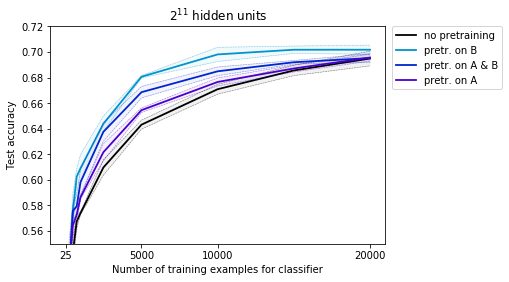

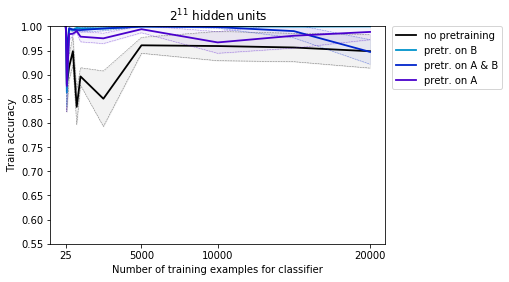

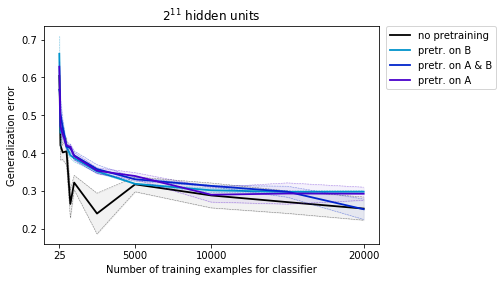

In [9]:
results_test[n_hus[2]], results_train[n_hus[2]], results_generr[n_hus[2]] = do_all_hl(n_hus[2])

#### Training for 8192 hu
## No Pre-Training
test_accuracies_B = [(0.39093333333333335, 0.016468420959183945), (0.4261333333333333, 0.020708345070419205), (0.4408666666666667, 0.01621713771155549), (0.5168666666666667, 0.014286901537966709), (0.5510666666666667, 0.0029318177903061046), (0.569, 0.004868949236402741), (0.5768, 0.0040431011200150494), (0.6058666666666667, 0.004413111776916091), (0.6326666666666667, 0.004401009985093048), (0.6715333333333332, 0.0028767265347188526), (0.6880000000000001, 0.0017048949136725885), (0.6962666666666667, 0.001463633226673339)]
train_accuracies_B = [(1.0, 0.0), (0.9866666666666667, 0.018856180831641284), (0.86, 0.11860297916438133), (0.8773333333333334, 0.1029865147590801), (0.9226666666666666, 0.04631294515455574), (0.9053333333333334, 0.013063945294843629), (0.8879999999999999, 0.0659140854951858), (0.8921333333333333, 0.05611638699069008), (0.916, 0.06428457565129186), (0.9748000000000001, 0.03493145669259538), (0.9862000000000001, 0.0191391009

[epoch 14] loss: 0.5300792
Test set: Average loss: 1.3819, Accuracy: 2039/5000 (41%)
[epoch 15] loss: 0.5113301
Test set: Average loss: 1.3813, Accuracy: 2033/5000 (41%)
[epoch 16] loss: 0.4939744
Test set: Average loss: 1.3816, Accuracy: 2007/5000 (40%)
[epoch 17] loss: 0.4780592
Test set: Average loss: 1.3826, Accuracy: 1988/5000 (40%)
[epoch 18] loss: 0.4617316
Test set: Average loss: 1.3840, Accuracy: 1965/5000 (39%)
[epoch 19] loss: 0.4449934
Test set: Average loss: 1.3855, Accuracy: 1931/5000 (39%)
[epoch 20] loss: 0.4306548
Test set: Average loss: 1.3865, Accuracy: 1905/5000 (38%)
[epoch 21] loss: 0.4200281
Test set: Average loss: 1.3868, Accuracy: 1910/5000 (38%)
[epoch 22] loss: 0.4114937
Test set: Average loss: 1.3862, Accuracy: 1904/5000 (38%)
[epoch 23] loss: 0.4035996
Test set: Average loss: 1.3851, Accuracy: 1906/5000 (38%)
[epoch 24] loss: 0.3962035
Test set: Average loss: 1.3835, Accuracy: 1907/5000 (38%)
[epoch 25] loss: 0.3889985
Test set: Average loss: 1.3817, Accura

[epoch 22] loss: 0.4991602
Epoch    21: reducing learning rate of group 0 to 5.0000e-11.
Test set: Average loss: 1.3329, Accuracy: 2216/5000 (44%)
[epoch 23] loss: 0.4916634
Epoch    22: reducing learning rate of group 0 to 5.0000e-12.
Test set: Average loss: 1.3329, Accuracy: 2216/5000 (44%)
[epoch 24] loss: 0.4986034
Epoch    23: reducing learning rate of group 0 to 5.0000e-13.
Test set: Average loss: 1.3329, Accuracy: 2216/5000 (44%)
[epoch 25] loss: 0.4862083
Test set: Average loss: 1.3329, Accuracy: 2216/5000 (44%)
Validation:
Test set: Average loss: 1.3329, Accuracy: 2216/5000 (44%)
Test
Test set: Average loss: 1.3495, Accuracy: 2229/5000 (45%)
Test set: Average loss: 0.5021, Accuracy: 50/50 (100%)
## seed: 12
Validation accuracy before training:
Test set: Average loss: 1.7747, Accuracy: 704/5000 (14%)
[epoch 1] loss: 1.7139125
Test set: Average loss: 1.6692, Accuracy: 981/5000 (20%)
[epoch 2] loss: 1.2970801
Test set: Average loss: 1.5691, Accuracy: 1368/5000 (27%)
[epoch 3] los

Test set: Average loss: 1.4226, Accuracy: 1928/5000 (39%)
[epoch 16] loss: 0.8013330
Epoch    15: reducing learning rate of group 0 to 5.0000e-13.
Test set: Average loss: 1.4226, Accuracy: 1928/5000 (39%)
[epoch 17] loss: 0.7896908
Epoch    16: reducing learning rate of group 0 to 5.0000e-14.
Test set: Average loss: 1.4226, Accuracy: 1928/5000 (39%)
[epoch 18] loss: 0.7484100
Epoch    17: reducing learning rate of group 0 to 5.0000e-15.
Test set: Average loss: 1.4226, Accuracy: 1928/5000 (39%)
[epoch 19] loss: 0.7569707
Epoch    18: reducing learning rate of group 0 to 5.0000e-16.
Test set: Average loss: 1.4226, Accuracy: 1928/5000 (39%)
[epoch 20] loss: 0.7121266
Epoch    19: reducing learning rate of group 0 to 5.0000e-17.
Test set: Average loss: 1.4226, Accuracy: 1928/5000 (39%)
[epoch 21] loss: 0.7790699
Epoch    20: reducing learning rate of group 0 to 5.0000e-18.
Test set: Average loss: 1.4226, Accuracy: 1928/5000 (39%)
[epoch 22] loss: 0.6934247
Test set: Average loss: 1.4226, A

[epoch 3] loss: 0.9219168
Test set: Average loss: 1.2448, Accuracy: 2575/5000 (52%)
[epoch 4] loss: 0.8060532
Test set: Average loss: 1.2278, Accuracy: 2633/5000 (53%)
[epoch 5] loss: 0.7275382
Test set: Average loss: 1.2237, Accuracy: 2628/5000 (53%)
[epoch 6] loss: 0.6696231
Test set: Average loss: 1.2151, Accuracy: 2649/5000 (53%)
[epoch 7] loss: 0.6240587
Test set: Average loss: 1.2063, Accuracy: 2691/5000 (54%)
[epoch 8] loss: 0.5863120
Test set: Average loss: 1.2066, Accuracy: 2641/5000 (53%)
[epoch 9] loss: 0.5529956
Test set: Average loss: 1.2038, Accuracy: 2652/5000 (53%)
[epoch 10] loss: 0.5231005
Test set: Average loss: 1.1960, Accuracy: 2693/5000 (54%)
[epoch 11] loss: 0.4980751
Test set: Average loss: 1.1935, Accuracy: 2709/5000 (54%)
[epoch 12] loss: 0.4781616
Test set: Average loss: 1.1949, Accuracy: 2689/5000 (54%)
[epoch 13] loss: 0.4609141
Test set: Average loss: 1.1939, Accuracy: 2672/5000 (53%)
[epoch 14] loss: 0.4437665
Test set: Average loss: 1.1912, Accuracy: 271

Test set: Average loss: 1.1238, Accuracy: 2868/5000 (57%)
[epoch 15] loss: 0.4143879
Test set: Average loss: 1.1240, Accuracy: 2857/5000 (57%)
[epoch 16] loss: 0.3931911
Test set: Average loss: 1.1202, Accuracy: 2884/5000 (58%)
[epoch 17] loss: 0.3765260
Test set: Average loss: 1.1158, Accuracy: 2884/5000 (58%)
[epoch 18] loss: 0.3600753
Test set: Average loss: 1.1146, Accuracy: 2875/5000 (58%)
[epoch 19] loss: 0.3435128
Test set: Average loss: 1.1098, Accuracy: 2893/5000 (58%)
[epoch 20] loss: 0.3321747
Test set: Average loss: 1.1068, Accuracy: 2889/5000 (58%)
[epoch 21] loss: 0.3181250
Test set: Average loss: 1.1100, Accuracy: 2876/5000 (58%)
[epoch 22] loss: 0.3061457
Test set: Average loss: 1.1035, Accuracy: 2902/5000 (58%)
[epoch 23] loss: 0.2952078
Test set: Average loss: 1.1078, Accuracy: 2894/5000 (58%)
[epoch 24] loss: 0.2829635
Test set: Average loss: 1.1034, Accuracy: 2891/5000 (58%)
[epoch 25] loss: 0.2735777
Test set: Average loss: 1.1023, Accuracy: 2892/5000 (58%)
Validat

Test set: Average loss: 1.0746, Accuracy: 3070/5000 (61%)
Test
Test set: Average loss: 1.0788, Accuracy: 3055/5000 (61%)
Test set: Average loss: 0.3965, Accuracy: 740/750 (99%)
## seed: 12
Validation accuracy before training:
Test set: Average loss: 1.7398, Accuracy: 852/5000 (17%)
[epoch 1] loss: 1.5095091
Test set: Average loss: 1.3235, Accuracy: 2495/5000 (50%)
[epoch 2] loss: 1.1426258
Test set: Average loss: 1.2495, Accuracy: 2780/5000 (56%)
[epoch 3] loss: 0.9824766
Test set: Average loss: 1.2096, Accuracy: 2865/5000 (57%)
[epoch 4] loss: 0.8757612
Test set: Average loss: 1.1997, Accuracy: 2869/5000 (57%)
[epoch 5] loss: 0.7872293
Test set: Average loss: 1.1810, Accuracy: 2919/5000 (58%)
[epoch 6] loss: 0.7161169
Test set: Average loss: 1.1648, Accuracy: 2932/5000 (59%)
[epoch 7] loss: 0.6550682
Test set: Average loss: 1.1571, Accuracy: 2936/5000 (59%)
[epoch 8] loss: 0.6033073
Test set: Average loss: 1.1432, Accuracy: 2960/5000 (59%)
[epoch 9] loss: 0.5653768
Test set: Average l

[epoch 9] loss: 0.4966340
Test set: Average loss: 1.0689, Accuracy: 3082/5000 (62%)
[epoch 10] loss: 0.4551820
Test set: Average loss: 1.0647, Accuracy: 3074/5000 (61%)
[epoch 11] loss: 0.4236969
Test set: Average loss: 1.0638, Accuracy: 3078/5000 (62%)
[epoch 12] loss: 0.3949584
Test set: Average loss: 1.0540, Accuracy: 3093/5000 (62%)
[epoch 13] loss: 0.3686583
Test set: Average loss: 1.0536, Accuracy: 3120/5000 (62%)
[epoch 14] loss: 0.3433082
Test set: Average loss: 1.0467, Accuracy: 3109/5000 (62%)
[epoch 15] loss: 0.3208977
Test set: Average loss: 1.0456, Accuracy: 3106/5000 (62%)
[epoch 16] loss: 0.3047572
Test set: Average loss: 1.0475, Accuracy: 3105/5000 (62%)
[epoch 17] loss: 0.2879757
Test set: Average loss: 1.0435, Accuracy: 3099/5000 (62%)
[epoch 18] loss: 0.2717665
Test set: Average loss: 1.0451, Accuracy: 3096/5000 (62%)
[epoch 19] loss: 0.2555903
Test set: Average loss: 1.0429, Accuracy: 3113/5000 (62%)
[epoch 20] loss: 0.2414798
Test set: Average loss: 1.0442, Accurac

Test set: Average loss: 0.9573, Accuracy: 3263/5000 (65%)
[epoch 21] loss: 0.1106268
Test set: Average loss: 0.9529, Accuracy: 3277/5000 (66%)
[epoch 22] loss: 0.1010051
Test set: Average loss: 0.9593, Accuracy: 3265/5000 (65%)
[epoch 23] loss: 0.0918497
Test set: Average loss: 0.9600, Accuracy: 3267/5000 (65%)
[epoch 24] loss: 0.0840853
Test set: Average loss: 0.9681, Accuracy: 3250/5000 (65%)
[epoch 25] loss: 0.0778875
Test set: Average loss: 0.9701, Accuracy: 3252/5000 (65%)
Validation:
Test set: Average loss: 0.9529, Accuracy: 3277/5000 (66%)
Test
Test set: Average loss: 0.9788, Accuracy: 3224/5000 (64%)
Test set: Average loss: 0.1018, Accuracy: 2498/2500 (100%)
## seed: 13
Validation accuracy before training:
Test set: Average loss: 1.7487, Accuracy: 585/5000 (12%)
[epoch 1] loss: 1.1981460
Test set: Average loss: 1.1291, Accuracy: 2924/5000 (58%)
[epoch 2] loss: 0.9365107
Test set: Average loss: 1.0815, Accuracy: 3063/5000 (61%)
[epoch 3] loss: 0.8165728
Test set: Average loss: 1

[epoch 3] loss: 0.6928353
Test set: Average loss: 0.9664, Accuracy: 3281/5000 (66%)
[epoch 4] loss: 0.5844131
Test set: Average loss: 0.9406, Accuracy: 3330/5000 (67%)
[epoch 5] loss: 0.4886504
Test set: Average loss: 0.9285, Accuracy: 3361/5000 (67%)
[epoch 6] loss: 0.4062390
Test set: Average loss: 0.9108, Accuracy: 3359/5000 (67%)
[epoch 7] loss: 0.3354412
Test set: Average loss: 0.9071, Accuracy: 3335/5000 (67%)
[epoch 8] loss: 0.2793456
Test set: Average loss: 0.8988, Accuracy: 3376/5000 (68%)
[epoch 9] loss: 0.2291831
Test set: Average loss: 0.8952, Accuracy: 3379/5000 (68%)
[epoch 10] loss: 0.1889918
Test set: Average loss: 0.8948, Accuracy: 3381/5000 (68%)
[epoch 11] loss: 0.1563231
Test set: Average loss: 0.8934, Accuracy: 3402/5000 (68%)
[epoch 12] loss: 0.1290333
Test set: Average loss: 0.8946, Accuracy: 3408/5000 (68%)
[epoch 13] loss: 0.1071584
Test set: Average loss: 0.9033, Accuracy: 3376/5000 (68%)
[epoch 14] loss: 0.0910571
Test set: Average loss: 0.9214, Accuracy: 337

Test set: Average loss: 0.9263, Accuracy: 3458/5000 (69%)
[epoch 15] loss: 0.0726841
Epoch    14: reducing learning rate of group 0 to 5.0000e-06.
Test set: Average loss: 0.9751, Accuracy: 3377/5000 (68%)
[epoch 16] loss: 0.0412458
Test set: Average loss: 0.9230, Accuracy: 3465/5000 (69%)
[epoch 17] loss: 0.0331605
Test set: Average loss: 0.9229, Accuracy: 3474/5000 (69%)
[epoch 18] loss: 0.0305236
Test set: Average loss: 0.9234, Accuracy: 3480/5000 (70%)
[epoch 19] loss: 0.0286479
Test set: Average loss: 0.9240, Accuracy: 3480/5000 (70%)
[epoch 20] loss: 0.0270620
Test set: Average loss: 0.9254, Accuracy: 3481/5000 (70%)
[epoch 21] loss: 0.0256574
Test set: Average loss: 0.9253, Accuracy: 3484/5000 (70%)
[epoch 22] loss: 0.0243526
Test set: Average loss: 0.9299, Accuracy: 3482/5000 (70%)
[epoch 23] loss: 0.0231459
Test set: Average loss: 0.9301, Accuracy: 3486/5000 (70%)
[epoch 24] loss: 0.0219894
Test set: Average loss: 0.9338, Accuracy: 3496/5000 (70%)
[epoch 25] loss: 0.0209139
Tes

[epoch 22] loss: 0.0096467
Test set: Average loss: 1.0818, Accuracy: 3490/5000 (70%)
[epoch 23] loss: 0.0094029
Test set: Average loss: 1.0825, Accuracy: 3491/5000 (70%)
[epoch 24] loss: 0.0091756
Test set: Average loss: 1.0827, Accuracy: 3488/5000 (70%)
[epoch 25] loss: 0.0089323
Test set: Average loss: 1.0824, Accuracy: 3486/5000 (70%)
Validation:
Test set: Average loss: 0.8465, Accuracy: 3514/5000 (70%)
Test
Test set: Average loss: 0.8629, Accuracy: 3438/5000 (69%)
Test set: Average loss: 0.1285, Accuracy: 14849/15000 (99%)
20000
## seed: 11
Validation accuracy before training:
Test set: Average loss: 1.7773, Accuracy: 613/5000 (12%)
[epoch 1] loss: 1.1049775
Test set: Average loss: 1.0055, Accuracy: 3222/5000 (64%)
[epoch 2] loss: 0.8412517
Test set: Average loss: 0.9135, Accuracy: 3417/5000 (68%)
[epoch 3] loss: 0.6793115
Test set: Average loss: 0.8579, Accuracy: 3487/5000 (70%)
[epoch 4] loss: 0.5370532
Test set: Average loss: 0.8221, Accuracy: 3509/5000 (70%)
[epoch 5] loss: 0.4

n_training_examples = [25, 50, 100, 250, 500, 750, 1000, 2500, 5000, 10000, 15000, 20000]
train_accuracies = {'B': [(1.0, 0.0), (0.9866666666666667, 0.018856180831641284), (0.86, 0.11860297916438133), (0.8773333333333334, 0.1029865147590801), (0.9226666666666666, 0.04631294515455574), (0.9053333333333334, 0.013063945294843629), (0.8879999999999999, 0.0659140854951858), (0.8921333333333333, 0.05611638699069008), (0.916, 0.06428457565129186), (0.9748000000000001, 0.03493145669259538), (0.9862000000000001, 0.019139100950284645), (0.9996499999999999, 4.0824829046381805e-05)], 'AnB': [(1.0, 0.0), (0.9733333333333333, 0.009428090415820642), (0.9033333333333333, 0.023570226039551605), (0.9893333333333333, 0.0018856180831641283), (0.988, 0.002828427124746193), (0.9795555555555556, 0.012988123729957734), (0.988, 0.00509901951359279), (0.9966666666666666, 0.0019955506062794433), (0.9996, 0.0002828427124746402), (0.9993333333333334, 0.0008730533902472614), (0.9895111111111111, 0.00961670357525493

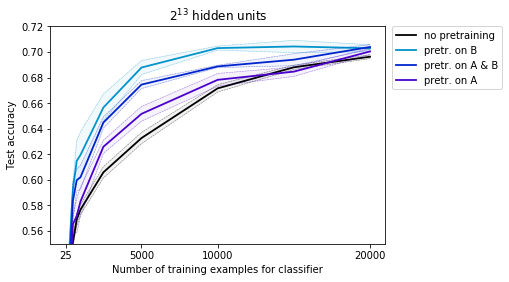

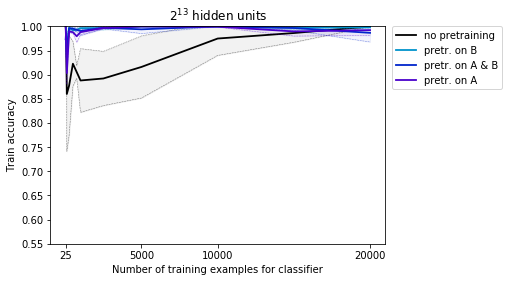

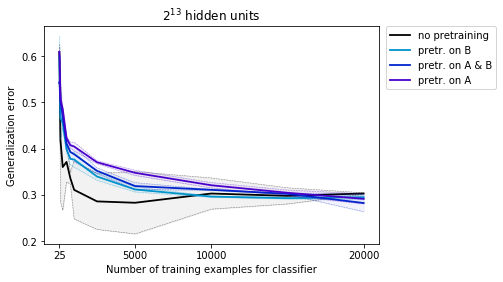

In [8]:
results_test[n_hus[3]], results_train[n_hus[3]], results_generr[n_hus[3]] = do_all_hl(n_hus[3])

n_training_examples = [25, 50, 100, 250, 500, 750, 1000, 2500, 5000, 10000, 15000, 20000]
test_accuracies = {'B': [(0.38139999999999996, 0.015809701662797656), (0.3970666666666666, 0.028842715236645496), (0.4288666666666667, 0.02155880846016826), (0.5150666666666667, 0.006661998365522331), (0.5502, 0.004140853374205232), (0.564, 0.0058057442818872425), (0.5720666666666666, 0.00338755893757666), (0.6050666666666668, 0.0020154955277108012), (0.6286, 0.0027276363393971886), (0.6593333333333334, 0.0024783507060588098), (0.6668666666666666, 0.004847909056719406), (0.6729333333333333, 0.000984321537348923)], 'AnB': [(0.30119999999999997, 0.015047480409246826), (0.2637333333333333, 0.02428515779007599), (0.2998, 0.02618549216646502), (0.48546666666666666, 0.013450485327881496), (0.5288, 0.015036843640427585), (0.5560666666666667, 0.008980472642845102), (0.5705333333333332, 0.0017987650084309492), (0.6044666666666667, 0.002379542439676599), (0.6376666666666667, 0.0009977753031397067), (0.65286

n_training_examples = [25, 50, 100, 250, 500, 750, 1000, 2500, 5000, 10000, 15000, 20000]
generr_accuracies = {'B': [(0.6204, 0.011717792738680198), (0.5763333333333333, 0.027517913357585015), (0.3626666666666667, 0.05379475397801867), (0.3708, 0.02524915840181612), (0.35666666666666674, 0.03557764591550276), (0.2902222222222222, 0.0449131287687962), (0.27399999999999997, 0.033104682448257955), (0.3113333333333333, 0.02198019310399453), (0.29219999999999996, 0.05496350304217032), (0.2677, 0.036947801017110656), (0.2327111111111111, 0.03228329843780977), (0.20945, 0.029179016433046497)], 'AnB': [(0.6689333333333334, 0.06135304031224173), (0.5663333333333332, 0.02513819581610603), (0.3408, 0.10804307782855258), (0.44766666666666666, 0.005377318621353532), (0.4073333333333333, 0.003564017707899665), (0.3849333333333333, 0.01156354424713961), (0.36979999999999996, 0.011880516262632135), (0.3346, 0.026420194296535103), (0.3298666666666667, 0.007611103000806688), (0.26533333333333337, 0.0134

n_training_examples = [25, 50, 100, 250, 500, 750, 1000, 2500, 5000, 10000, 15000, 20000]
test_accuracies = {'B': [(0.39093333333333335, 0.016468420959183945), (0.4261333333333333, 0.020708345070419205), (0.4408666666666667, 0.01621713771155549), (0.5168666666666667, 0.014286901537966709), (0.5510666666666667, 0.0029318177903061046), (0.569, 0.004868949236402741), (0.5768, 0.0040431011200150494), (0.6058666666666667, 0.004413111776916091), (0.6326666666666667, 0.004401009985093048), (0.6715333333333332, 0.0028767265347188526), (0.6880000000000001, 0.0017048949136725885), (0.6962666666666667, 0.001463633226673339)], 'AnB': [(0.39093333333333335, 0.009721911106133184), (0.3781999999999999, 0.025556734272333518), (0.3970666666666667, 0.007950401806757264), (0.5034, 0.0024055491403558254), (0.5653333333333334, 0.005881798666696727), (0.5717333333333333, 0.013462375553948682), (0.5832, 0.011329018786579301), (0.6258666666666666, 0.0051493257379540275), (0.6516000000000001, 0.005741080037762

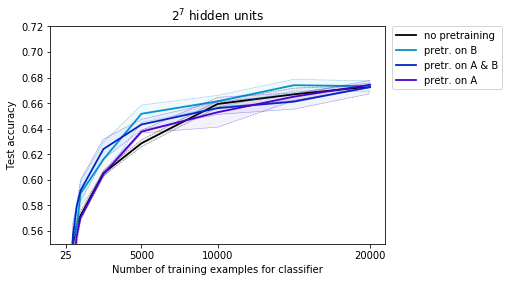

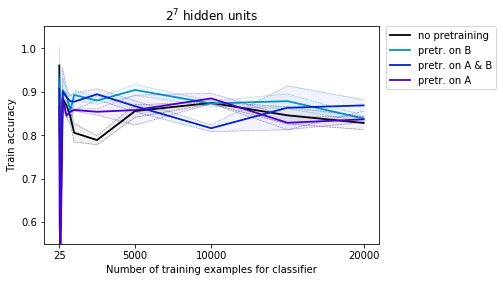

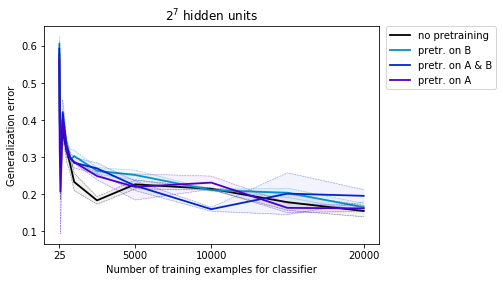

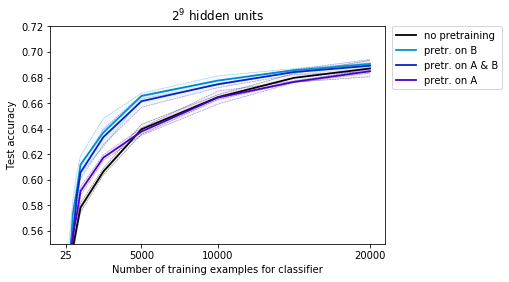

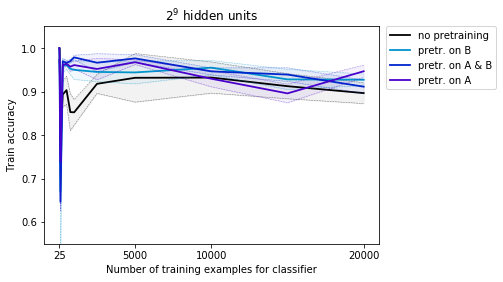

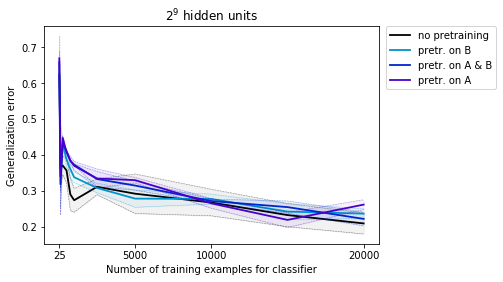

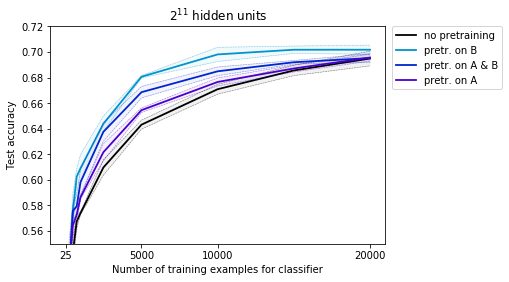

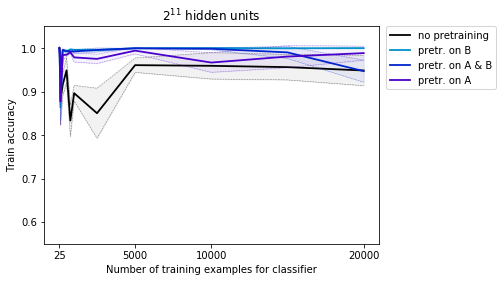

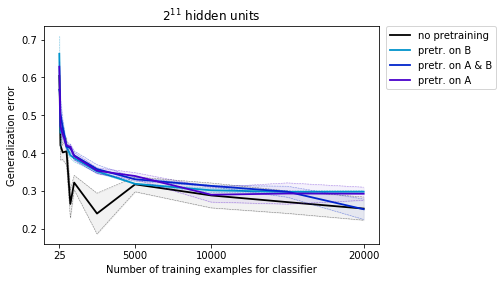

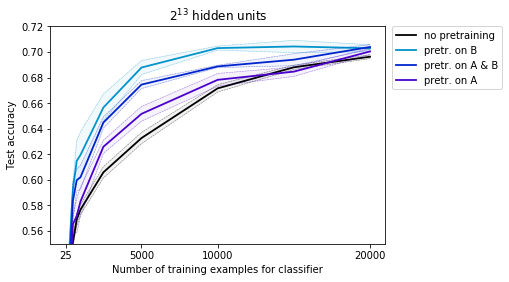

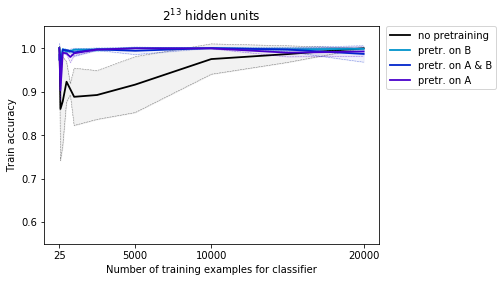

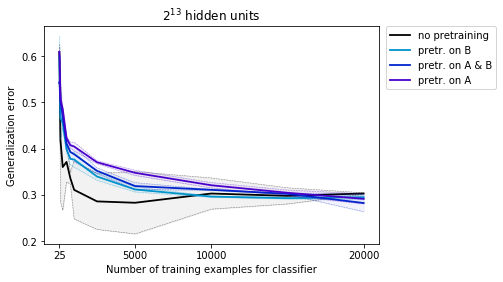

In [7]:
results_test = {}
results_train = {}
results_generr = {}
n_hus = [7, 9, 11, 13]
n_training_examples = [25, 50, 100, 250, 500, 750, 1000, 2500, 5000, 10000, 15000, 20000]
results_test[7] = {'B': [(0.38139999999999996, 0.015809701662797656), (0.3970666666666666, 0.028842715236645496), (0.4288666666666667, 0.02155880846016826), (0.5150666666666667, 0.006661998365522331), (0.5502, 0.004140853374205232), (0.564, 0.0058057442818872425), (0.5720666666666666, 0.00338755893757666), (0.6050666666666668, 0.0020154955277108012), (0.6286, 0.0027276363393971886), (0.6593333333333334, 0.0024783507060588098), (0.6668666666666666, 0.004847909056719406), (0.6729333333333333, 0.000984321537348923)], 'AnB': [(0.30119999999999997, 0.015047480409246826), (0.2637333333333333, 0.02428515779007599), (0.2998, 0.02618549216646502), (0.48546666666666666, 0.013450485327881496), (0.5288, 0.015036843640427585), (0.5560666666666667, 0.008980472642845102), (0.5705333333333332, 0.0017987650084309492), (0.6044666666666667, 0.002379542439676599), (0.6376666666666667, 0.0009977753031397067), (0.6528666666666667, 0.01166799992381823), (0.665, 0.0030594117081556606), (0.6743333333333333, 0.0014817407180595414)], 'BnB': [(0.3277333333333334, 0.04855576404735305), (0.3639333333333333, 0.03589961312078758), (0.32993333333333336, 0.04530322529602303), (0.5082, 0.018244999314880782), (0.5541333333333334, 0.004135483311805577), (0.5622, 0.0044751163858235635), (0.5892666666666666, 0.009309970760188007), (0.616, 0.013465016400534649), (0.6516666666666667, 0.006816320284598008), (0.6614, 0.004667618950457102), (0.674, 0.004581120678029189), (0.6732, 0.004169732205629844)], 'ABnB': [(0.31373333333333336, 0.03327474851728993), (0.3403333333333333, 0.04302691664011676), (0.3038666666666667, 0.01627786499787022), (0.47846666666666665, 0.01972499823968447), (0.5561333333333334, 0.010847221866552884), (0.5794666666666667, 0.0017913371790059629), (0.5916666666666667, 0.008249983164965972), (0.6240666666666667, 0.007838934167914001), (0.6432666666666667, 0.004148359782961093), (0.6560666666666667, 0.00489988662000346), (0.6611333333333334, 0.005879531349426478), (0.6725333333333333, 0.005195724738239637)]}
results_train[7] = {'B': [(0.96, 0.0), (0.8133333333333334, 0.09568466729604881), (0.7266666666666666, 0.10274023338281628), (0.884, 0.021416504538945367), (0.868, 0.028612351645166605), (0.843111111111111, 0.018260123185932547), (0.8053333333333333, 0.020885933597094022), (0.7885333333333334, 0.01053417718138861), (0.8553333333333333, 0.01441881486885179), (0.8739333333333335, 0.0022866763848190196), (0.8454444444444444, 0.019579303761943886), (0.8278, 0.01500216651020777)], 'AnB': [(0.8666666666666667, 0.03771236166328257), (0.5933333333333334, 0.06599663291074445), (0.5066666666666667, 0.14007934259633795), (0.884, 0.008640987597877155), (0.8446666666666666, 0.0033993463423951926), (0.8537777777777777, 0.012757955639473177), (0.8576666666666667, 0.0020548046676563273), (0.8536, 0.007382863039950467), (0.8575333333333334, 0.034228383283792733), (0.8843, 0.0119132978921316), (0.8282444444444444, 0.015601456089056711), (0.83625, 0.006368673331236242)], 'BnB': [(0.9333333333333332, 0.0679869268479038), (0.7599999999999999, 0.08640987597877146), (0.6233333333333334, 0.07408703590297622), (0.9026666666666667, 0.02815828277592381), (0.8886666666666666, 0.01309792180292568), (0.8564444444444445, 0.03159621793275771), (0.8923333333333333, 0.01108552609887727), (0.8793333333333333, 0.008199728992811604), (0.9037333333333333, 0.012505287770468238), (0.8726333333333334, 0.006136955452194726), (0.8780666666666667, 0.016776438504309803), (0.83805, 0.007347221697122431)], 'ABnB': [(0.9066666666666667, 0.018856180831641284), (0.8266666666666667, 0.12472191289246469), (0.5800000000000001, 0.024494897427831758), (0.8999999999999999, 0.052255781179374475), (0.8873333333333333, 0.018354533197248286), (0.8777777777777778, 0.012570787221094207), (0.8766666666666666, 0.02007209228976615), (0.8938666666666667, 0.01254042352642931), (0.8664666666666667, 0.012805554350445834), (0.8157666666666668, 0.0076027772703284235), (0.8628444444444444, 0.05040383093416119), (0.8682500000000001, 0.01304243075503953)]}
results_generr[7] = {'B': [(0.5785999999999999, 0.01580970166279762), (0.41626666666666673, 0.08286476264908316), (0.2978, 0.11273520597695588), (0.3689333333333334, 0.017408299425529454), (0.31779999999999997, 0.029272512703900275), (0.27911111111111114, 0.02388548813003148), (0.23326666666666665, 0.023383945109602167), (0.18346666666666667, 0.009898596982513297), (0.22673333333333334, 0.011763597333393444), (0.2146, 0.0026545558322752525), (0.17857777777777775, 0.02168695346555812), (0.15486666666666668, 0.015512593450340768)], 'AnB': [(0.5654666666666667, 0.047951178875555896), (0.32960000000000006, 0.0453381370003959), (0.20686666666666664, 0.11389425895198675), (0.39853333333333335, 0.009069117315863153), (0.31586666666666663, 0.016877861897237556), (0.2977111111111111, 0.003783916580919545), (0.28713333333333335, 0.0029948103260288234), (0.24913333333333332, 0.009661377863546252), (0.21986666666666665, 0.035202398908155214), (0.2314333333333333, 0.01755492966535486), (0.1632444444444444, 0.012844405997635646), (0.16191666666666668, 0.007570703768841816)], 'BnB': [(0.6056, 0.020835226580641374), (0.3960666666666666, 0.10202343957259145), (0.29340000000000005, 0.02878934988266783), (0.3944666666666666, 0.031102554378843017), (0.33453333333333335, 0.013227580613584988), (0.29424444444444436, 0.027780746508026196), (0.3030666666666667, 0.016016935481615154), (0.26333333333333336, 0.00874274302239036), (0.25206666666666666, 0.013007006658805921), (0.21123333333333336, 0.0021746008573733737), (0.20406666666666665, 0.01234215900435936), (0.16484999999999997, 0.010358651778424956)], 'ABnB': [(0.5929333333333334, 0.015595155943076928), (0.4863333333333333, 0.1114060840149924), (0.27613333333333334, 0.030934913752730685), (0.4215333333333333, 0.03401581331609691), (0.3312, 0.012251802588462915), (0.29831111111111114, 0.013201159694661378), (0.285, 0.01393700111214749), (0.2698, 0.014795494809794866), (0.22320000000000004, 0.01304760514424008), (0.15969999999999998, 0.00540431926024606), (0.2017111111111111, 0.05628268158957581), (0.19571666666666668, 0.016842423288298585)]}
results_test[9] = {'B': [(0.3796, 0.011717792738680202), (0.42366666666666664, 0.027517913357585015), (0.4106666666666667, 0.01702573215916296), (0.5225333333333332, 0.005060522590492886), (0.5466666666666666, 0.0066659999666633185), (0.5626666666666668, 0.0024513035081133666), (0.5783333333333334, 0.0037606146069787886), (0.6065333333333333, 0.0025368396787253896), (0.6395333333333334, 0.00389643711898734), (0.6646, 0.0019252705437591683), (0.6797333333333334, 0.0034344658326376553), (0.6870666666666668, 0.006450495243691641)], 'AnB': [(0.3310666666666667, 0.06135304031224171), (0.40700000000000003, 0.011032074449833378), (0.3992, 0.01604078136085231), (0.5136666666666666, 0.0051233669484909115), (0.5566666666666666, 0.005648205221326715), (0.5724, 0.009717338455907925), (0.5912000000000001, 0.003398038649966567), (0.6174000000000001, 0.002141650453894527), (0.6377333333333334, 0.0028110891523077173), (0.6642666666666667, 0.005123366948490894), (0.6766, 0.000711805216802113), (0.6849333333333333, 0.001359738536958064)], 'BnB': [(0.3738666666666666, 0.026759338972071448), (0.3806, 0.07365233646441004), (0.29960000000000003, 0.07994014427474264), (0.5282666666666667, 0.02442803489617798), (0.5736666666666667, 0.010951204905803258), (0.5918666666666667, 0.013521669850856281), (0.612, 0.006981881312845877), (0.637, 0.011028448062473106), (0.6655333333333333, 0.0021929178937864684), (0.6776, 0.0036914315199752224), (0.6856666666666666, 0.0013199326582148817), (0.6906, 0.0007483314773547949)], 'ABnB': [(0.31553333333333333, 0.046238319846445775), (0.40746666666666664, 0.039548900813493604), (0.3278666666666667, 0.018853352192352662), (0.5367999999999999, 0.00940354543066959), (0.555, 0.006211816696157946), (0.5867333333333333, 0.0038447655614123094), (0.6058, 0.004572380853195241), (0.6334666666666666, 0.00608896999134954), (0.6614666666666666, 0.004781445620544274), (0.6747333333333333, 0.00270472837001346), (0.6842666666666668, 0.0019482185594936858), (0.6891999999999999, 0.004907137658554093)]}
results_train[9] = {'B': [(1.0, 0.0), (1.0, 0.0), (0.7733333333333333, 0.036817870057290855), (0.8933333333333334, 0.029454296045832724), (0.9033333333333333, 0.03222145592958555), (0.8528888888888888, 0.04246247435554199), (0.8523333333333335, 0.029408993333483676), (0.9178666666666667, 0.02187560792806049), (0.9317333333333333, 0.05591429950280063), (0.9323, 0.03580735492418657), (0.9124444444444443, 0.02888574341850157), (0.8965166666666667, 0.02395253408073741)], 'AnB': [(1.0, 0.0), (0.9733333333333333, 0.024944382578492966), (0.7400000000000001, 0.11430952132988166), (0.9613333333333333, 0.010498677165349092), (0.964, 0.0043204937989385775), (0.9573333333333333, 0.011469767022723513), (0.961, 0.008485281374238578), (0.9520000000000001, 0.024638181751095185), (0.9676, 0.005217917847826523), (0.9296000000000001, 0.018524038436582877), (0.8958666666666666, 0.021404257105123347), (0.9467333333333334, 0.014000317456718196)], 'BnB': [(1.0, 0.0), (0.96, 0.0), (0.6699999999999999, 0.19646882704388502), (0.9586666666666667, 0.016110727964792727), (0.9613333333333333, 0.009285592184789422), (0.9524444444444443, 0.013524554715291503), (0.9500000000000001, 0.021924111536540437), (0.9452000000000002, 0.022302167308731857), (0.9440666666666666, 0.026053449334439843), (0.9550000000000001, 0.01651686007286694), (0.9281111111111112, 0.023180728479482826), (0.9272833333333333, 0.01320961350263089)], 'ABnB': [(0.9733333333333333, 0.018856180831641284), (0.9333333333333332, 0.0410960933531265), (0.6466666666666666, 0.004714045207910321), (0.9693333333333333, 0.007542472332656513), (0.9659999999999999, 0.005887840577551903), (0.9702222222222222, 0.0034995590551163513), (0.9786666666666667, 0.004988876515698593), (0.9664000000000001, 0.02067913602321593), (0.9763333333333333, 0.008730533902472538), (0.9465, 0.008041558721209886), (0.9391333333333334, 0.015607120881899457), (0.9113000000000001, 0.015426114222317976)]}
results_generr[9] = {'B': [(0.6204, 0.011717792738680198), (0.5763333333333333, 0.027517913357585015), (0.3626666666666667, 0.05379475397801867), (0.3708, 0.02524915840181612), (0.35666666666666674, 0.03557764591550276), (0.2902222222222222, 0.0449131287687962), (0.27399999999999997, 0.033104682448257955), (0.3113333333333333, 0.02198019310399453), (0.29219999999999996, 0.05496350304217032), (0.2677, 0.036947801017110656), (0.2327111111111111, 0.03228329843780977), (0.20945, 0.029179016433046497)], 'AnB': [(0.6689333333333334, 0.06135304031224173), (0.5663333333333332, 0.02513819581610603), (0.3408, 0.10804307782855258), (0.44766666666666666, 0.005377318621353532), (0.4073333333333333, 0.003564017707899665), (0.3849333333333333, 0.01156354424713961), (0.36979999999999996, 0.011880516262632135), (0.3346, 0.026420194296535103), (0.3298666666666667, 0.007611103000806688), (0.26533333333333337, 0.013469554145883545), (0.21926666666666664, 0.020996719320461068), (0.26180000000000003, 0.013577432256014632)], 'BnB': [(0.6261333333333333, 0.02675933897207146), (0.5794, 0.07365233646441006), (0.3704, 0.11860196738109649), (0.43039999999999995, 0.009471360338761668), (0.3876666666666666, 0.020011552219211363), (0.3605777777777777, 0.024778744375765036), (0.3379999999999999, 0.015022649566571124), (0.3082, 0.013067006798294206), (0.27853333333333335, 0.02400574005431945), (0.27740000000000004, 0.013704743704279897), (0.24244444444444438, 0.022279858589439747), (0.23668333333333333, 0.013587024038479558)], 'ABnB': [(0.6578, 0.03091536834650363), (0.5258666666666666, 0.020234843436233694), (0.31880000000000003, 0.02065332902948094), (0.4325333333333334, 0.00774481905677743), (0.411, 0.0012328828005937977), (0.3834888888888888, 0.0026790453431432266), (0.3728666666666666, 0.0022939534045447233), (0.33293333333333336, 0.021151096635609413), (0.3148666666666667, 0.012746066931497801), (0.27176666666666666, 0.005402057221302093), (0.25486666666666663, 0.017041387528276265), (0.2221, 0.01914379795129481)]}
results_test[11] = {'B': [(0.3959333333333333, 0.015245837318939073), (0.43520000000000003, 0.016085604330166342), (0.45920000000000005, 0.018982799231585065), (0.5140666666666667, 0.007433856483832747), (0.5437333333333333, 0.010451581485859219), (0.5674666666666667, 0.005504745427558125), (0.574, 0.0011430952132987942), (0.6096666666666667, 0.006069230227595209), (0.6431333333333332, 0.0035226252836327823), (0.6708666666666666, 0.0038964371189873204), (0.6855333333333333, 0.004030991055421564), (0.6948666666666666, 0.005751135153650588)], 'AnB': [(0.3717333333333333, 0.013455440865645719), (0.40066666666666667, 0.021669230617526673), (0.4056, 0.052545091746676646), (0.5340666666666666, 0.0020548046676563273), (0.5644, 0.00793137230664823), (0.573, 0.007657675887630638), (0.5863333333333333, 0.0011813363431112643), (0.6216, 0.006701243665668867), (0.6544666666666666, 0.0018061622912192382), (0.6765333333333334, 0.003159465496286095), (0.6870666666666666, 0.002714569742866955), (0.6956000000000001, 0.0026981475126464237)], 'BnB': [(0.3375333333333333, 0.04630603512382473), (0.391, 0.014958609561052133), (0.41, 0.053117981889375276), (0.5248666666666667, 0.014379924277346603), (0.5764, 0.01321009714826756), (0.6025333333333333, 0.005982938705649197), (0.6091333333333333, 0.010701194118207373), (0.6438, 0.00608166643829359), (0.6806, 0.0009092121131323798), (0.6980666666666666, 0.005564969801255778), (0.7017333333333333, 0.0028581268146968043), (0.7017333333333333, 0.003582674358011874)], 'ABnB': [(0.4324666666666667, 0.005073679357450793), (0.4316, 0.005283937925449163), (0.4403333333333333, 0.04460951567646627), (0.5295333333333333, 0.02288658025034661), (0.5757333333333333, 0.005208539995899874), (0.5793333333333334, 0.009076465293395983), (0.5982000000000001, 0.010007996802557421), (0.6375333333333333, 0.007350888079378957), (0.6685333333333333, 0.004502838610871549), (0.6848666666666666, 0.00338755893757666), (0.6919333333333334, 0.0013695092389449483), (0.6952000000000002, 0.00342928563989648)]}
results_train[11] = {'B': [(1.0, 0.0), (1.0, 0.0), (0.8799999999999999, 0.05715476066494078), (0.9159999999999999, 0.02592296279363143), (0.9486666666666667, 0.02945429604583268), (0.8333333333333334, 0.03623789708558135), (0.8963333333333333, 0.01811690432226827), (0.8502666666666667, 0.057476101313695765), (0.9608, 0.016485953617145332), (0.9592666666666667, 0.03031307015500446), (0.9562444444444443, 0.029333754205734884), (0.9485333333333333, 0.03489322602199778)], 'AnB': [(1.0, 0.0), (0.9866666666666667, 0.009428090415820642), (0.8766666666666666, 0.053124591501697384), (0.984, 0.013063945294843629), (0.9846666666666666, 0.003399346342395193), (0.9902222222222222, 0.002739739556875075), (0.9786666666666667, 0.010656244908763863), (0.9752000000000001, 0.010693300083073854), (0.9941333333333334, 0.007310874700669476), (0.9667666666666667, 0.02240927387390218), (0.9805777777777779, 0.025554260836768095), (0.9884833333333333, 0.016039551808645486)], 'BnB': [(1.0, 0.0), (0.9866666666666667, 0.018856180831641284), (0.8633333333333333, 0.02867441755680878), (0.9933333333333333, 0.004988876515698593), (0.9926666666666666, 0.003399346342395193), (0.9968888888888889, 0.001662958838566191), (0.996, 0.0016329931618554536), (0.9957333333333334, 0.002963481436119089), (0.9996666666666667, 0.00033993463423953233), (1.0, 0.0), (0.9996, 0.00047140452079103207), (0.99995, 7.071067811864697e-05)], 'ABnB': [(1.0, 0.0), (0.9933333333333333, 0.009428090415820642), (0.9466666666666667, 0.012472191289246433), (0.996, 0.0), (0.9933333333333333, 0.0009428090415820641), (0.9924444444444444, 0.002739739556875117), (0.9923333333333333, 0.0041096093353126546), (0.9956, 0.004811098280711651), (0.9996, 0.00016329931618557254), (0.9984333333333333, 0.0022156012477178664), (0.9901333333333334, 0.013859399805293255), (0.9471166666666667, 0.02540735895147091)]}
results_generr[11] = {'B': [(0.6040666666666666, 0.015245837318939099), (0.5648000000000001, 0.016085604330166387), (0.4208, 0.038837438981820925), (0.4019333333333333, 0.018954213838147507), (0.4049333333333333, 0.03624227120673068), (0.26586666666666664, 0.03686640546421431), (0.32233333333333336, 0.019108346053201178), (0.2406, 0.05382143315322125), (0.3176666666666667, 0.01961314751781459), (0.2884, 0.0328478309786202), (0.2707111111111111, 0.029696855218634587), (0.2536666666666667, 0.030609539181256713)], 'AnB': [(0.6282666666666666, 0.013455440865645693), (0.586, 0.03001110905425965), (0.4710666666666667, 0.012775323435783869), (0.44993333333333335, 0.012391753530294081), (0.42026666666666673, 0.011198015697236514), (0.4172222222222222, 0.005043318523392625), (0.39233333333333337, 0.009821518325708243), (0.35359999999999997, 0.007652450587883618), (0.33966666666666673, 0.008970073702162252), (0.29023333333333334, 0.01940177540558822), (0.2935111111111111, 0.028032908351030623), (0.29288333333333333, 0.01734763832789804)], 'BnB': [(0.6624666666666666, 0.04630603512382476), (0.5956666666666667, 0.00883075434049789), (0.45333333333333337, 0.039963427725303514), (0.46846666666666664, 0.014782271664245502), (0.41626666666666673, 0.01165885452730622), (0.39435555555555557, 0.007638951514894777), (0.3868666666666667, 0.009329999404549249), (0.3519333333333334, 0.004034297405441908), (0.31906666666666667, 0.0006182412330330306), (0.30193333333333333, 0.005564969801255778), (0.29786666666666667, 0.0024567367696917753), (0.29821666666666663, 0.0035138614403847105)], 'ABnB': [(0.5675333333333333, 0.005073679357450794), (0.5617333333333333, 0.0074481914284982974), (0.5063333333333333, 0.04265374804424834), (0.46646666666666664, 0.02288658025034661), (0.4176, 0.004270831300812501), (0.41311111111111104, 0.011157768704769599), (0.3941333333333333, 0.011763597333393456), (0.3580666666666667, 0.01167142760000773), (0.3310666666666667, 0.004596617113583523), (0.31356666666666666, 0.0015456030825826026), (0.2982000000000001, 0.01452854151381062), (0.2519166666666667, 0.02685393618985657)]}
results_test[13] = {'B': [(0.39093333333333335, 0.016468420959183945), (0.4261333333333333, 0.020708345070419205), (0.4408666666666667, 0.01621713771155549), (0.5168666666666667, 0.014286901537966709), (0.5510666666666667, 0.0029318177903061046), (0.569, 0.004868949236402741), (0.5768, 0.0040431011200150494), (0.6058666666666667, 0.004413111776916091), (0.6326666666666667, 0.004401009985093048), (0.6715333333333332, 0.0028767265347188526), (0.6880000000000001, 0.0017048949136725885), (0.6962666666666667, 0.001463633226673339)], 'AnB': [(0.39093333333333335, 0.009721911106133184), (0.3781999999999999, 0.025556734272333518), (0.3970666666666667, 0.007950401806757264), (0.5034, 0.0024055491403558254), (0.5653333333333334, 0.005881798666696727), (0.5717333333333333, 0.013462375553948682), (0.5832, 0.011329018786579301), (0.6258666666666666, 0.0051493257379540275), (0.6516000000000001, 0.0057410800377629655), (0.6782, 0.004982636517614615), (0.6846, 0.0036914315199752428), (0.7004, 0.0023720595832876367)], 'BnB': [(0.39953333333333335, 0.042587739498070966), (0.4463333333333333, 0.019491080581184376), (0.4762, 0.026086522701706836), (0.5416666666666666, 0.010309003616041463), (0.5926666666666666, 0.005327496806401896), (0.6148, 0.01592984620139191), (0.6195333333333334, 0.01806383741684538), (0.6565333333333334, 0.010621152898291639), (0.6878000000000001, 0.0054869542249473), (0.703, 0.0015748015748023767), (0.7042666666666667, 0.004828618389928507), (0.7028666666666666, 0.0027390184778898967)], 'ABnB': [(0.43133333333333335, 0.032091674240456135), (0.44133333333333336, 0.0036745370078721594), (0.4425333333333333, 0.059067494350860075), (0.5266000000000001, 0.007845168364456338), (0.5837333333333333, 0.014972270665763707), (0.5997333333333333, 0.008579562278396792), (0.6021333333333333, 0.009315697624022727), (0.6447999999999999, 0.004409081537009734), (0.6744666666666667, 0.0030739045022395756), (0.6886666666666666, 0.0008993825042154746), (0.6939333333333334, 0.00468852025933793), (0.7038666666666668, 0.001857118436957904)]}
results_train[13] = {'B': [(1.0, 0.0), (0.9866666666666667, 0.018856180831641284), (0.86, 0.11860297916438133), (0.8773333333333334, 0.1029865147590801), (0.9226666666666666, 0.04631294515455574), (0.9053333333333334, 0.013063945294843629), (0.8879999999999999, 0.0659140854951858), (0.8921333333333333, 0.05611638699069008), (0.916, 0.06428457565129186), (0.9748000000000001, 0.03493145669259538), (0.9862000000000001, 0.019139100950284645), (0.9996499999999999, 4.0824829046381805e-05)], 'AnB': [(1.0, 0.0), (0.9733333333333333, 0.009428090415820642), (0.9033333333333333, 0.023570226039551605), (0.9893333333333333, 0.0018856180831641283), (0.988, 0.002828427124746193), (0.9795555555555556, 0.012988123729957734), (0.988, 0.00509901951359279), (0.9966666666666666, 0.0019955506062794433), (0.9996, 0.0002828427124746402), (0.9993333333333334, 0.0008730533902472614), (0.9895111111111111, 0.009616703575254931), (0.9922166666666667, 0.010795240720902084)], 'BnB': [(1.0, 0.0), (0.9933333333333333, 0.009428090415820642), (0.9433333333333334, 0.036817870057290855), (0.9973333333333333, 0.0018856180831641283), (0.992, 0.005656854249492386), (0.9928888888888888, 0.002739739556875117), (0.9963333333333333, 0.0016996731711975965), (0.9965333333333334, 0.00405736641458745), (0.9998, 0.00016329931618552722), (0.9996333333333333, 0.0005185449728701301), (0.9975333333333333, 0.003394112549695421), (0.9982333333333333, 0.0024631732018317704)], 'ABnB': [(0.9733333333333333, 0.03771236166328251), (0.9866666666666667, 0.018856180831641284), (0.9466666666666667, 0.033993463423951875), (0.996, 0.0032659863237109073), (0.9953333333333333, 0.0018856180831641283), (0.9928888888888889, 0.004532461789860233), (0.9903333333333334, 0.009428090415820642), (0.9970666666666667, 0.002223110933404404), (0.9938666666666668, 0.00867384318255497), (0.9999333333333333, 9.428090415819597e-05), (0.9965999999999999, 0.004714045207910321), (0.9866, 0.018915117410861267)]}
results_generr[13] = {'B': [(0.6090666666666666, 0.016468420959183935), (0.5605333333333333, 0.025550646871567797), (0.41913333333333336, 0.13336789552045708), (0.36046666666666666, 0.09312276246379769), (0.37159999999999993, 0.04338325329740347), (0.3363333333333333, 0.01257404734628697), (0.31120000000000003, 0.06282738256524772), (0.28626666666666667, 0.060477286829207416), (0.2833333333333333, 0.06731603738255014), (0.3032666666666667, 0.03367197977877484), (0.2982, 0.01744230701696526), (0.30338333333333334, 0.0014619241506392219)], 'AnB': [(0.6090666666666666, 0.009721911106133206), (0.5951333333333333, 0.023679151636454822), (0.5062666666666668, 0.01601693548161515), (0.4859333333333333, 0.003689022755268515), (0.4226666666666666, 0.0037853518844208817), (0.40782222222222225, 0.006541114036577122), (0.4048, 0.009441751249988896), (0.3708, 0.0031874754901018566), (0.34800000000000003, 0.005564171097297444), (0.3211333333333333, 0.0058459862774005635), (0.30491111111111113, 0.005935288899538718), (0.29181666666666667, 0.010922631957952698)], 'BnB': [(0.6004666666666666, 0.04258773949807096), (0.547, 0.028290398842481343), (0.46713333333333334, 0.047188228287242194), (0.45566666666666666, 0.011483708266738408), (0.3993333333333333, 0.008492087820763277), (0.37808888888888886, 0.013250557873184705), (0.37679999999999997, 0.016434110867339334), (0.34, 0.008081254028098997), (0.312, 0.0053241587754937585), (0.2966333333333333, 0.0014704496666742043), (0.2932666666666667, 0.0019482185594936858), (0.2953666666666667, 0.004572441604025378)], 'ABnB': [(0.542, 0.06891289187566187), (0.5453333333333333, 0.019257091046042122), (0.5041333333333333, 0.03367940353127148), (0.4694, 0.005905929224093347), (0.41159999999999997, 0.015571769327857365), (0.39315555555555565, 0.013083926620188183), (0.38820000000000005, 0.016589956801229707), (0.3522666666666667, 0.00622753741235027), (0.3194, 0.0073774430981653075), (0.31126666666666664, 0.0009428090415820641), (0.3026666666666667, 0.001407914138796175), (0.28273333333333334, 0.01853295862930571)]}
for hu_pow in n_hus:
    plot_all(results_test[hu_pow], "$2^{%i}$ hidden units" % (hu_pow))
    plot_all(results_train[hu_pow], "$2^{%i}$ hidden units" % (hu_pow), "Train")
    plot_all(results_generr[hu_pow], "$2^{%i}$ hidden units" % (hu_pow), "generr")

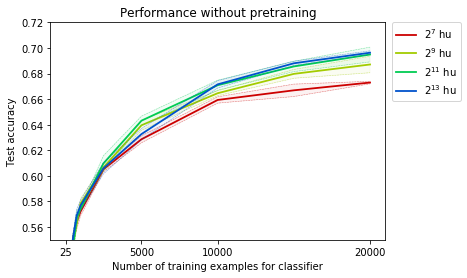

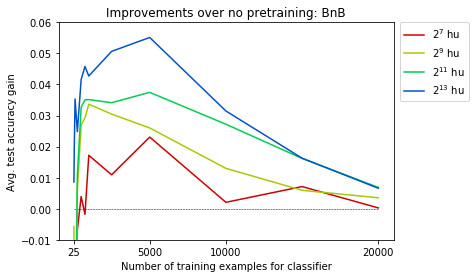

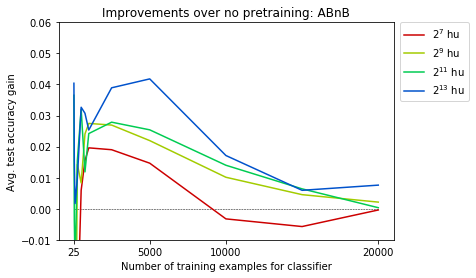

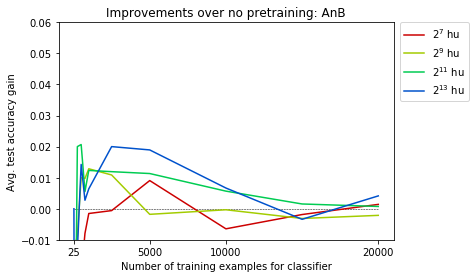

In [8]:
# create overview plot with differences
colors = get_colors(len(n_hus))
plt.figure()
for i, n in enumerate(n_hus):
    plot_mean_std(results_test[n]["B"], c=colors[i], label="$2^{%i}$ hu" % (n))
plt.xlabel("Number of training examples for classifier")
plt.xticks([25, 5000, 10000, 20000], [25, 5000, 10000, 20000])
plt.ylabel("Test accuracy")
plt.ylim(0.55, 0.72)
plt.title("Performance without pretraining")
l = plt.legend(bbox_to_anchor=(1.02, 1), loc=2, borderaxespad=0.);
if savefigs: plt.savefig('fig_pretr_acc_nopt.pdf', dpi=300, bbox_inches="tight", bbox_extra_artists=[l])
for case in ["BnB", "ABnB", "AnB"]:
    plt.figure()
    plt.plot([25, 20000], [0, 0], "--k", linewidth=0.5)
    for i, n in enumerate(n_hus):
        v = [results_test[n][case][k][0] - results_test[n]["B"][k][0] for k in range(len(results_test[n]["B"]))]
        plt.plot(n_training_examples, v, color=colors[i], label="$2^{%i}$ hu" % (n))
    plt.xlabel("Number of training examples for classifier")
    plt.xticks([25, 5000, 10000, 20000], [25, 5000, 10000, 20000])
    plt.ylabel("Avg. test accuracy gain")
    plt.title("Improvements over no pretraining: %s" % case)
    plt.ylim(-0.01, 0.06)
    l = plt.legend(bbox_to_anchor=(1.02, 1), loc=2, borderaxespad=0.);
    if savefigs: plt.savefig('img_acc_%s.pdf' % case, dpi=300, bbox_inches="tight", bbox_extra_artists=[l])